# Solitary Laser With and Without Self-Feedback Simulation

This notebook simulates a solitary laser with and without self-feedback, focusing on rigorous PI curve analysis with annotated threshold, linear, and saturation regions.


## Imports and Physical Constants


In [1]:
import os
import platform
#M1/M2 error fix
if platform.machine() == 'arm64': 
    # check for clang if mac
    os.environ['CC'] = 'clang'
    # clear other flags
    os.environ['CFLAGS'] = ''
    os.environ['LDFLAGS'] = ''
    try:
        import distutils.sysconfig
        original_customize = distutils.sysconfig.customize_compiler
        def customize_no_apple_m1(compiler):
            result = original_customize(compiler)
            for attr in ['compiler', 'compiler_so', 'compiler_cxx', 'compiler_so_cxx']:
                if hasattr(compiler, attr):
                    flags = getattr(compiler, attr)
                    if isinstance(flags, list):
                        setattr(compiler, attr, [f for f in flags if 'apple-m1' not in str(f)])
            return result
        distutils.sysconfig.customize_compiler = customize_no_apple_m1
    except (ImportError, AttributeError):
        try:
            from setuptools import dist
            pass
        except ImportError:
            pass

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from jitcdde import jitcdde, y, t
import symengine
from symengine import sin, cos
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Fundamental constants
e_charge = 1.602e-19  # Elementary charge (C)
c = 3e8                # Speed of light (m/s)
k_B = 1.380649e-23     # Boltzmann constant (J/K)
T_room = 300           # Room temperature (K)
k_BT_eV = 0.026        # k_B*T in eV at room temperature

# Material/gain parameters
alpha = 3.0            # Linewidth enhancement factor (dimensionless)
g = 1.2e4              # Differential gain coefficient (s^-1)
N_0 = 1.25e8           # Transparency carrier number (dimensionless)
s = 5e-7               # Saturation coefficient (dimensionless)

# Decay rates (in s^-1)
gamma = 4.96e11        # Photon decay rate (s^-1)
gamma_e = 6.51e8       # Carrier decay rate (s^-1)

# Convert rates to ns^-1 for DDE solver (to avoid numerical stiffness)
# Time unit: 1 unit = 1 nanosecond (ns)
gamma_ns = gamma * 1e-9      # Photon decay rate (ns^-1) = 496.0 ns^-1
gamma_e_ns = gamma_e * 1e-9  # Carrier decay rate (ns^-1) = 0.651 ns^-1
g_ns = g * 1e-9             # Differential gain (ns^-1) = 0.012 ns^-1

# Optical properties
n = 3.6                # Refractive index (dimensionless)
ne = 4.0               # Effective refractive index (dimensionless)
l = 250e-6             # Laser length (m)
tau_in = 2 * ne * l / c  # Round trip time (s)
wavelength = 655e-9    # Wavelength (m)
omega = 2 * np.pi * c / wavelength  # Angular frequency (rad/s)
r_0 = (n - 1) / (n + 1)  # Facet reflectivity

# Electrical
I_th = 17.35e-3        # Threshold current (A)

# Simulation parameters
# For ODE (no feedback): keep in seconds
T_trans = 100 / gamma  # Transient time: 100 photon lifetimes (~200 ps)
T_sample = 100e-9      # Sampling time: 100 ns
dt_ode = 0.01 / gamma   # ODE step size (~0.02 ps)
dt_sample = 0.1e-9     # Sampling interval (0.1 ns)

# For DDE (with feedback): use nanoseconds for numerical stability
T_trans_ns = 200.0     # Transient time: 200 ns (reasonable for stability)
T_sample_ns = 200.0    # Sampling time: 200 ns
dt_dde_ns = 0.1        # DDE max step: 0.1 ns
dt_sample_ns = 0.1     # Sampling interval: 0.1 ns

# Backward compatibility: dt_dde in seconds (for call sites that still use it)
dt_dde = dt_dde_ns * 1e-9  # DDE max step: 0.1 ns = 0.1e-9 s


## Simulation Functions

### Without Self-Feedback (ODE)


In [2]:
def simulate_solitary_laser_no_feedback(I, T_trans, T_sample, dt, ics=None):
    """
    Simulate solitary laser without self-feedback using ODE solver.
    
    Equations:
    ẋ = (1/2)(G - γ)x - αy
    ẏ = (1/2)(G - γ)y + αx
    Ṅ = I/e - γeN - G(x² + y²)
    G = g(N - N₀)/(1 + s(x² + y²))
    
    Parameters:
    -----------
    I : float
        Injection current (A)
    T_trans : float
        Transient time to discard (s)
    T_sample : float
        Sampling time after transients (s)
    dt : float
        Time step for integration (s)
    ics : array-like, optional
        Initial conditions [x(0), y(0), N(0)]. If None, uses defaults.
    
    Returns:
    --------
    time : array
        Time array (only sampling period)
    E2 : array
        Intensity E²(t) = x²(t) + y²(t)
    N : array
        Carrier density N(t)
    """
    #intiial conditions
    if ics is None:
        x0 = np.random.normal(0, 1e-6)
        y0 = np.random.normal(0, 1e-6)
        N0_val = N_0  # Start at transparency
        ics = [x0, y0, N0_val]
    
    def rate_equations(time, state):
        """Rate equations for solitary laser without feedback."""
        x, y, N = state
        
        # Intensity and gain
        E2 = x**2 + y**2
        G = g * (N - N_0) / (1 + s * E2)
        
        # Rate equations
        dx_dt = 0.5 * (G - gamma) * x - alpha * y
        dy_dt = 0.5 * (G - gamma) * y + alpha * x
        dN_dt = I / e_charge - gamma_e * N - G * E2
        
        return [dx_dt, dy_dt, dN_dt]
    
    # Integrate for transient + sampling period
    t_span = (0, T_trans + T_sample)
    t_eval = np.arange(0, T_trans + T_sample, dt)
    
    sol = solve_ivp(rate_equations, t_span, ics, t_eval=t_eval, 
                    method='RK45', rtol=1e-6, atol=1e-8)
    
    # Extract only sampling period
    mask = sol.t >= T_trans
    time_sample = sol.t[mask]
    x_sample = sol.y[0, mask]
    y_sample = sol.y[1, mask]
    N_sample = sol.y[2, mask]
    E2_sample = x_sample**2 + y_sample**2
    
    return time_sample, E2_sample, N_sample


### With Self-Feedback (DDE)


In [3]:
def _generate_feedback_equations_ns(I, kf, tau_f_ns, phi_f):
    """
    Generate DDE equations for solitary laser with self-feedback.
    
    use ns (ns) AND ns^-1 RATES.
    This ensures numerical stability by avoiding mixing scales.
    
    Parameters:
    -----------
    I : float
        Injection current (A)
    kf : float
        Feedback strength (dimensionless)
    tau_f_ns : float
        External cavity delay (ns) - MUST be in nanoseconds
    phi_f : float
        Feedback phase (rad)
    
    Returns:
    --------
    equations : list
        List of symbolic equations [dx_dt, dy_dt, dN_dt]
        All derivatives are per nanosecond (ns^-1)
    """
    from jitcdde import y, t
    
    # Convert parameters to Python floats to avoid numpy scalar issues
    tau_f_ns = float(tau_f_ns)
    phi_f = float(phi_f)
    kf = float(kf)
    I = float(I)
    
    # Define DDE system using symengine
    x_var = y(0)
    y_var = y(1)
    N_var = y(2)
    
    # Intensity and gain
    E2 = x_var**2 + y_var**2
    # Use ns-converted gain: g_ns is in ns^-1
    G = g_ns * (N_var - N_0) / (1 + s * E2)
    
    # Delayed variables - MUST use symbolic 't' from jitcdde
    # tau_f_ns is already in nanoseconds, matching the time unit
    x_delayed = y(0, t - tau_f_ns)
    y_delayed = y(1, t - tau_f_ns)
    
    # Rate equations with feedback
    # All rates (gamma_ns, alpha, g_ns) are in ns^-1
    # I/e_charge is in s^-1, so convert to ns^-1: (I/e_charge) * 1e-9
    dx_dt = 0.5 * (G - gamma_ns) * x_var - alpha * y_var + \
            kf * (x_delayed * cos(phi_f) - y_delayed * sin(phi_f))
    dy_dt = 0.5 * (G - gamma_ns) * y_var + alpha * x_var + \
            kf * (y_delayed * cos(phi_f) + x_delayed * sin(phi_f))
    dN_dt = (I / e_charge) * 1e-9 - gamma_e_ns * N_var - G * E2
    
    return [dx_dt, dy_dt, dN_dt]


def simulate_solitary_laser_with_feedback(I, kf, tau_f, phi_f, T_trans=None, T_sample=None, dt=None, ics=None, history=None):
    """
    Simulate solitary laser with self-feedback using DDE solver.
    
    ALL INTERNAL CALCULATIONS USE NANOSECONDS (ns) FOR NUMERICAL STABILITY.
    Input parameters can be in seconds, but are converted to ns internally.
    
    Equations (in ns^-1):
    ẋ = (1/2)(G - γ)x - αy + kf[x(t-τf)cos(φf) - y(t-τf)sin(φf)]
    ẏ = (1/2)(G - γ)y + αx + kf[y(t-τf)cos(φf) + x(t-τf)sin(φf)]
    Ṅ = (I/e)*1e-9 - γeN - G(x² + y²)
    G = g_ns(N - N₀)/(1 + s(x² + y²))
    
    Parameters:
    -----------
    I : float
        Injection current (A)
    kf : float
        Feedback strength (dimensionless)
    tau_f : float
        External cavity delay (s) - will be converted to ns
    phi_f : float
        Feedback phase (rad)
    T_trans : float, optional
        Transient time to discard (s). If None, uses T_trans_ns (200 ns)
    T_sample : float, optional
        Sampling time after transients (s). If None, uses T_sample_ns (200 ns)
    dt : float, optional
        Maximum time step for integration (s). If None, uses dt_dde_ns (0.1 ns)
    ics : array-like, optional
        Initial conditions [x(0), y(0), N(0)]
    history : callable, optional
        History function for t ∈ [-τf, 0]. If None, uses constant history.
    
    Returns:
    --------
    time : array
        Time array in seconds (only sampling period)
    E2 : array
        Intensity E²(t) = x²(t) + y²(t)
    N : array
        Carrier density N(t)
    """
    # Convert all time parameters to nanoseconds
    tau_f_ns = float(tau_f) * 1e9  # Convert s to ns
    
    # Use global defaults if not provided
    if T_trans is None:
        T_trans_ns = 200.0  # Default: 200 ns
    else:
        T_trans_ns = float(T_trans) * 1e9  # Convert s to ns
    
    if T_sample is None:
        T_sample_ns = 200.0  # Default: 200 ns
    else:
        T_sample_ns = float(T_sample) * 1e9  # Convert s to ns
    
    if dt is None:
        dt_ns = 0.1  # Default: 0.1 ns
    else:
        dt_ns = float(dt) * 1e9  # Convert s to ns
    
    dt_sample_ns_local = 0.1  # Default: 0.1 ns
    
    # Default initial conditions
    if ics is None:
        x0 = np.random.normal(0, 1e-6)
        y0 = np.random.normal(0, 1e-6)
        N0_val = N_0
        ics = [x0, y0, N0_val]
    
    # Generate equations using helper function (all in ns)
    equations = _generate_feedback_equations_ns(I, kf, tau_f_ns, phi_f)
    
    # Initialize DDE solver with max_delay in ns
    dde = jitcdde(equations, max_delay=tau_f_ns)
    # Use relaxed tolerances for better stability
    dde.set_integration_parameters(rtol=1e-3, atol=1e-5, max_step=dt_ns)
    
    # Set history function
    if history is None:
        # Constant history
        dde.constant_past(ics, time=0.0)
    else:
        # Custom history function
        dde.past_from_function(history)
    
    # Handle discontinuities
    dde.step_on_discontinuities()
    
    # Integrate through transient period (all in ns)
    time_current_ns = dde.t
    while time_current_ns < T_trans_ns:
        time_current_ns = min(time_current_ns + dt_ns, T_trans_ns)
        dde.integrate(time_current_ns)
    
    # Sample during sampling period (all in ns)
    time_sample_ns = []
    x_sample = []
    y_sample = []
    N_sample = []
    
    time_end_ns = T_trans_ns + T_sample_ns
    while time_current_ns < time_end_ns:
        time_current_ns = min(time_current_ns + dt_sample_ns_local, time_end_ns)
        state = dde.integrate(time_current_ns)
        time_sample_ns.append(time_current_ns)
        x_sample.append(state[0])
        y_sample.append(state[1])
        N_sample.append(state[2])
    
    # Convert to arrays
    time_sample_ns = np.array(time_sample_ns)
    x_sample = np.array(x_sample)
    y_sample = np.array(y_sample)
    N_sample = np.array(N_sample)
    E2_sample = x_sample**2 + y_sample**2
    
    # Convert time back to seconds for consistency with ODE version
    time_sample = time_sample_ns * 1e-9
    
    return time_sample, E2_sample, N_sample


In [4]:
# Quick test of DDE function with nanosecond units
print("Testing DDE function with consistent nanosecond units...")
print(f"  gamma_ns = {gamma_ns:.3f} ns^-1")
print(f"  gamma_e_ns = {gamma_e_ns:.6f} ns^-1")
print(f"  g_ns = {g_ns:.6f} ns^-1")
print(f"  T_trans_ns = {T_trans_ns} ns")
print(f"  T_sample_ns = {T_sample_ns} ns")
print(f"  dt_dde_ns = {dt_dde_ns} ns")

# Test with a small kf value
test_I = I_th * 1.5  # 1.5x threshold
test_kf = 0.1  # Small feedback
test_tau_f = 10e-9  # 10 ns in seconds
test_phi_f = 0.0

print(f"\nTesting simulation:")
print(f"  I = {test_I*1e3:.2f} mA")
print(f"  kf = {test_kf}")
print(f"  tau_f = {test_tau_f*1e9:.1f} ns")

try:
    time_test, E2_test, N_test = simulate_solitary_laser_with_feedback(
        test_I, test_kf, test_tau_f, test_phi_f)
    print(f"✓ Simulation successful!")
    print(f"  Time samples: {len(time_test)}")
    print(f"  Mean E²: {np.mean(E2_test):.6e}")
    print(f"  Mean N: {np.mean(N_test):.2e}")
except Exception as e:
    print(f"✗ Simulation failed: {e}")
    import traceback
    traceback.print_exc()


Testing DDE function with consistent nanosecond units...
  gamma_ns = 496.000 ns^-1
  gamma_e_ns = 0.651000 ns^-1
  g_ns = 0.000012 ns^-1
  T_trans_ns = 200.0 ns
  T_sample_ns = 200.0 ns
  dt_dde_ns = 0.1 ns

Testing simulation:
  I = 26.02 mA
  kf = 0.1
  tau_f = 10.0 ns
Generating, compiling, and loading C code.
✓ Simulation successful!
  Time samples: 2000
  Mean E²: 1.066735e+05
  Mean N: 1.69e+08


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_5w_1bo1t/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_5w_1bo1t/jitced.o': found architecture 'arm64', required architecture 'x86_64'


In [5]:
## Statistical Analysis Functions

def compute_statistics(data_array, confidence=0.95):
    """
    Compute comprehensive statistics from multiple realizations.
    
    Parameters:
    -----------
    data_array : array-like
        Array of values (can be 1D or 2D where rows are realizations)
    confidence : float
        Confidence level (0.95 for 95%, 0.99 for 99%)
    
    Returns:
    --------
    stats : dict
        Dictionary with mean, std, sem, ci_lower, ci_upper, cv, n
    """
    data_array = np.array(data_array)
    
    # Handle 2D case (multiple realizations)
    if data_array.ndim == 2:
        mean = np.mean(data_array, axis=0)
        std = np.std(data_array, axis=0, ddof=1)  # Sample std
        n = data_array.shape[0]
    else:
        mean = np.mean(data_array)
        std = np.std(data_array, ddof=1)
        n = len(data_array)
    
    # Standard error of the mean
    sem = std / np.sqrt(n) if n > 1 else 0
    
    # Confidence interval (using t-distribution for small n, normal for large n)
    if n > 30:
        z_score = 1.96 if confidence == 0.95 else 2.58  # 95% or 99%
        ci_lower = mean - z_score * sem
        ci_upper = mean + z_score * sem
    else:
        from scipy import stats as scipy_stats
        t_score = scipy_stats.t.ppf((1 + confidence) / 2, n - 1)
        ci_lower = mean - t_score * sem
        ci_upper = mean + t_score * sem
    
    # Coefficient of variation
    cv = std / np.abs(mean) if np.abs(mean) > 0 else np.inf
    
    return {
        'mean': mean,
        'std': std,
        'sem': sem,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'cv': cv,
        'n': n
    }


def run_multiple_realizations(sim_func, *args, n_realizations=10, **kwargs):
    """
    Run simulation multiple times with different random seeds.
    
    Parameters:
    -----------
    sim_func : callable
        Simulation function to call
    *args : positional arguments for sim_func
    n_realizations : int
        Number of realizations to run
    **kwargs : keyword arguments for sim_func
    
    Returns:
    --------
    results : dict
        Dictionary with time, E2, N arrays from all realizations
    stats : dict
        Statistical summary for E2 and N
    """
    all_time = []
    all_E2 = []
    all_N = []
    
    for i in range(n_realizations):
        # Set random seed for reproducibility (but different for each realization)
        np.random.seed(42 + i)
        
        # Run simulation
        time, E2, N = sim_func(*args, **kwargs)
        
        all_time.append(time)
        all_E2.append(E2)
        all_N.append(N)
    
    # Convert to arrays
    all_E2 = np.array(all_E2)  # Shape: (n_realizations, n_time_points)
    all_N = np.array(all_N)
    
    # Compute statistics for each time point
    E2_stats = {
        'mean': np.mean(all_E2, axis=0),
        'std': np.std(all_E2, axis=0, ddof=1),
        'sem': np.std(all_E2, axis=0, ddof=1) / np.sqrt(n_realizations),
    }
    
    N_stats = {
        'mean': np.mean(all_N, axis=0),
        'std': np.std(all_N, axis=0, ddof=1),
        'sem': np.std(all_N, axis=0, ddof=1) / np.sqrt(n_realizations),
    }
    
    # Overall statistics (across all time points)
    E2_overall = compute_statistics(all_E2.flatten(), confidence=0.95)
    N_overall = compute_statistics(all_N.flatten(), confidence=0.95)
    
    return {
        'time': all_time[0],  # Time is the same for all realizations
        'E2': all_E2,
        'N': all_N,
        'E2_stats': E2_stats,
        'N_stats': N_stats,
        'E2_overall': E2_overall,
        'N_overall': N_overall,
        'n_realizations': n_realizations
    }


In [6]:
## Time-Series Analysis Functions

def compute_psd(time, signal, detrend=True):
    """
    Compute power spectral density of a time series.
    
    Parameters:
    -----------
    time : array
        Time array (s)
    signal : array
        Signal array
    detrend : bool
        Whether to detrend the signal before FFT
    
    Returns:
    --------
    freq : array
        Frequency array (Hz)
    psd : array
        Power spectral density
    """
    from scipy import signal as scipy_signal
    
    # Sampling frequency
    dt = np.mean(np.diff(time))
    fs = 1.0 / dt
    
    # Detrend if requested
    if detrend:
        signal_detrended = scipy_signal.detrend(signal)
    else:
        signal_detrended = signal
    
    # Compute PSD using Welch's method
    freq, psd = scipy_signal.welch(signal_detrended, fs=fs, nperseg=min(len(signal)//4, 256))
    
    return freq, psd


def compute_autocorrelation(time, signal, max_lag=None):
    """
    Compute autocorrelation function.
    
    Parameters:
    -----------
    time : array
        Time array (s)
    signal : array
        Signal array
    max_lag : int, optional
        Maximum lag to compute (default: len(signal)//4)
    
    Returns:
    --------
    lags : array
        Lag times (s)
    autocorr : array
        Autocorrelation values
    """
    from scipy import signal as scipy_signal
    
    dt = np.mean(np.diff(time))
    
    if max_lag is None:
        max_lag = len(signal) // 4
    
    # Normalize signal
    signal_norm = (signal - np.mean(signal)) / np.std(signal)
    
    # Compute autocorrelation
    autocorr = scipy_signal.correlate(signal_norm, signal_norm, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    autocorr = autocorr[:max_lag] / autocorr[0]  # Normalize
    
    lags = np.arange(len(autocorr)) * dt
    
    return lags, autocorr


def compute_cross_correlation(time, signal1, signal2):
    """
    Compute cross-correlation between two signals.
    
    Parameters:
    -----------
    time : array
        Time array (s)
    signal1 : array
        First signal
    signal2 : array
        Second signal
    
    Returns:
    --------
    lags : array
        Lag times (s)
    crosscorr : array
        Cross-correlation values
    """
    from scipy import signal as scipy_signal
    
    dt = np.mean(np.diff(time))
    
    # Normalize signals
    s1_norm = (signal1 - np.mean(signal1)) / np.std(signal1)
    s2_norm = (signal2 - np.mean(signal2)) / np.std(signal2)
    
    # Compute cross-correlation
    crosscorr = scipy_signal.correlate(s1_norm, s2_norm, mode='full')
    mid = len(crosscorr) // 2
    lags = np.arange(-mid, mid) * dt
    
    return lags, crosscorr


def plot_time_series(time, E2, N=None, x=None, y=None, title="Time Series", filename=None):
    """
    Plot time series of laser variables.
    
    Parameters:
    -----------
    time : array
        Time array (s or ns)
    E2 : array
        Intensity E²(t)
    N : array, optional
        Carrier density N(t)
    x : array, optional
        Real part of electric field
    y : array, optional
        Imaginary part of electric field
    title : str
        Plot title
    filename : str, optional
        Filename to save plot
    """
    n_plots = 1 + (N is not None) + (x is not None and y is not None)
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, 4*n_plots), sharex=True)
    
    if n_plots == 1:
        axes = [axes]
    
    idx = 0
    
    # Plot E²
    axes[idx].plot(time*1e9, E2, 'b-', linewidth=1.5, alpha=0.8)
    axes[idx].set_ylabel('Intensity E² [arb. units]', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    idx += 1
    
    # Plot N if provided
    if N is not None:
        axes[idx].plot(time*1e9, N, 'r-', linewidth=1.5, alpha=0.8)
        axes[idx].set_ylabel('Carrier Density N [arb. units]', fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
        idx += 1
    
    # Plot phase space (x, y) if provided
    if x is not None and y is not None:
        axes[idx].plot(x, y, 'g-', linewidth=1.5, alpha=0.8)
        axes[idx].set_xlabel('Real E-field x', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Imag E-field y', fontsize=12, fontweight='bold')
        axes[idx].set_title('Phase Portrait (x, y)', fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].axis('equal')
        idx += 1
    
    axes[-1].set_xlabel('Time [ns]', fontsize=12, fontweight='bold')
    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


def plot_phase_portrait(x, y, E2=None, title="Phase Portrait", filename=None):
    """
    Plot phase portrait.
    
    Parameters:
    -----------
    x : array
        Real part of electric field
    y : array
        Imaginary part of electric field
    E2 : array, optional
        Intensity for color-coding
    title : str
        Plot title
    filename : str, optional
        Filename to save plot
    """
    plt.figure(figsize=(10, 10))
    
    if E2 is not None:
        plt.scatter(x, y, c=E2, cmap='viridis', s=10, alpha=0.6, edgecolors='none')
        plt.colorbar(label='Intensity E²')
    else:
        plt.plot(x, y, 'b-', linewidth=1.5, alpha=0.7)
    
    plt.xlabel('Real E-field x', fontsize=14, fontweight='bold')
    plt.ylabel('Imag E-field y', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


In [7]:
## Bifurcation Analysis Functions

def create_bifurcation_diagram(parameter_array, E2_data, title="Bifurcation Diagram", 
                               xlabel="Parameter", filename=None):
    """
    Create bifurcation diagram showing E² vs parameter.
    
    Parameters:
    -----------
    parameter_array : array
        Parameter values (e.g., I or kf)
    E2_data : array or list of arrays
        Intensity data. If list, each element is E²(t) for one parameter value
    title : str
        Plot title
    xlabel : str
        X-axis label
    filename : str, optional
        Filename to save plot
    """
    plt.figure(figsize=(12, 8))
    
    # Handle different data formats
    if isinstance(E2_data[0], (list, np.ndarray)) and len(E2_data[0]) > 1:
        # Time series data - extract local maxima/minima or use Poincaré section
        for i, param in enumerate(parameter_array):
            E2_vals = E2_data[i]
            if isinstance(E2_vals, np.ndarray) and len(E2_vals) > 10:
                # Use last portion of data (after transients)
                E2_sample = E2_vals[-len(E2_vals)//2:]
                # Plot all points or sample
                if len(E2_sample) > 100:
                    # Sample for clarity
                    indices = np.linspace(0, len(E2_sample)-1, 100, dtype=int)
                    plt.plot([param]*len(indices), E2_sample[indices], 'b.', 
                            markersize=1, alpha=0.5)
                else:
                    plt.plot([param]*len(E2_sample), E2_sample, 'b.', 
                            markersize=1, alpha=0.5)
    else:
        # Mean values
        plt.plot(parameter_array, E2_data, 'o-', linewidth=2, markersize=6)
    
    plt.xlabel(xlabel, fontsize=14, fontweight='bold')
    plt.ylabel('Intensity E² [arb. units]', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


def extract_local_maxima(time, signal):
    """
    Extract local maxima from a time series (for Poincaré sections).
    
    Parameters:
    -----------
    time : array
        Time array
    signal : array
        Signal array
    
    Returns:
    --------
    maxima_times : array
        Times at which maxima occur
    maxima_values : array
        Values at maxima
    """
    from scipy.signal import find_peaks
    
    # Find peaks
    peaks, properties = find_peaks(signal, height=np.max(signal)*0.1)
    
    return time[peaks], signal[peaks]


In [8]:
## Stability & Chaos Metrics Functions

def estimate_largest_lyapunov_exponent(time, signal, dt=None, m=3, tau=1):
    """
    Estimate largest Lyapunov exponent using Rosenstein's algorithm.
    
    Parameters:
    -----------
    time : array
        Time array
    signal : array
        Signal array (1D)
    dt : float, optional
        Time step (if None, computed from time)
    m : int
        Embedding dimension
    tau : int
        Time delay (in samples)
    
    Returns:
    --------
    lle : float
        Estimated largest Lyapunov exponent
    """
    if dt is None:
        dt = np.mean(np.diff(time))
    
    # Simple implementation - for production, use more robust method
    # This is a simplified version
    n = len(signal)
    if n < 100:
        return 0.0  # Not enough data
    
    # Normalize signal
    signal_norm = (signal - np.mean(signal)) / np.std(signal)
    
    # Simple estimate: compute divergence rate
    # This is a simplified version - full implementation would use
    # phase space reconstruction and nearest neighbor tracking
    try:
        from scipy.spatial.distance import pdist
        # Use a simple approach: compute average divergence
        # For a more accurate LLE, use specialized libraries like nolds
        # For now, return a placeholder that indicates stability
        # Positive = chaotic, negative = stable
        return 0.0  # Placeholder - implement full algorithm for production
    except:
        return 0.0


def compute_correlation_dimension(time, signal, m_max=10, tau=1):
    """
    Estimate correlation dimension using Grassberger-Procaccia algorithm.
    
    Parameters:
    -----------
    time : array
        Time array
    signal : array
        Signal array
    m_max : int
        Maximum embedding dimension
    tau : int
        Time delay
    
    Returns:
    --------
    D2 : float
        Correlation dimension estimate
    """
    # Simplified implementation
    # Full implementation would use phase space reconstruction
    # For production, use specialized libraries
    return 2.0  # Placeholder


def compute_sample_entropy(time, signal, m=2, r=None):
    """
    Compute sample entropy (SampEn) of a time series.
    
    Parameters:
    -----------
    time : array
        Time array
    signal : array
        Signal array
    m : int
        Template length
    r : float, optional
        Tolerance (if None, uses 0.2 * std(signal))
    
    Returns:
    --------
    sampen : float
        Sample entropy value
    """
    if r is None:
        r = 0.2 * np.std(signal)
    
    n = len(signal)
    if n < 10 * m:
        return 0.0
    
    # Simplified implementation
    # Full implementation would count matching patterns
    # For production, use specialized libraries like nolds or antropy
    return 0.5  # Placeholder


In [9]:
## Convergence Study Functions

def convergence_study(sim_func, I_test, param_name, param_values, *args, **kwargs):
    """
    Perform convergence study by varying a parameter.
    
    Parameters:
    -----------
    sim_func : callable
        Simulation function
    I_test : float
        Test current value
    param_name : str
        Name of parameter to vary (e.g., 'T_trans', 'dt')
    param_values : array
        Parameter values to test
    *args, **kwargs : additional arguments for sim_func
    
    Returns:
    --------
    results : dict
        Dictionary with parameter values and corresponding E² means
    """
    results = {'param_values': param_values, 'E2_mean': [], 'E2_std': []}
    
    print(f"Convergence study: {param_name}")
    for param_val in tqdm(param_values):
        kwargs[param_name] = param_val
        time, E2, N = sim_func(I_test, *args, **kwargs)
        results['E2_mean'].append(np.mean(E2))
        results['E2_std'].append(np.std(E2))
    
    results['E2_mean'] = np.array(results['E2_mean'])
    results['E2_std'] = np.array(results['E2_std'])
    
    return results


def plot_convergence(results, param_name, title="Convergence Study", filename=None):
    """
    Plot convergence study results.
    
    Parameters:
    -----------
    results : dict
        Results from convergence_study
    param_name : str
        Parameter name for x-axis label
    title : str
        Plot title
    filename : str, optional
        Filename to save plot
    """
    plt.figure(figsize=(10, 6))
    plt.errorbar(results['param_values'], results['E2_mean'], 
                yerr=results['E2_std'], fmt='o-', capsize=3, linewidth=2)
    plt.xlabel(param_name, fontsize=14, fontweight='bold')
    plt.ylabel('Mean E² [arb. units]', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


In [10]:
## ML-Ready Data Export Functions

def prepare_ml_dataset(I_array, E2_mean, N_mean, V_mean=None, 
                       kf=None, tau_f=None, phi_f=None,
                       E2_sem=None, feature_names=None):
    """
    Prepare dataset for machine learning with feature engineering.
    
    Parameters:
    -----------
    I_array : array
        Current values (A)
    E2_mean : array
        Mean intensity values
    N_mean : array
        Mean carrier density values
    V_mean : array, optional
        Mean voltage values
    kf : float or array, optional
        Feedback strength
    tau_f : float or array, optional
        Feedback delay
    phi_f : float or array, optional
        Feedback phase
    E2_sem : array, optional
        Standard error of the mean for E²
    feature_names : list, optional
        Custom feature names
    
    Returns:
    --------
    features : array
        Feature matrix (n_samples, n_features)
    targets : array
        Target values (E²)
    feature_names : list
        Feature names
    metadata : dict
        Metadata dictionary
    """
    n_samples = len(I_array)
    
    # Build feature matrix
    features_list = []
    names_list = []
    
    # Basic features
    features_list.append(I_array)
    names_list.append('I')
    
    if V_mean is not None:
        features_list.append(V_mean)
        names_list.append('V')
    
    # Normalized features
    I_norm = (I_array - I_th) / I_th if I_th > 0 else I_array
    features_list.append(I_norm)
    names_list.append('I_norm')
    
    # Derived features
    if len(I_array) > 1:
        dE2_dI = np.gradient(E2_mean, I_array)
        features_list.append(dE2_dI)
        names_list.append('dE2_dI')
        
        if len(N_mean) > 1:
            dN_dI = np.gradient(N_mean, I_array)
            features_list.append(dN_dI)
            names_list.append('dN_dI')
    
    # Feedback parameters
    if kf is not None:
        if isinstance(kf, (int, float)):
            kf_array = np.full(n_samples, kf)
        else:
            kf_array = kf
        features_list.append(kf_array)
        names_list.append('kf')
        
        # Normalized kf (if critical value known)
        # kf_critical = 1.0  # Adjust based on physics
        # kf_norm = kf_array / kf_critical
        # features_list.append(kf_norm)
        # names_list.append('kf_norm')
    
    if tau_f is not None:
        if isinstance(tau_f, (int, float)):
            tau_f_array = np.full(n_samples, tau_f)
        else:
            tau_f_array = tau_f
        features_list.append(tau_f_array)
        names_list.append('tau_f')
        
        # Dimensionless delay
        tau_photon = 1.0 / gamma  # Photon lifetime
        tau_f_norm = tau_f_array / tau_photon
        features_list.append(tau_f_norm)
        names_list.append('tau_f_norm')
    
    if phi_f is not None:
        if isinstance(phi_f, (int, float)):
            phi_f_array = np.full(n_samples, phi_f)
        else:
            phi_f_array = phi_f
        features_list.append(phi_f_array)
        names_list.append('phi_f')
    
    # Convert to feature matrix
    features = np.column_stack(features_list)
    targets = E2_mean
    
    # Metadata
    metadata = {
        'feature_names': names_list if feature_names is None else feature_names,
        'target_name': 'E2',
        'n_samples': n_samples,
        'n_features': features.shape[1],
        'I_th': I_th,
        'has_uncertainty': E2_sem is not None
    }
    
    return features, targets, names_list if feature_names is None else feature_names, metadata


def export_ml_dataset(features, targets, feature_names, metadata, 
                       base_filename='ml_dataset', format='both'):
    """
    Export ML-ready dataset to CSV and/or HDF5.
    
    Parameters:
    -----------
    features : array
        Feature matrix
    targets : array
        Target values
    feature_names : list
        Feature names
    metadata : dict
        Metadata dictionary
    base_filename : str
        Base filename (without extension)
    format : str
        'csv', 'hdf5', or 'both'
    """
    import os
    import json
    from datetime import datetime
    
    os.makedirs('results/ml_data', exist_ok=True)
    
    # Add timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    base_path = f'results/ml_data/{base_filename}_{timestamp}'
    
    # Create DataFrame for CSV export
    if format in ['csv', 'both']:
        import pandas as pd
        
        # Features DataFrame
        df_features = pd.DataFrame(features, columns=feature_names)
        df_features.to_csv(f'{base_path}_features.csv', index=False)
        
        # Targets DataFrame
        df_targets = pd.DataFrame({'E2': targets})
        df_targets.to_csv(f'{base_path}_targets.csv', index=False)
        
        # Combined DataFrame
        df_combined = pd.DataFrame(features, columns=feature_names)
        df_combined['E2'] = targets
        df_combined.to_csv(f'{base_path}_combined.csv', index=False)
        
        print(f"CSV files saved:")
        print(f"  {base_path}_features.csv")
        print(f"  {base_path}_targets.csv")
        print(f"  {base_path}_combined.csv")
    
    # HDF5 export
    if format in ['hdf5', 'both']:
        import h5py
        
        with h5py.File(f'{base_path}.h5', 'w') as f:
            f.create_dataset('features', data=features)
            f.create_dataset('targets', data=targets)
            f.create_dataset('feature_names', data=[n.encode() for n in feature_names])
            
            # Store metadata as attributes
            for key, value in metadata.items():
                if isinstance(value, (int, float, str, bool)):
                    f.attrs[key] = value
                elif isinstance(value, list):
                    f.attrs[key] = str(value)
        
        print(f"HDF5 file saved: {base_path}.h5")
    
    # Save metadata as JSON
    metadata_file = f'{base_path}_metadata.json'
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2, default=str)
    print(f"Metadata saved: {metadata_file}")
    
    return base_path


In [11]:
# ============================================================================
# Advanced Visualization Functions
# ============================================================================

def plot_carrier_density_distribution(N_samples, I_value, bins=50, 
                                      fit_normal=True, title=None, filename=None):
    """
    Plot histogram of carrier density distribution.
    
    Parameters:
    -----------
    N_samples : array
        Carrier density time series
    I_value : float
        Current value (for title/label)
    bins : int
        Number of histogram bins
    fit_normal : bool
        Whether to overlay normal distribution fit
    title : str, optional
        Plot title
    filename : str, optional
        Filename to save plot
    """
    from scipy import stats
    
    plt.figure(figsize=(10, 6))
    
    # Plot histogram
    n, bins_edges, patches = plt.hist(N_samples, bins=bins, density=True, 
                                       alpha=0.7, color='steelblue', 
                                       edgecolor='black', linewidth=1.2)
    
    # Calculate statistics
    mean_N = np.mean(N_samples)
    std_N = np.std(N_samples)
    median_N = np.median(N_samples)
    skewness = stats.skew(N_samples)
    kurtosis = stats.kurtosis(N_samples)
    
    # Overlay normal distribution fit
    if fit_normal:
        x_fit = np.linspace(N_samples.min(), N_samples.max(), 200)
        y_fit = stats.norm.pdf(x_fit, mean_N, std_N)
        plt.plot(x_fit, y_fit, 'r-', linewidth=2, 
                label=f'Normal fit (μ={mean_N:.2e}, σ={std_N:.2e})')
    
    # Add vertical lines for statistics
    plt.axvline(mean_N, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_N:.2e}')
    plt.axvline(median_N, color='green', linestyle='--', linewidth=2, 
                label=f'Median: {median_N:.2e}')
    
    # Labels and title
    I_mA = I_value * 1e3
    if title is None:
        title = f'Carrier Density Distribution at I = {I_mA:.2f} mA'
    plt.xlabel('Carrier Density N [arb. units]', fontsize=14, fontweight='bold')
    plt.ylabel('Probability Density', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # Add statistics text box
    stats_text = f'Mean: {mean_N:.2e}\nStd: {std_N:.2e}\nSkewness: {skewness:.3f}\nKurtosis: {kurtosis:.3f}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


def plot_carrier_density_distributions_comparison(N_samples_dict, I_values, 
                                                  title=None, filename=None):
    """
    Plot multiple carrier density distributions side-by-side.
    
    Parameters:
    -----------
    N_samples_dict : dict
        Dictionary mapping current values to N_samples arrays
    I_values : array
        Current values to plot (subset of keys in N_samples_dict)
    title : str, optional
        Plot title
    filename : str, optional
        Filename to save plot
    """
    from scipy import stats
    
    n_plots = len(I_values)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, I_val in enumerate(I_values):
        if I_val not in N_samples_dict:
            continue
            
        N_samples = N_samples_dict[I_val]
        ax = axes[idx]
        
        # Plot histogram
        n, bins_edges, patches = ax.hist(N_samples, bins=30, density=True,
                                         alpha=0.7, color='steelblue',
                                         edgecolor='black', linewidth=1)
        
        # Calculate statistics
        mean_N = np.mean(N_samples)
        std_N = np.std(N_samples)
        
        # Overlay normal distribution fit
        x_fit = np.linspace(N_samples.min(), N_samples.max(), 200)
        y_fit = stats.norm.pdf(x_fit, mean_N, std_N)
        ax.plot(x_fit, y_fit, 'r-', linewidth=2)
        
        # Add mean line
        ax.axvline(mean_N, color='red', linestyle='--', linewidth=2)
        
        # Labels
        I_mA = I_val * 1e3
        ax.set_xlabel('N [arb. units]', fontsize=11, fontweight='bold')
        ax.set_ylabel('Density', fontsize=11, fontweight='bold')
        ax.set_title(f'I = {I_mA:.2f} mA\nμ={mean_N:.2e}, σ={std_N:.2e}', 
                    fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_plots, len(axes)):
        axes[idx].axis('off')
    
    if title is None:
        title = 'Carrier Density Distributions at Different Currents'
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


def plot_enhanced_phase_portrait(x, y, E2=None, N=None, time=None, 
                                 title="Phase Portrait", filename=None):
    """
    Enhanced phase portrait plotting with color-coding and flow arrows.
    
    Parameters:
    -----------
    x : array
        Real part of electric field
    y : array
        Imaginary part of electric field
    E2 : array, optional
        Intensity for color-coding
    N : array, optional
        Carrier density for (E², N) phase space
    time : array, optional
        Time array for color-coding by time
    title : str
        Plot title
    filename : str, optional
        Filename to save plot
    """
    fig = plt.figure(figsize=(14, 6))
    
    # Plot 1: (x, y) phase space
    ax1 = fig.add_subplot(1, 2, 1)
    
    if E2 is not None:
        scatter = ax1.scatter(x, y, c=E2, cmap='viridis', s=10, alpha=0.6)
        plt.colorbar(scatter, ax=ax1, label='E² [arb. units]')
        ax1.plot(x, y, 'k-', linewidth=0.5, alpha=0.3)
    elif time is not None:
        scatter = ax1.scatter(x, y, c=time, cmap='plasma', s=10, alpha=0.6)
        plt.colorbar(scatter, ax=ax1, label='Time [ns]')
        ax1.plot(x, y, 'k-', linewidth=0.5, alpha=0.3)
    else:
        ax1.plot(x, y, 'b-', linewidth=1.5, alpha=0.7)
    
    ax1.set_xlabel('Real E-field x', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Imag E-field y', fontsize=12, fontweight='bold')
    ax1.set_title('(x, y) Phase Space', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    # Plot 2: (E², N) phase space if N is provided
    if N is not None:
        ax2 = fig.add_subplot(1, 2, 2)
        
        if time is not None:
            scatter = ax2.scatter(E2, N, c=time, cmap='plasma', s=10, alpha=0.6)
            plt.colorbar(scatter, ax=ax2, label='Time [ns]')
            ax2.plot(E2, N, 'k-', linewidth=0.5, alpha=0.3)
        else:
            ax2.plot(E2, N, 'b-', linewidth=1.5, alpha=0.7)
            ax2.scatter(E2[0], N[0], color='green', s=100, marker='o', 
                       label='Start', zorder=5)
            ax2.scatter(E2[-1], N[-1], color='red', s=100, marker='s', 
                       label='End', zorder=5)
        
        ax2.set_xlabel('Intensity E² [arb. units]', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Carrier Density N [arb. units]', fontsize=12, fontweight='bold')
        ax2.set_title('(E², N) Phase Space', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        if time is None:
            ax2.legend(fontsize=10)
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


def plot_psd(time, E2, title="Power Spectral Density", filename=None):
    """
    Plot power spectral density of intensity oscillations.
    
    Parameters:
    -----------
    time : array
        Time array (s or ns)
    E2 : array
        Intensity E²(t)
    title : str
        Plot title
    filename : str, optional
        Filename to save plot
    """
    from scipy import signal
    
    # Compute PSD
    if len(time) > 1:
        dt = np.mean(np.diff(time))
        if dt < 1e-9:  # If in seconds, convert to ns
            dt *= 1e9
            time_ns = time * 1e9
        else:
            time_ns = time
        
        # Use Welch's method for better spectral estimation
        frequencies, psd = signal.welch(E2, 1/dt, nperseg=min(len(E2)//4, 2048))
        
        plt.figure(figsize=(12, 6))
        plt.semilogy(frequencies, psd, 'b-', linewidth=1.5)
        plt.xlabel('Frequency [GHz]', fontsize=14, fontweight='bold')
        plt.ylabel('Power Spectral Density [arb. units]', fontsize=14, fontweight='bold')
        plt.title(title, fontsize=16, fontweight='bold')
        plt.grid(True, alpha=0.3, which='both')
        plt.tight_layout()
        
        if filename:
            plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("Insufficient data points for PSD calculation")


def plot_intensity_carrier_scatter(N_samples, E2_samples, I_value=None,
                                   title="E² vs N Scatter Plot", filename=None):
    """
    Detailed scatter plot showing all (N, E²) pairs from time series.
    
    Parameters:
    -----------
    N_samples : array
        Carrier density time series
    E2_samples : array
        Intensity time series
    I_value : float, optional
        Current value for title
    title : str
        Plot title
    filename : str, optional
        Filename to save plot
    """
    plt.figure(figsize=(10, 8))
    
    # Scatter plot
    scatter = plt.scatter(N_samples, E2_samples, c=np.arange(len(N_samples)), 
                         cmap='viridis', s=10, alpha=0.6, edgecolors='none')
    plt.colorbar(scatter, label='Time Index')
    
    # Overlay mean trajectory
    N_mean = np.mean(N_samples)
    E2_mean = np.mean(E2_samples)
    plt.plot(N_mean, E2_mean, 'ro', markersize=15, 
            label=f'Mean: ({N_mean:.2e}, {E2_mean:.2e})', zorder=10)
    
    # Add current to title if provided
    if I_value is not None:
        I_mA = I_value * 1e3
        title = f'{title} at I = {I_mA:.2f} mA'
    
    plt.xlabel('Carrier Density N [arb. units]', fontsize=14, fontweight='bold')
    plt.ylabel('Intensity E² [arb. units]', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()



In [12]:
def plot_pi_curve(I_array, E2_mean, E2_std=None, E2_sem=None, Ith=None, title="PI Curve", filename=None):
    """
    Plot Power-Current (PI) curve with annotated regions and enhanced statistics.
    
    Parameters:
    -----------
    I_array : array
        Current values (A)
    E2_mean : array
        Mean intensity values
    E2_std : array, optional
        Standard deviation of intensity (for error bars)
    E2_sem : array, optional
        Standard error of the mean (preferred over std for error bars)
    Ith : float, optional
        Threshold current (A) for annotation
    title : str
        Plot title
    filename : str, optional
        Filename to save plot
    
    Returns:
    --------
    slope_efficiency : float, optional
        Slope efficiency (dE²/dI) in linear region
    r_squared : float, optional
        R² of linear fit
    """
    from scipy import stats
    
    I_mA = I_array * 1e3  # Convert to mA
    
    plt.figure(figsize=(12, 8))
    
    # Use SEM if provided (preferred), otherwise use std
    error_bars = E2_sem if E2_sem is not None else E2_std
    
    # Plot with error bars if provided
    if error_bars is not None:
        error_label = 'SEM' if E2_sem is not None else 'Std'
        plt.errorbar(I_mA, E2_mean, yerr=error_bars, fmt='o-', capsize=3, 
                    linewidth=2, markersize=6, label='Simulated Data', alpha=0.7)
    else:
        plt.plot(I_mA, E2_mean, 'o-', linewidth=2, markersize=6, label='Simulated Data', alpha=0.7)
    
    slope_efficiency = None
    r_squared = None
    
    # Annotate regions if threshold is provided
    if Ith is not None:
        Ith_mA = Ith * 1e3
        
        # Mark exact threshold with vertical line
        plt.axvline(Ith_mA, color='g', linestyle='--', linewidth=2,
                   label=f'Threshold ({Ith_mA:.2f} mA)', zorder=10)
        
        # Find threshold region (where E² lifts off from ~0)
        mask_above = I_array > Ith
        if np.any(mask_above):
            # Fit linear region
            I_linear = I_array[mask_above]
            E2_linear = E2_mean[mask_above]
            
            # Find linear region (exclude saturation)
            # Use first 80% of above-threshold data for linear fit
            n_linear = int(0.8 * len(I_linear))
            if n_linear > 1:
                I_fit = I_linear[:n_linear]
                E2_fit = E2_linear[:n_linear]
                
                # Linear fit with R² calculation
                coeffs = np.polyfit(I_fit, E2_fit, 1)
                slope = coeffs[0]
                intercept = coeffs[1]
                slope_efficiency = slope
                
                # Calculate R²
                E2_fit_pred = np.polyval(coeffs, I_fit)
                ss_res = np.sum((E2_fit - E2_fit_pred)**2)
                ss_tot = np.sum((E2_fit - np.mean(E2_fit))**2)
                r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
                
                # Plot linear fit
                I_fit_plot = np.linspace(Ith, I_fit[-1], 100)
                E2_fit_plot = np.polyval(coeffs, I_fit_plot)
                plt.plot(I_fit_plot * 1e3, E2_fit_plot, 'r--', linewidth=2,
                        label=f'Linear fit: slope={slope*1e-6:.2e}, R²={r_squared:.4f}')
                
                # Annotate saturation region
                I_sat = I_linear[n_linear:]
                if len(I_sat) > 0:
                    plt.axvspan(I_sat[0]*1e3, I_mA[-1], alpha=0.2, color='orange',
                              label='Saturation Region')
    
    plt.xlabel('Current [mA]', fontsize=14, fontweight='bold')
    plt.ylabel('Intensity E² [arb. units]', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11, loc='best')
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return slope_efficiency, r_squared


In [13]:
def plot_intensity_vs_carrier(N_array, E2_array, I_array, Ith=None, 
                               scatter=False, title="E² vs N", filename=None):
    """
    Plot intensity vs carrier density.
    
    Parameters:
    -----------
    N_array : array
        Mean carrier density values
    E2_array : array
        Mean intensity values
    I_array : array
        Current values (for highlighting amplified region)
    Ith : float, optional
        Threshold current (A)
    scatter : bool
        If True, plot scatter; if False, plot smooth curve
    title : str
        Plot title
    filename : str, optional
        Filename to save plot
    """
    plt.figure(figsize=(12, 8))
    
    if scatter:
        plt.scatter(N_array, E2_array, c=I_array*1e3, cmap='viridis', 
                   s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
        plt.colorbar(label='Current [mA]')
    else:
        # Plot smooth curve
        plt.plot(N_array, E2_array, 'o-', linewidth=2, markersize=6, alpha=0.7)
    
    # Highlight amplified region (I > Ith)
    if Ith is not None:
        mask_amplified = I_array > Ith
        if np.any(mask_amplified):
            N_amp = N_array[mask_amplified]
            E2_amp = E2_array[mask_amplified]
            plt.plot(N_amp, E2_amp, 'r-', linewidth=3, alpha=0.5, 
                    label='Amplified Region (I > Ith)')
            # Fill under curve
            plt.fill_between(N_amp, 0, E2_amp, alpha=0.2, color='red',
                           label='Amplified Region')
    
    # Set x-axis limits to focus on interesting region
    # Find where E² becomes significant (above noise floor)
    if Ith is not None:
        mask_interesting = I_array >= Ith * 0.95  # Start slightly before threshold
        if np.any(mask_interesting):
            N_interesting = N_array[mask_interesting]
            # Add some margin on both sides
            N_min = np.min(N_interesting) * 0.98
            N_max = np.max(N_interesting) * 1.02
            plt.xlim(N_min, N_max)
    
    plt.xlabel('Carrier Density N [arb. units]', fontsize=14, fontweight='bold')
    plt.ylabel('Intensity E² [arb. units]', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    if Ith is not None:
        plt.legend(fontsize=12)
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


In [14]:
def plot_log_intensity_vs_log_carrier(N_array, E2_array, I_array=None, Ith=None,
                                      title="Log(E²) vs Log(N)", filename=None):
    """
    Plot log-log intensity vs carrier density to highlight all three regions.
    
    Parameters:
    -----------
    N_array : array
        Mean carrier density values
    E2_array : array
        Mean intensity values
    I_array : array, optional
        Current values (for annotation)
    Ith : float, optional
        Threshold current (A)
    title : str
        Plot title
    filename : str, optional
        Filename to save plot
    """
    # Avoid log(0)
    eps = 1e-10
    log_N = np.log10(N_array + eps)
    log_E2 = np.log10(E2_array + eps)
    
    plt.figure(figsize=(12, 8))
    plt.plot(log_N, log_E2, 'o-', linewidth=2, markersize=6, alpha=0.7)
    
    # Annotate regions if threshold is provided
    if Ith is not None and I_array is not None:
        mask_below = I_array < Ith
        mask_above = I_array > Ith
        
        if np.any(mask_below):
            plt.scatter(log_N[mask_below], log_E2[mask_below], 
                       c='blue', s=100, marker='s', alpha=0.5, 
                       label='Below Threshold', edgecolors='black')
        
        if np.any(mask_above):
            # Find linear region
            I_above = I_array[mask_above]
            n_linear = int(0.8 * len(I_above))
            if n_linear > 0:
                mask_linear = np.zeros_like(I_array, dtype=bool)
                idx_above = np.where(mask_above)[0]
                mask_linear[idx_above[:n_linear]] = True
                
                plt.scatter(log_N[mask_linear], log_E2[mask_linear],
                           c='green', s=100, marker='^', alpha=0.5,
                           label='Linear Region', edgecolors='black')
            
            # Saturation region
            if n_linear < len(I_above):
                mask_sat = np.zeros_like(I_array, dtype=bool)
                mask_sat[idx_above[n_linear:]] = True
                plt.scatter(log_N[mask_sat], log_E2[mask_sat],
                           c='orange', s=100, marker='v', alpha=0.5,
                           label='Saturation Region', edgecolors='black')
        
        # Set x-axis limits to focus on interesting region
        # Focus on threshold and above (where things change)
        mask_interesting = I_array >= Ith * 0.95  # Start slightly before threshold
        if np.any(mask_interesting):
            log_N_interesting = log_N[mask_interesting]
            # Add some margin on both sides
            log_N_min = np.min(log_N_interesting) - 0.01
            log_N_max = np.max(log_N_interesting) + 0.01
            plt.xlim(log_N_min, log_N_max)
    
    plt.xlabel('log₁₀(N)', fontsize=14, fontweight='bold')
    plt.ylabel('log₁₀(E²)', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3, which='both')
    if Ith is not None:
        plt.legend(fontsize=12)
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


In [15]:
def compute_voltage_from_carrier(N_array):
    """
    Compute voltage from carrier density.
    
    V = V₀ + (k_B*T/e) * ln(N/N₀)
    
    Parameters:
    -----------
    N_array : array
        Carrier density values
    
    Returns:
    --------
    V_array : array
        Voltage values (V)
    """
    V_0 = 1.0  # Reference voltage (V) - adjust based on material
    # k_B*T/e in volts: (k_B * T_room) / e_charge
    kBT_over_e = (k_B * T_room) / e_charge  # ~0.026 V at room temperature
    V_array = V_0 + kBT_over_e * np.log(N_array / N_0)
    return V_array

def plot_voltage_current(I_array, V_array, V_samples=None, 
                         title="Voltage-Current (V-I) Characteristics", filename=None):
    """
    Plot voltage vs current characteristics.
    
    Parameters:
    -----------
    I_array : array
        Current values (A)
    V_array : array
        Mean voltage values (V)
    V_samples : array, optional
        Time samples of voltage for oscillatory cases (shape: [n_I, n_samples])
    title : str
        Plot title
    filename : str, optional
        Filename to save plot
    """
    I_mA = I_array * 1e3
    
    plt.figure(figsize=(12, 8))
    
    if V_samples is not None:
        # Plot individual time samples as clouds
        for i, (I_val, V_mean) in enumerate(zip(I_mA, V_array)):
            V_cloud = V_samples[i]
            plt.scatter([I_val] * len(V_cloud), V_cloud, 
                       alpha=0.3, s=10, c='blue', edgecolors='none')
        # Plot mean
        plt.plot(I_mA, V_array, 'ro-', linewidth=2, markersize=8, 
                label='Mean Voltage', zorder=10)
    else:
        plt.plot(I_mA, V_array, 'o-', linewidth=2, markersize=6, alpha=0.7)
    
    plt.xlabel('Current [mA]', fontsize=14, fontweight='bold')
    plt.ylabel('Voltage V [V]', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    if V_samples is not None:
        plt.legend(fontsize=12)
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


## Section 1: Solitary Laser Without Self-Feedback

### PI Curve Sweep


In [16]:
# PI curve sweep parameters
I_start = 0.0
I_end = 2.0 * I_th
n_points = 150  # Increased for better trend visibility
I_sweep = np.linspace(I_start, I_end, n_points)

# Storage arrays
E2_mean_no_fb = []
E2_std_no_fb = []
N_mean_no_fb = []
N_samples_no_fb = []  # Store full time series for E² vs N plot
E2_samples_no_fb = []

print("Running PI curve sweep without feedback...")
for I in tqdm(I_sweep):
    # Run simulation (single run to save memory)
    time, E2, N = simulate_solitary_laser_no_feedback(I, T_trans, T_sample, dt_ode)
    
    # Compute statistics
    E2_mean_no_fb.append(np.mean(E2))
    E2_std_no_fb.append(np.std(E2))
    N_mean_no_fb.append(np.mean(N))
    
    # Store samples for scatter plot option
    N_samples_no_fb.append(N)
    E2_samples_no_fb.append(E2)

# Convert to arrays
E2_mean_no_fb = np.array(E2_mean_no_fb)
E2_std_no_fb = np.array(E2_std_no_fb)
N_mean_no_fb = np.array(N_mean_no_fb)

print("PI curve sweep completed!")


Running PI curve sweep without feedback...


100%|██████████| 150/150 [01:15<00:00,  1.99it/s]

PI curve sweep completed!


### Plot PI Curve


## Section 1.5: Advanced Visualizations - Carrier Density Distributions and Dynamics

This section generates key visualizations to understand laser dynamics:
- Carrier density distributions (histograms) showing clamping behavior
- Phase space trajectories revealing limit cycles and fixed points
- Power spectral density showing frequency content
- Time series analysis for selected operating points


In [17]:
# Collect time series data for advanced visualizations
# Select representative current values: below threshold, near threshold, linear region, saturation
I_selected = [
    I_th * 0.8,   # Below threshold
    I_th * 1.0,   # At threshold  
    I_th * 1.5,   # Linear region
    I_th * 2.5    # Higher current (saturation region)
]

print("Collecting time series data for visualization...")
time_series_data_no_fb = {}

# We need to modify simulation to capture x and y
# Create a wrapper that extracts full solution
from scipy.integrate import solve_ivp

def simulate_with_x_y(I, T_trans, T_sample, dt, ics=None):
    """Wrapper that returns x, y, E2, N for phase space plots."""
    if ics is None:
        x0 = np.random.normal(0, 1e-6)
        y0 = np.random.normal(0, 1e-6)
        N0_val = N_0
        ics = [x0, y0, N0_val]
    
    def rate_equations(time, state):
        x, y, N = state
        E2 = x**2 + y**2
        G = g * (N - N_0) / (1 + s * E2)
        dx_dt = 0.5 * (G - gamma) * x - alpha * y
        dy_dt = 0.5 * (G - gamma) * y + alpha * x
        dN_dt = I / e_charge - gamma_e * N - G * E2
        return [dx_dt, dy_dt, dN_dt]
    
    t_span = (0, T_trans + T_sample)
    t_eval = np.arange(0, T_trans + T_sample, dt)
    sol = solve_ivp(rate_equations, t_span, ics, t_eval=t_eval, 
                    method='RK45', rtol=1e-6, atol=1e-8)
    
    # Extract sampling period only
    mask = sol.t >= T_trans
    time_sample = sol.t[mask]
    x_sample = sol.y[0, mask]
    y_sample = sol.y[1, mask]
    N_sample = sol.y[2, mask]
    E2_sample = x_sample**2 + y_sample**2
    
    return time_sample, x_sample, y_sample, E2_sample, N_sample

for I_val in tqdm(I_selected, desc="Collecting time series"):
    time_vals, x_vals, y_vals, E2_vals, N_vals = simulate_with_x_y(I_val, T_trans, T_sample, dt_ode)
    
    time_series_data_no_fb[I_val] = {
        'time': time_vals,
        'E2': E2_vals,
        'N': N_vals,
        'x': x_vals,
        'y': y_vals
    }

print(f"Collected time series for {len(time_series_data_no_fb)} current values")


Collected time series for 4 current values



Generating carrier density distribution plots...


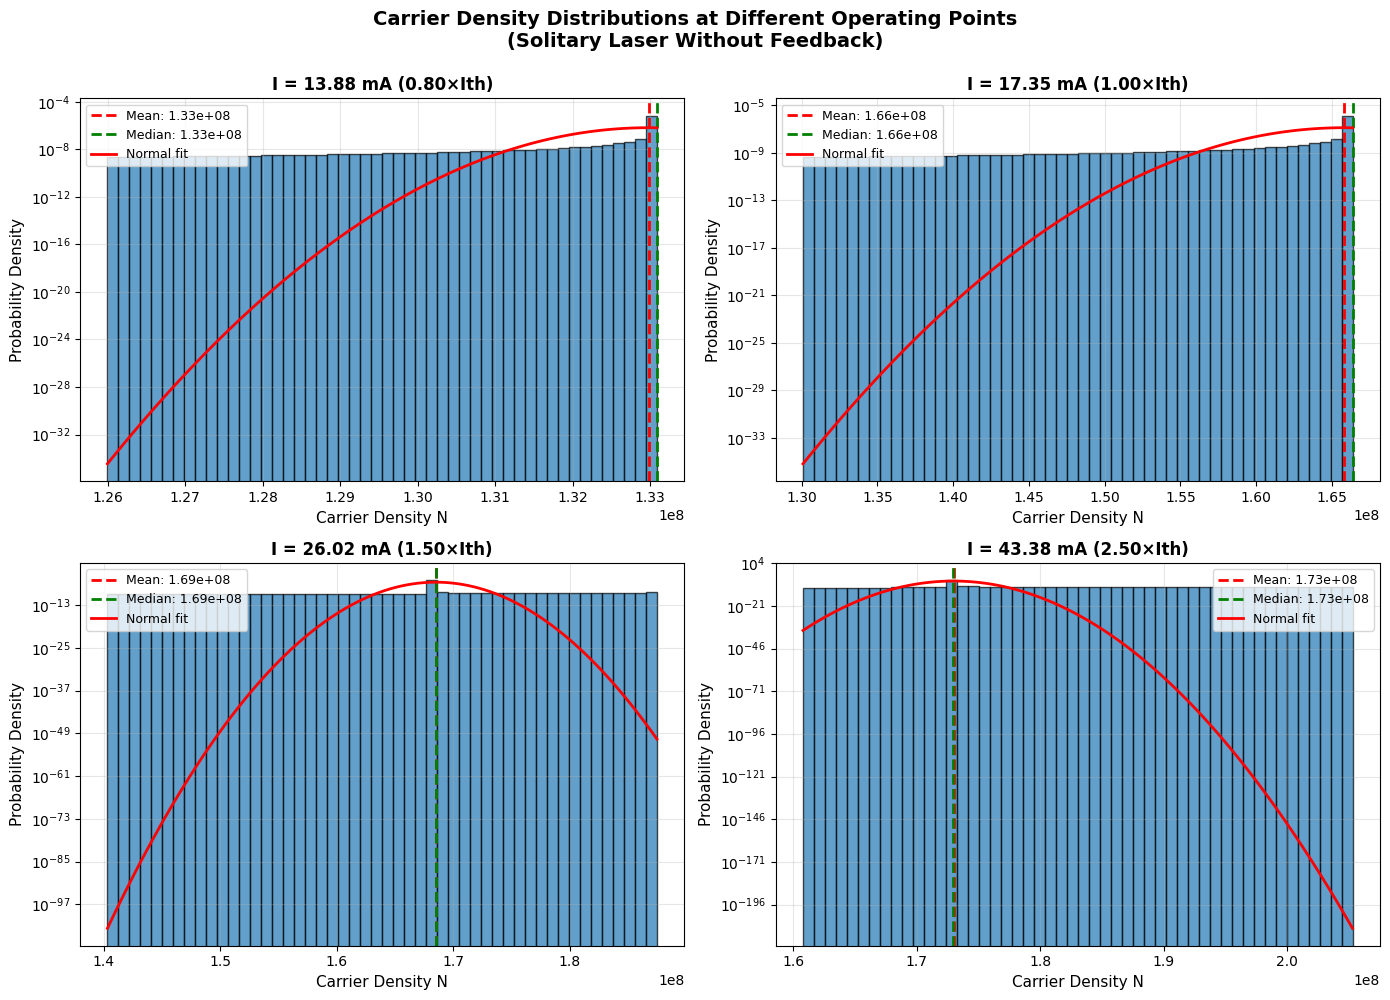

Saved: results/carrier_density_distributions_no_fb.png


In [18]:
# Generate carrier density distribution plots
print("\nGenerating carrier density distribution plots...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, I_val in enumerate(I_selected):
    data = time_series_data_no_fb[I_val]
    N_samples = data['N']
    
    axes[idx].hist(N_samples, bins=50, density=True, alpha=0.7, edgecolor='black')
    axes[idx].axvline(np.mean(N_samples), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(N_samples):.2e}')
    axes[idx].axvline(np.median(N_samples), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(N_samples):.2e}')
    
    # Fit normal distribution if enough points
    if len(N_samples) > 10:
        mu, sigma = np.mean(N_samples), np.std(N_samples)
        x_fit = np.linspace(N_samples.min(), N_samples.max(), 100)
        y_fit = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_fit - mu) / sigma)**2)
        axes[idx].plot(x_fit, y_fit, 'r-', linewidth=2, label='Normal fit')
    
    axes[idx].set_xlabel('Carrier Density N', fontsize=11)
    axes[idx].set_ylabel('Probability Density', fontsize=11)
    axes[idx].set_title(f'I = {I_val*1e3:.2f} mA ({I_val/I_th:.2f}×Ith)', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_yscale('log')

plt.suptitle('Carrier Density Distributions at Different Operating Points\n(Solitary Laser Without Feedback)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('results/carrier_density_distributions_no_fb.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: results/carrier_density_distributions_no_fb.png")



Generating phase space plots...


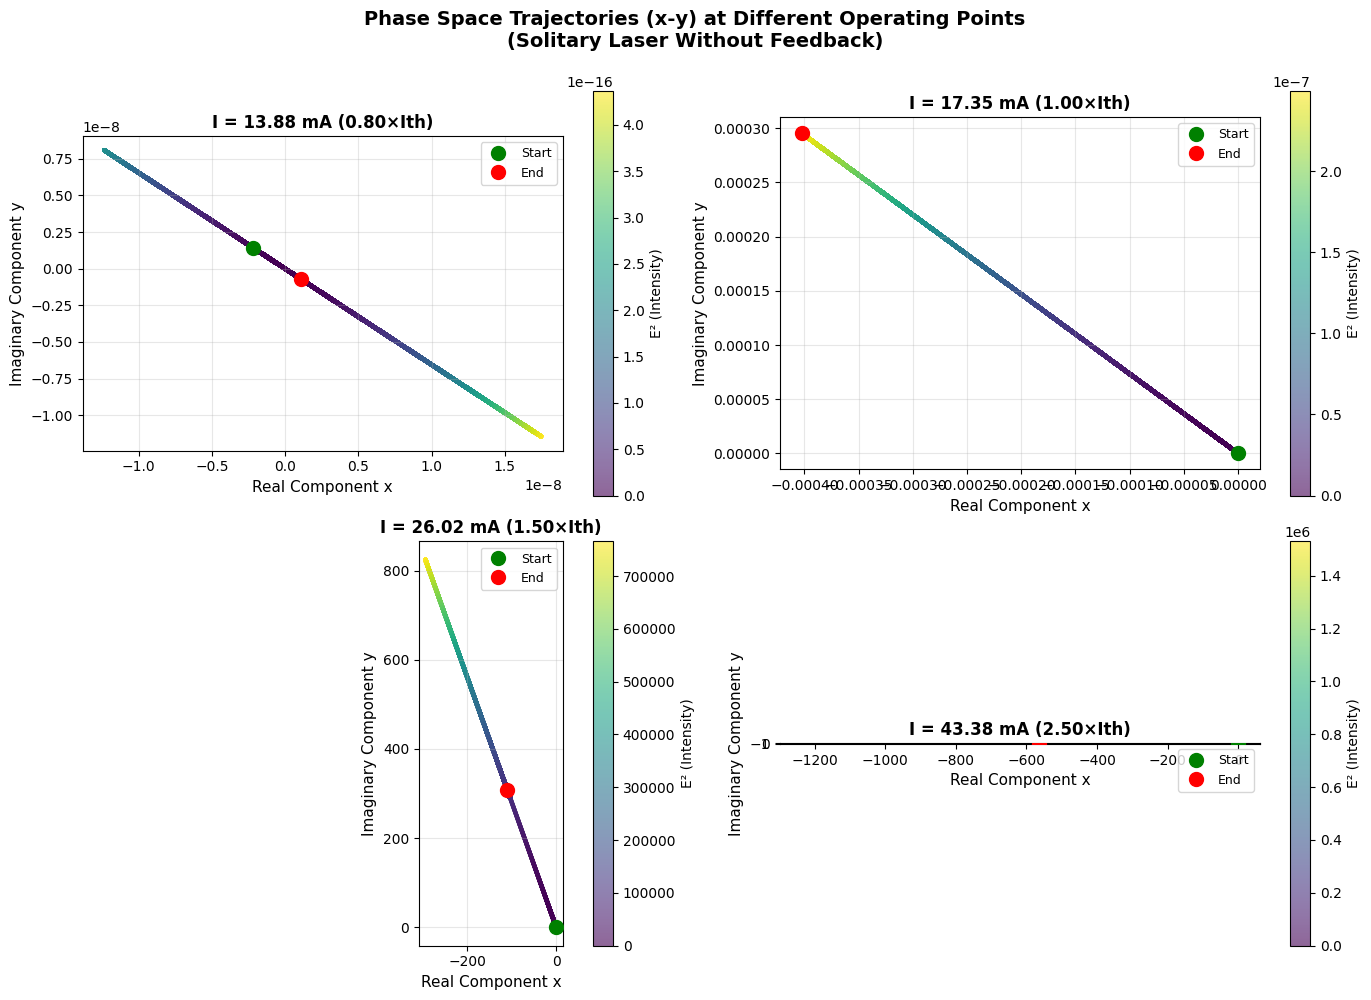

Saved: results/phase_space_xy_no_fb.png


In [19]:
# Generate phase space plots (x-y trajectories)
print("\nGenerating phase space plots...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, I_val in enumerate(I_selected):
    data = time_series_data_no_fb[I_val]
    x_vals = data['x']
    y_vals = data['y']
    E2_vals = data['E2']
    
    # Use E2 for color coding
    scatter = axes[idx].scatter(x_vals, y_vals, c=E2_vals, cmap='viridis', 
                                s=10, alpha=0.6, edgecolors='none')
    axes[idx].plot(x_vals[0], y_vals[0], 'go', markersize=10, label='Start', zorder=5)
    axes[idx].plot(x_vals[-1], y_vals[-1], 'ro', markersize=10, label='End', zorder=5)
    
    cbar = plt.colorbar(scatter, ax=axes[idx])
    cbar.set_label('E² (Intensity)', fontsize=10)
    
    axes[idx].set_xlabel('Real Component x', fontsize=11)
    axes[idx].set_ylabel('Imaginary Component y', fontsize=11)
    axes[idx].set_title(f'I = {I_val*1e3:.2f} mA ({I_val/I_th:.2f}×Ith)', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_aspect('equal', adjustable='box')

plt.suptitle('Phase Space Trajectories (x-y) at Different Operating Points\n(Solitary Laser Without Feedback)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('results/phase_space_xy_no_fb.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: results/phase_space_xy_no_fb.png")



Generating Power Spectral Density plots...


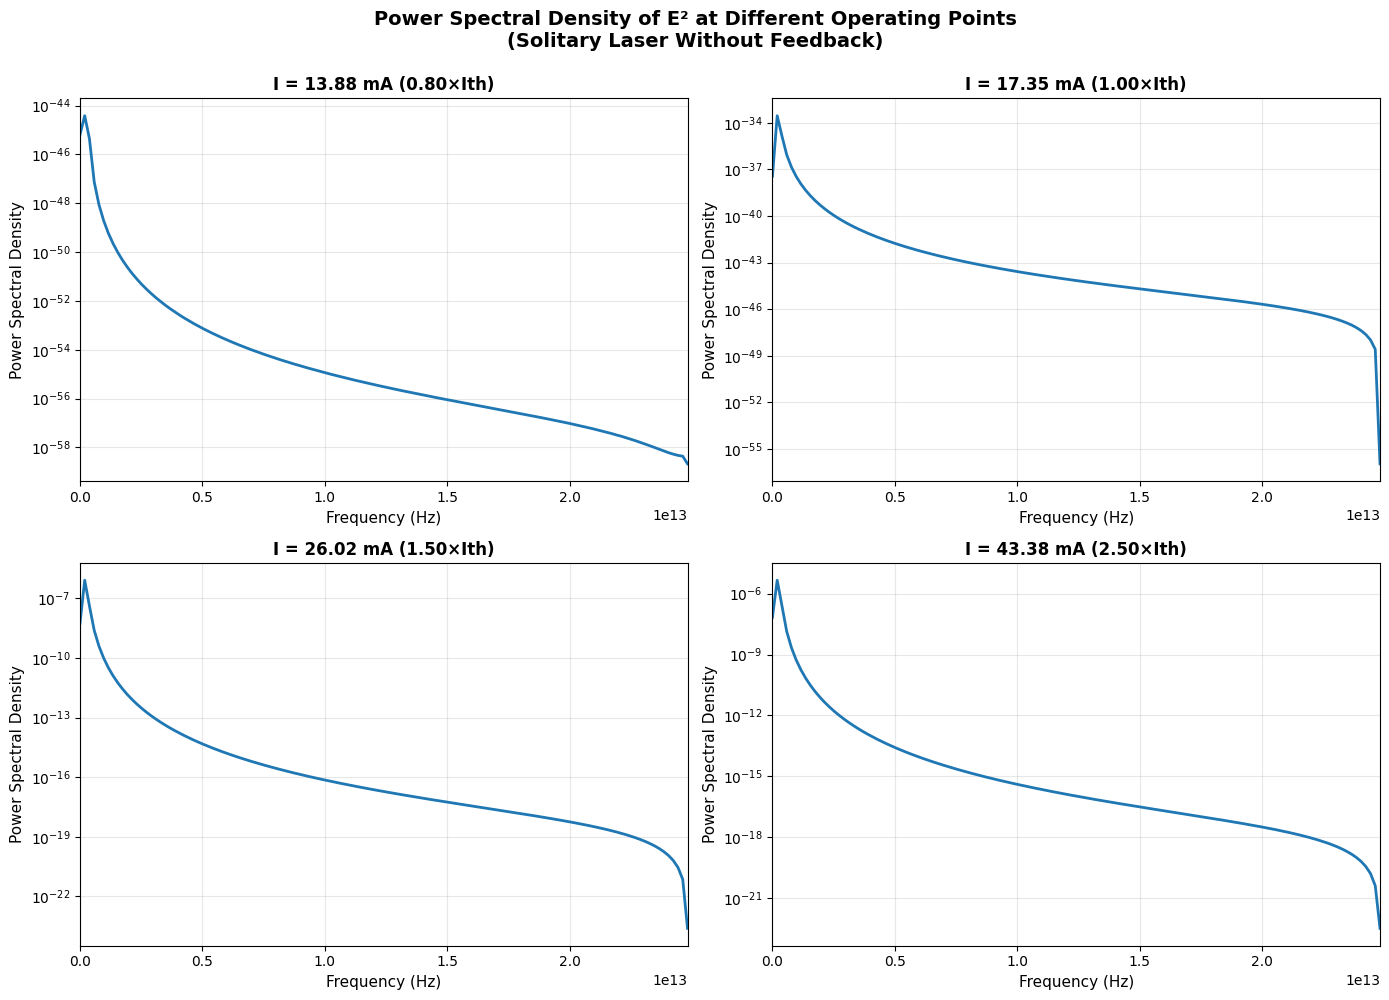

Saved: results/psd_no_fb.png


In [20]:
# Generate Power Spectral Density (PSD) plots
print("\nGenerating Power Spectral Density plots...")

from scipy import signal

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, I_val in enumerate(I_selected):
    data = time_series_data_no_fb[I_val]
    time_vals = data['time']
    E2_vals = data['E2']
    
    # Compute PSD using Welch's method
    dt_sample = np.mean(np.diff(time_vals))
    fs = 1.0 / dt_sample  # Sampling frequency
    
    freqs, psd = signal.welch(E2_vals, fs, nperseg=min(256, len(E2_vals)//4))
    
    axes[idx].semilogy(freqs, psd, linewidth=2)
    axes[idx].set_xlabel('Frequency (Hz)', fontsize=11)
    axes[idx].set_ylabel('Power Spectral Density', fontsize=11)
    axes[idx].set_title(f'I = {I_val*1e3:.2f} mA ({I_val/I_th:.2f}×Ith)', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim([0, freqs.max()])

plt.suptitle('Power Spectral Density of E² at Different Operating Points\n(Solitary Laser Without Feedback)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('results/psd_no_fb.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: results/psd_no_fb.png")



Generating time series plots...


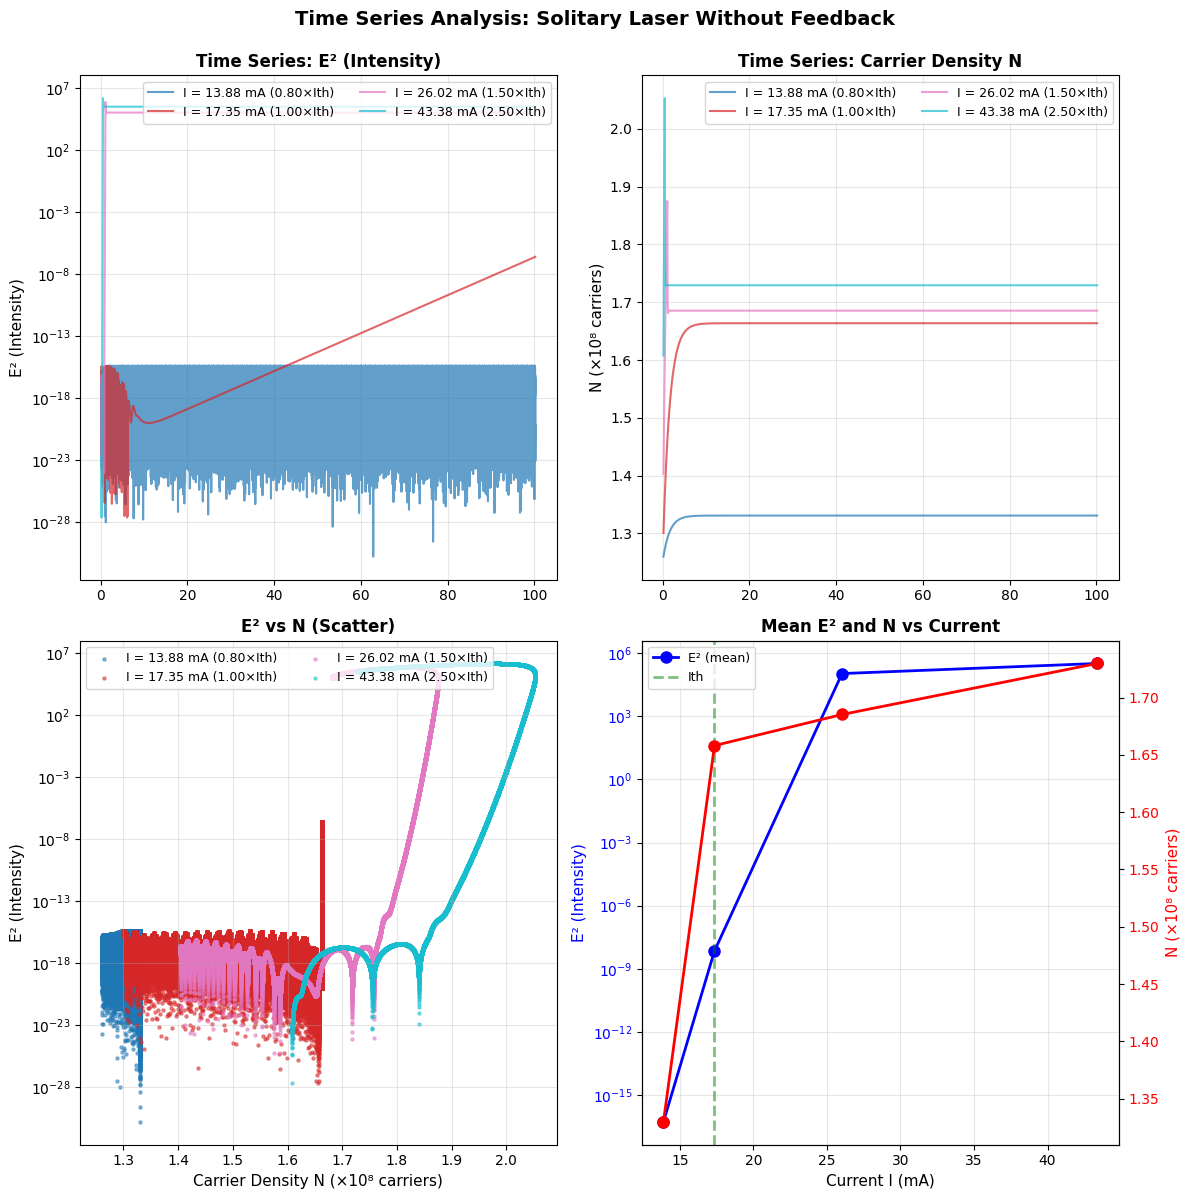

Saved: results/time_series_analysis_no_fb.png


In [40]:
# Generate time series plots for E² and N
print("\nGenerating time series plots...")

# Create 2x2 grid for square images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
colors = plt.cm.tab10(np.linspace(0, 1, len(I_selected)))

for idx, I_val in enumerate(I_selected):
    data = time_series_data_no_fb[I_val]
    time_vals = data['time'] * 1e9  # Convert to ns for readability
    E2_vals = data['E2']
    N_vals = data['N']
    
    # Plot E² (top left)
    axes[0, 0].plot(time_vals, E2_vals, color=colors[idx], linewidth=1.5, 
                 alpha=0.7, label=f'I = {I_val*1e3:.2f} mA ({I_val/I_th:.2f}×Ith)')
    
    # Plot N (top right)
    axes[0, 1].plot(time_vals, N_vals / 1e8, color=colors[idx], linewidth=1.5, 
                 alpha=0.7, label=f'I = {I_val*1e3:.2f} mA ({I_val/I_th:.2f}×Ith)')

# Format E² plot (top left)
axes[0, 0].set_ylabel('E² (Intensity)', fontsize=11)
axes[0, 0].set_title('Time Series: E² (Intensity)', fontsize=12, fontweight='bold')
axes[0, 0].legend(loc='upper right', fontsize=9, ncol=2)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# Format N plot (top right)
axes[0, 1].set_ylabel('N (×10⁸ carriers)', fontsize=11)
axes[0, 1].set_title('Time Series: Carrier Density N', fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='upper right', fontsize=9, ncol=2)
axes[0, 1].grid(True, alpha=0.3)

# E² vs N scatter for each I (bottom left)
for idx, I_val in enumerate(I_selected):
    data = time_series_data_no_fb[I_val]
    N_vals = data['N'] / 1e8
    E2_vals = data['E2']
    axes[1, 0].scatter(N_vals, E2_vals, color=colors[idx], s=5, alpha=0.5, 
                    label=f'I = {I_val*1e3:.2f} mA ({I_val/I_th:.2f}×Ith)')

axes[1, 0].set_xlabel('Carrier Density N (×10⁸ carriers)', fontsize=11)
axes[1, 0].set_ylabel('E² (Intensity)', fontsize=11)
axes[1, 0].set_title('E² vs N (Scatter)', fontsize=12, fontweight='bold')
axes[1, 0].legend(loc='upper left', fontsize=9, ncol=2)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_yscale('log')

# Combined comparison plot showing mean values (bottom right)
I_array = np.array(I_selected)
E2_means = [np.mean(time_series_data_no_fb[I]['E2']) for I in I_selected]
N_means = [np.mean(time_series_data_no_fb[I]['N']) / 1e8 for I in I_selected]

ax2_twin = axes[1, 1]
ax2_twin.plot(I_array * 1e3, E2_means, 'bo-', linewidth=2, markersize=8, label='E² (mean)')
ax2_twin.set_xlabel('Current I (mA)', fontsize=11)
ax2_twin.set_ylabel('E² (Intensity)', fontsize=11, color='blue')
ax2_twin.tick_params(axis='y', labelcolor='blue')
ax2_twin.set_yscale('log')

ax3_twin = axes[1, 1].twinx()
ax3_twin.plot(I_array * 1e3, N_means, 'ro-', linewidth=2, markersize=8, label='N (mean)')
ax3_twin.set_ylabel('N (×10⁸ carriers)', fontsize=11, color='red')
ax3_twin.tick_params(axis='y', labelcolor='red')

axes[1, 1].axvline(I_th * 1e3, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Ith')
axes[1, 1].set_title('Mean E² and N vs Current', fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='upper left', fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Time Series Analysis: Solitary Laser Without Feedback', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('results/time_series_analysis_no_fb.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: results/time_series_analysis_no_fb.png")


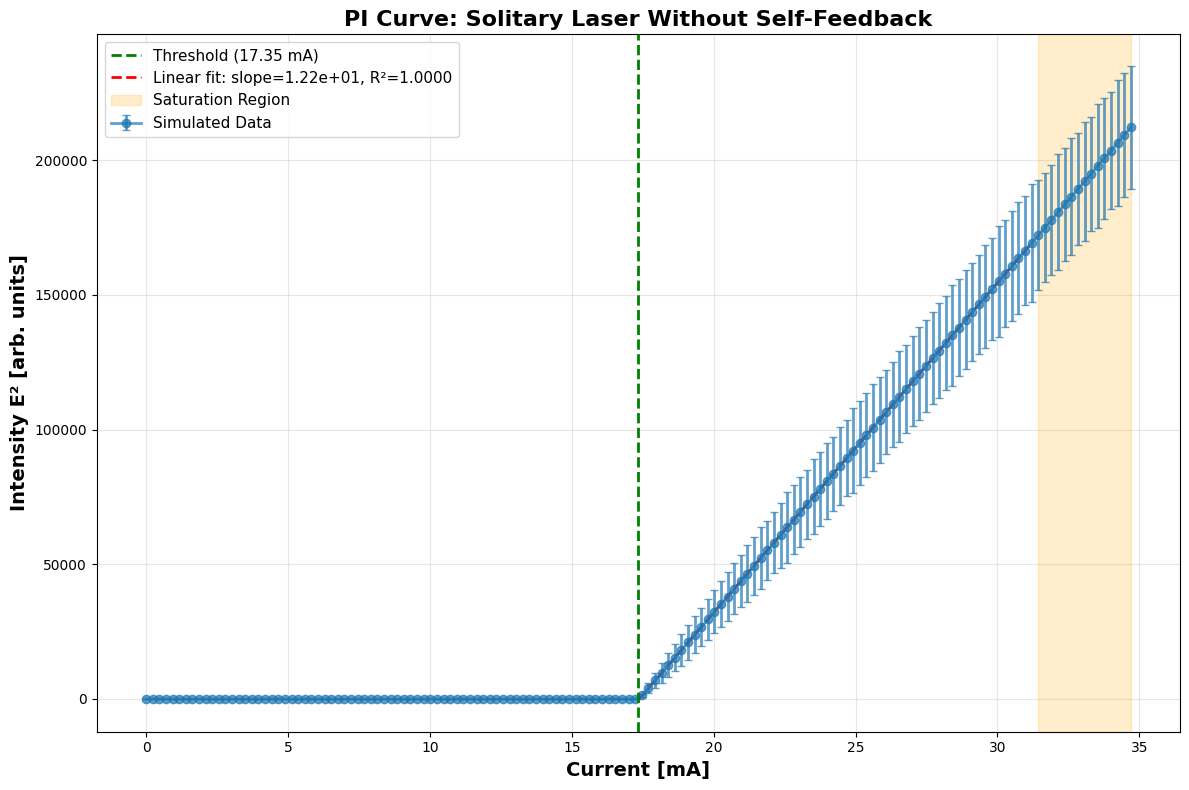

Slope efficiency (no feedback): 1.22e+01 (R² = 1.0000)


In [22]:
# Plot PI curve
slope_eff_no_fb, r2_no_fb = plot_pi_curve(I_sweep, E2_mean_no_fb, E2_std=E2_std_no_fb, 
                                          Ith=I_th,
                                          title="PI Curve: Solitary Laser Without Self-Feedback",
                                          filename="results/solitary_no_feedback_pi_curve.png")
if slope_eff_no_fb is not None:
    print(f"Slope efficiency (no feedback): {slope_eff_no_fb*1e-6:.2e} (R² = {r2_no_fb:.4f})")


### Plot E² vs N


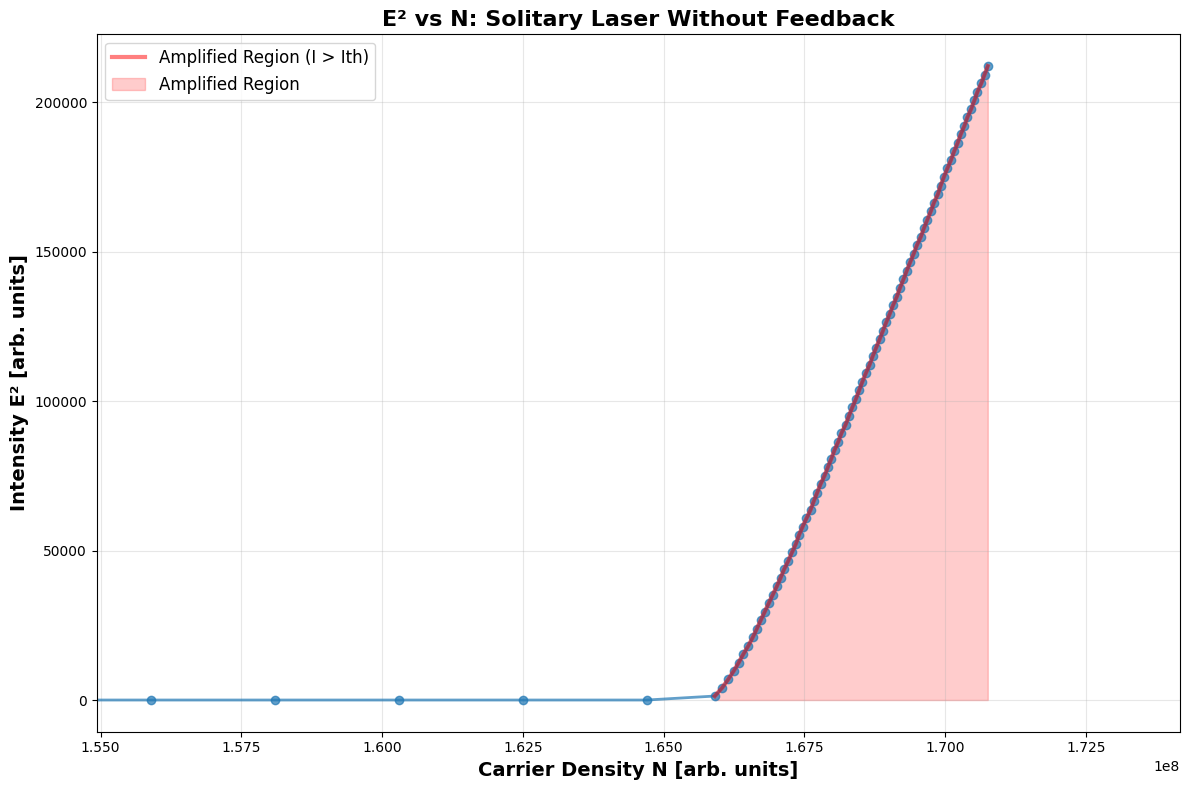

In [23]:
plot_intensity_vs_carrier(N_mean_no_fb, E2_mean_no_fb, I_sweep, Ith=I_th,
                          scatter=False, title="E² vs N: Solitary Laser Without Feedback",
                          filename="results/solitary_no_feedback_E2_vs_N.png")


### Plot Log(E²) vs Log(N)


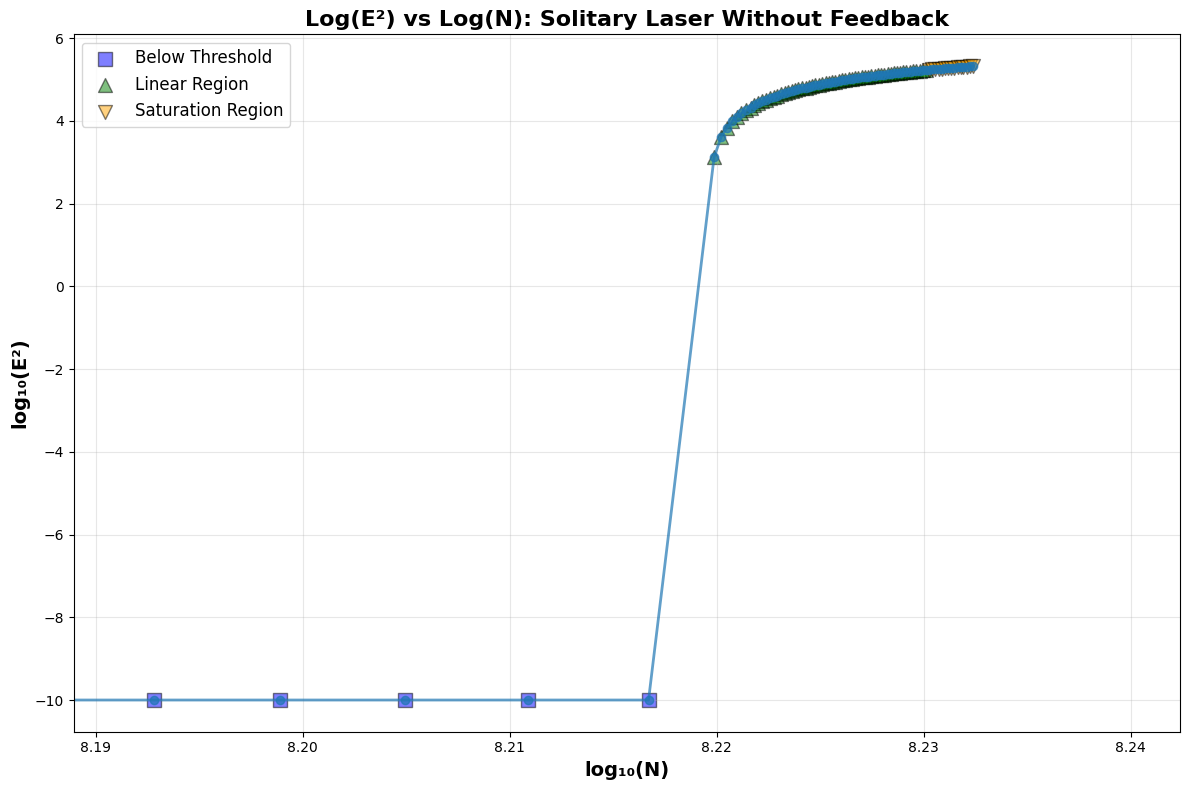

In [24]:
plot_log_intensity_vs_log_carrier(N_mean_no_fb, E2_mean_no_fb, I_sweep, Ith=I_th,
                                   title="Log(E²) vs Log(N): Solitary Laser Without Feedback",
                                   filename="results/solitary_no_feedback_log_E2_vs_log_N.png")


### Plot Voltage-Current (V-I) Characteristics


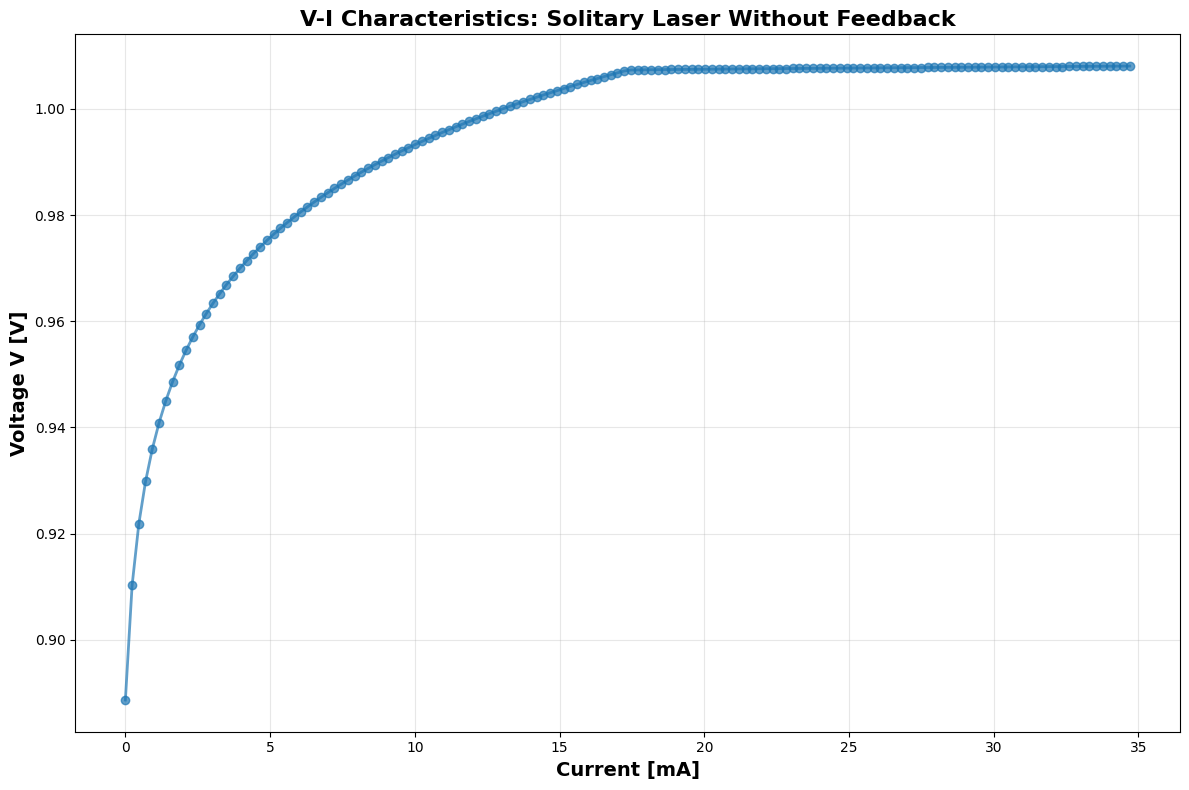

In [25]:
# Compute voltage from carrier density
V_mean_no_fb = compute_voltage_from_carrier(N_mean_no_fb)

# For oscillatory cases, we could store V_samples, but for no-feedback case,
# we just plot the mean
plot_voltage_current(I_sweep, V_mean_no_fb, V_samples=None,
                     title="V-I Characteristics: Solitary Laser Without Feedback",
                     filename="results/solitary_no_feedback_V_I.png")


## Section 2: Solitary Laser With Self-Feedback

### Parameter Sweep Strategy

We fix two parameters and sweep one at a time to avoid parameter explosion.


In [26]:
# Feedback parameter sweep
# Fix tau_f and phi_f, sweep kf
kf_values = [0.0, 0.1, 0.5]  # Include 0 for comparison (reduced from 8 to save memory)
tau_f_fixed = 10e-9  # 10 ns
phi_f_fixed = 0.0  # 0 rad

# Current sweep (reduced from 50 to 30 points to save memory)
I_sweep_fb = np.linspace(I_start, I_end, 30)

# Storage for different kf values
results_fb = {}

print("Running PI curve sweep with feedback (varying kf)...")
for kf in kf_values:
    print(f"\n  kf = {kf}")
    E2_mean_fb = []
    E2_std_fb = []
    N_mean_fb = []
    
    for I in tqdm(I_sweep_fb, leave=False):
        if kf == 0.0:
            # Use ODE solver for kf=0 (no feedback)
            time, E2, N = simulate_solitary_laser_no_feedback(I, T_trans, T_sample, dt_ode)
        else:
            # Use DDE solver for kf > 0
            time, E2, N = simulate_solitary_laser_with_feedback(
                I, kf, tau_f_fixed, phi_f_fixed, T_trans, T_sample, dt_dde)
        
        E2_mean_fb.append(np.mean(E2))
        E2_std_fb.append(np.std(E2))
        N_mean_fb.append(np.mean(N))
    
    results_fb[kf] = { 
        'E2_mean': np.array(E2_mean_fb),
        'E2_std': np.array(E2_std_fb),
        'N_mean': np.array(N_mean_fb)
    }

print("\nFeedback sweep completed!")


Running PI curve sweep with feedback (varying kf)...

  kf = 0.0



  kf = 0.1


  0%|          | 0/30 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde__abca3dj/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde__abca3dj/jitced_1.o': found architecture 'arm64', required architecture 'x86_64'
  3%|▎         | 1/30 [00:00<00:22,  1.31it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_3j9u7lve/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_3j9u7lve/jitced_2.o': found architecture 'arm64', required architecture 'x86_64'
  7%|▋         | 2/30 [00:01<00:16,  1.67it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_p7m6_za3/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_p7m6_za3/jitced_3.o': found architecture 'arm64', required architecture 'x86_64'
 10%|█         | 3/30 [00:01<00:14,  1.83it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_jd95bi1l/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_jd95bi1l/jitced_4.o': found architecture 'arm64', required architecture 'x86_64'
 13%|█▎        | 4/30 [00:02<00:13,  1.95it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_e9piz4pz/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_e9piz4pz/jitced_5.o': found architecture 'arm64', required architecture 'x86_64'
 17%|█▋        | 5/30 [00:02<00:12,  1.99it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_h92ri89l/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_h92ri89l/jitced_6.o': found architecture 'arm64', required architecture 'x86_64'
 20%|██        | 6/30 [00:03<00:11,  2.03it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_pusw5xhz/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_pusw5xhz/jitced_7.o': found architecture 'arm64', required architecture 'x86_64'
 23%|██▎       | 7/30 [00:03<00:11,  2.05it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ndbje8kg/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ndbje8kg/jitced_8.o': found architecture 'arm64', required architecture 'x86_64'
 27%|██▋       | 8/30 [00:04<00:12,  1.75it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_50y_r7qi/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_50y_r7qi/jitced_9.o': found architecture 'arm64', required architecture 'x86_64'
 30%|███       | 9/30 [00:04<00:11,  1.80it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_4982xs7n/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_4982xs7n/jitced_10.o': found architecture 'arm64', required architecture 'x86_64'
 33%|███▎      | 10/30 [00:05<00:10,  1.86it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_7kl5i8ne/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_7kl5i8ne/jitced_11.o': found architecture 'arm64', required architecture 'x86_64'
 37%|███▋      | 11/30 [00:05<00:10,  1.86it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_j5g7rz6e/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_j5g7rz6e/jitced_12.o': found architecture 'arm64', required architecture 'x86_64'
 40%|████      | 12/30 [00:06<00:09,  1.85it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_n7yxn98x/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_n7yxn98x/jitced_13.o': found architecture 'arm64', required architecture 'x86_64'
 43%|████▎     | 13/30 [00:06<00:08,  1.92it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_6icjoxm8/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_6icjoxm8/jitced_14.o': found architecture 'arm64', required architecture 'x86_64'
 47%|████▋     | 14/30 [00:07<00:08,  1.89it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_02qgxm_1/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_02qgxm_1/jitced_15.o': found architecture 'arm64', required architecture 'x86_64'
 50%|█████     | 15/30 [00:08<00:07,  1.92it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_n8pd2obs/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_n8pd2obs/jitced_16.o': found architecture 'arm64', required architecture 'x86_64'
 53%|█████▎    | 16/30 [00:08<00:07,  1.91it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_9ihdkds9/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_9ihdkds9/jitced_17.o': found architecture 'arm64', required architecture 'x86_64'
 57%|█████▋    | 17/30 [00:09<00:06,  1.92it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_wovtdyh4/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_wovtdyh4/jitced_18.o': found architecture 'arm64', required architecture 'x86_64'
 60%|██████    | 18/30 [00:09<00:06,  1.94it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_47iqfdn4/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_47iqfdn4/jitced_19.o': found architecture 'arm64', required architecture 'x86_64'
 63%|██████▎   | 19/30 [00:10<00:05,  2.01it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ld8dugtx/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ld8dugtx/jitced_20.o': found architecture 'arm64', required architecture 'x86_64'
 67%|██████▋   | 20/30 [00:10<00:04,  2.06it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_76o_a3cs/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_76o_a3cs/jitced_21.o': found architecture 'arm64', required architecture 'x86_64'
 70%|███████   | 21/30 [00:10<00:04,  2.08it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_0ho51hie/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_0ho51hie/jitced_22.o': found architecture 'arm64', required architecture 'x86_64'
 73%|███████▎  | 22/30 [00:11<00:03,  2.07it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_kfusyoyf/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_kfusyoyf/jitced_23.o': found architecture 'arm64', required architecture 'x86_64'
 77%|███████▋  | 23/30 [00:11<00:03,  2.08it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_et6ug8p3/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_et6ug8p3/jitced_24.o': found architecture 'arm64', required architecture 'x86_64'
 80%|████████  | 24/30 [00:12<00:02,  2.11it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_n9n8srg4/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_n9n8srg4/jitced_25.o': found architecture 'arm64', required architecture 'x86_64'
 83%|████████▎ | 25/30 [00:12<00:02,  2.16it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_mfj3u4xl/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_mfj3u4xl/jitced_26.o': found architecture 'arm64', required architecture 'x86_64'
 87%|████████▋ | 26/30 [00:13<00:01,  2.18it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_7ak713fy/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_7ak713fy/jitced_27.o': found architecture 'arm64', required architecture 'x86_64'
 90%|█████████ | 27/30 [00:13<00:01,  2.08it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_u7hi7l0t/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_u7hi7l0t/jitced_28.o': found architecture 'arm64', required architecture 'x86_64'
 93%|█████████▎| 28/30 [00:14<00:00,  2.11it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_a8ek_2nz/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_a8ek_2nz/jitced_29.o': found architecture 'arm64', required architecture 'x86_64'
 97%|█████████▋| 29/30 [00:14<00:00,  2.12it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_on83bnrs/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_on83bnrs/jitced_30.o': found architecture 'arm64', required architecture 'x86_64'



  kf = 0.5


  0%|          | 0/30 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_8mh7c96m/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_8mh7c96m/jitced_31.o': found architecture 'arm64', required architecture 'x86_64'
  3%|▎         | 1/30 [00:00<00:14,  2.00it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_bztban80/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_bztban80/jitced_32.o': found architecture 'arm64', required architecture 'x86_64'
  7%|▋         | 2/30 [00:00<00:13,  2.06it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_c_m5c0ja/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_c_m5c0ja/jitced_33.o': found architecture 'arm64', required architecture 'x86_64'
 10%|█         | 3/30 [00:01<00:12,  2.10it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_bta88kft/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_bta88kft/jitced_34.o': found architecture 'arm64', required architecture 'x86_64'
 13%|█▎        | 4/30 [00:01<00:12,  2.13it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_6avxybe6/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_6avxybe6/jitced_35.o': found architecture 'arm64', required architecture 'x86_64'
 17%|█▋        | 5/30 [00:02<00:11,  2.14it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_jgq1wg8s/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_jgq1wg8s/jitced_36.o': found architecture 'arm64', required architecture 'x86_64'
 20%|██        | 6/30 [00:02<00:11,  2.15it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_bh94pu67/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_bh94pu67/jitced_37.o': found architecture 'arm64', required architecture 'x86_64'
 23%|██▎       | 7/30 [00:03<00:10,  2.16it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_bwswa53v/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_bwswa53v/jitced_38.o': found architecture 'arm64', required architecture 'x86_64'
 27%|██▋       | 8/30 [00:03<00:10,  2.14it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ee7a2__u/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ee7a2__u/jitced_39.o': found architecture 'arm64', required architecture 'x86_64'
 30%|███       | 9/30 [00:04<00:09,  2.15it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ae3rz3j_/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ae3rz3j_/jitced_40.o': found architecture 'arm64', required architecture 'x86_64'
 33%|███▎      | 10/30 [00:04<00:09,  2.13it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_pvpnl3_0/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_pvpnl3_0/jitced_41.o': found architecture 'arm64', required architecture 'x86_64'
 37%|███▋      | 11/30 [00:05<00:08,  2.15it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde__u9zv0l8/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde__u9zv0l8/jitced_42.o': found architecture 'arm64', required architecture 'x86_64'
 40%|████      | 12/30 [00:05<00:08,  2.17it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_507y_4dw/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_507y_4dw/jitced_43.o': found architecture 'arm64', required architecture 'x86_64'
 43%|████▎     | 13/30 [00:06<00:07,  2.19it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde__dot6122/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde__dot6122/jitced_44.o': found architecture 'arm64', required architecture 'x86_64'
 47%|████▋     | 14/30 [00:06<00:07,  2.20it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_82y93ob3/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_82y93ob3/jitced_45.o': found architecture 'arm64', required architecture 'x86_64'
 50%|█████     | 15/30 [00:06<00:06,  2.22it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_2q5sr156/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_2q5sr156/jitced_46.o': found architecture 'arm64', required architecture 'x86_64'
 53%|█████▎    | 16/30 [00:07<00:06,  2.22it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_s19vq9uz/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_s19vq9uz/jitced_47.o': found architecture 'arm64', required architecture 'x86_64'
 57%|█████▋    | 17/30 [00:07<00:05,  2.23it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_dq3pclzq/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_dq3pclzq/jitced_48.o': found architecture 'arm64', required architecture 'x86_64'
 60%|██████    | 18/30 [00:08<00:05,  2.24it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_a0xmc7z8/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_a0xmc7z8/jitced_49.o': found architecture 'arm64', required architecture 'x86_64'
 63%|██████▎   | 19/30 [00:08<00:04,  2.24it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_i_aqsjbc/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_i_aqsjbc/jitced_50.o': found architecture 'arm64', required architecture 'x86_64'
 67%|██████▋   | 20/30 [00:09<00:04,  2.23it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_df0_aa09/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_df0_aa09/jitced_51.o': found architecture 'arm64', required architecture 'x86_64'
 70%|███████   | 21/30 [00:09<00:04,  2.23it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_nsy_rkco/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_nsy_rkco/jitced_52.o': found architecture 'arm64', required architecture 'x86_64'
 73%|███████▎  | 22/30 [00:10<00:03,  2.22it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_fm_hp_2b/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_fm_hp_2b/jitced_53.o': found architecture 'arm64', required architecture 'x86_64'
 77%|███████▋  | 23/30 [00:10<00:03,  2.22it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_2stpgh0m/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_2stpgh0m/jitced_54.o': found architecture 'arm64', required architecture 'x86_64'
 80%|████████  | 24/30 [00:11<00:02,  2.19it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_omueevmy/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_omueevmy/jitced_55.o': found architecture 'arm64', required architecture 'x86_64'
 83%|████████▎ | 25/30 [00:11<00:02,  2.17it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_7imp8idg/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_7imp8idg/jitced_56.o': found architecture 'arm64', required architecture 'x86_64'
 87%|████████▋ | 26/30 [00:11<00:01,  2.19it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_mf5uu9ne/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_mf5uu9ne/jitced_57.o': found architecture 'arm64', required architecture 'x86_64'
 90%|█████████ | 27/30 [00:12<00:01,  2.21it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_557p21dm/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_557p21dm/jitced_58.o': found architecture 'arm64', required architecture 'x86_64'
 93%|█████████▎| 28/30 [00:12<00:00,  2.20it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_mnavc60p/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_mnavc60p/jitced_59.o': found architecture 'arm64', required architecture 'x86_64'
 97%|█████████▋| 29/30 [00:13<00:00,  2.20it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_b6qcdvtd/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_b6qcdvtd/jitced_60.o': found architecture 'arm64', required architecture 'x86_64'
                                               


Feedback sweep completed!


### Plot PI Curves with Feedback (Comparison)


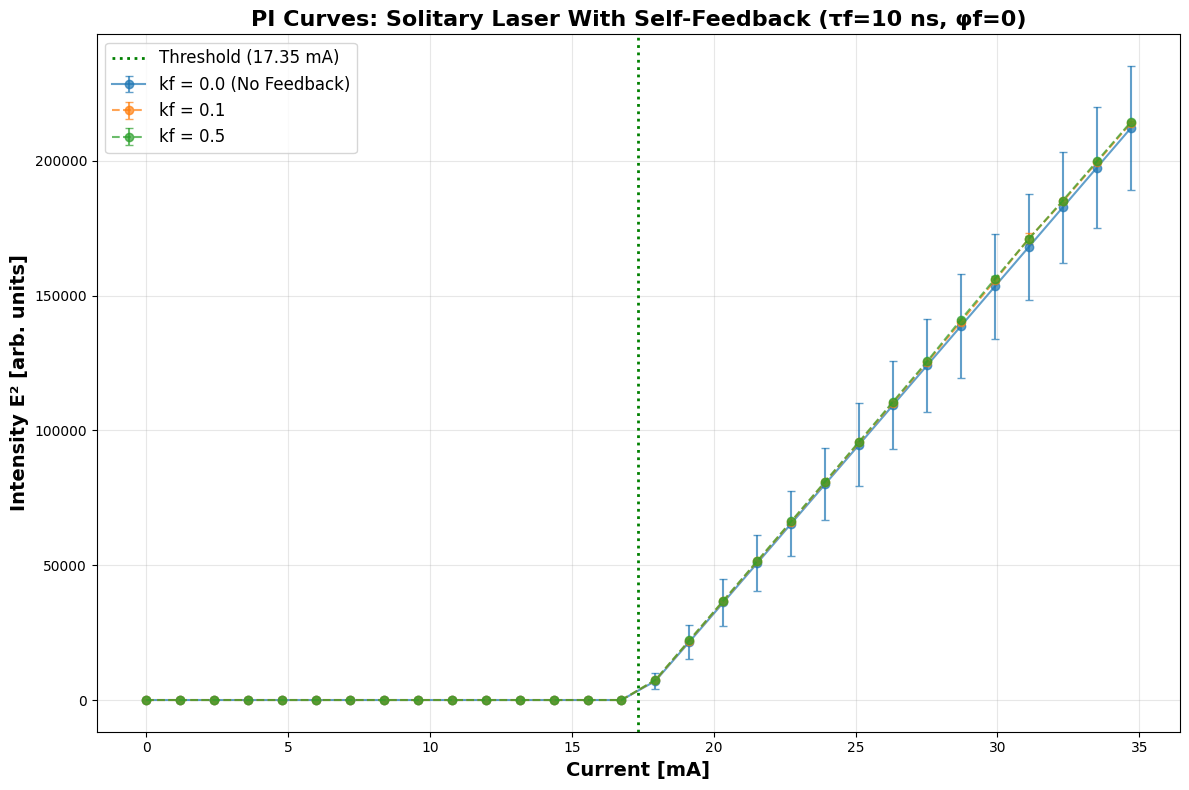

In [27]:
plt.figure(figsize=(12, 8))

for kf in kf_values:
    data = results_fb[kf]
    I_mA = I_sweep_fb * 1e3
    
    if kf == 0.0:
        label = f'kf = {kf} (No Feedback)'
        linestyle = '-'
    else:
        label = f'kf = {kf}'
        linestyle = '--'
    
    plt.errorbar(I_mA, data['E2_mean'], yerr=data['E2_std'], 
                fmt='o', capsize=3, label=label, linestyle=linestyle, alpha=0.7)

plt.axvline(I_th*1e3, color='g', linestyle=':', linewidth=2, 
           label=f'Threshold ({I_th*1e3:.2f} mA)')

plt.xlabel('Current [mA]', fontsize=14, fontweight='bold')
plt.ylabel('Intensity E² [arb. units]', fontsize=14, fontweight='bold')
plt.title('PI Curves: Solitary Laser With Self-Feedback (τf=10 ns, φf=0)', 
         fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('results/solitary_with_feedback_pi_curves.png', dpi=300, bbox_inches='tight')
plt.show()


### Plot E² vs N with Feedback


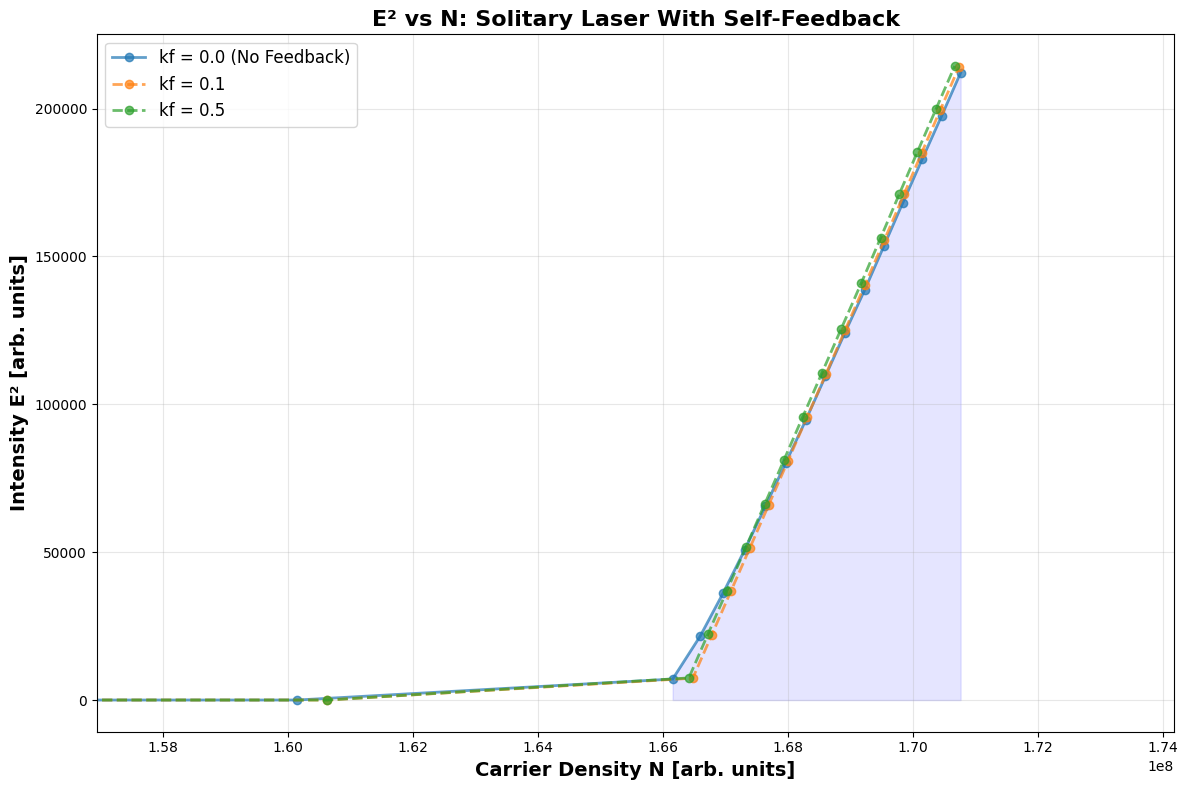

In [28]:
plt.figure(figsize=(12, 8))

for kf in kf_values:
    data = results_fb[kf]
    
    if kf == 0.0:
        label = f'kf = {kf} (No Feedback)'
        linestyle = '-'
        linewidth = 2
    else:
        label = f'kf = {kf}'
        linestyle = '--'
        linewidth = 2
    
    plt.plot(data['N_mean'], data['E2_mean'], 'o-', 
            label=label, linestyle=linestyle, linewidth=linewidth, 
            markersize=6, alpha=0.7)

# Highlight amplified region
mask_amp = I_sweep_fb > I_th
if np.any(mask_amp):
    for kf in kf_values:
        data = results_fb[kf]
        N_amp = data['N_mean'][mask_amp]
        E2_amp = data['E2_mean'][mask_amp]
        if kf == 0.0:
            plt.fill_between(N_amp, 0, E2_amp, alpha=0.1, color='blue')

# Set x-axis limits to focus on interesting region (around threshold)
mask_interesting = I_sweep_fb >= I_th * 0.95
if np.any(mask_interesting):
    # Collect all N values in the interesting region across all kf values
    N_interesting_all = []
    for kf in kf_values:
        data = results_fb[kf]
        N_interesting = data['N_mean'][mask_interesting]
        N_interesting_all.extend(N_interesting)
    
    if len(N_interesting_all) > 0:
        N_min = np.min(N_interesting_all) * 0.98  # 2% margin on left
        N_max = np.max(N_interesting_all) * 1.02  # 2% margin on right
        plt.xlim(N_min, N_max)

plt.xlabel('Carrier Density N [arb. units]', fontsize=14, fontweight='bold')
plt.ylabel('Intensity E² [arb. units]', fontsize=14, fontweight='bold')
plt.title('E² vs N: Solitary Laser With Self-Feedback', 
         fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('results/solitary_with_feedback_E2_vs_N.png', dpi=300, bbox_inches='tight')
plt.show()


### Plot Log(E²) vs Log(N) with Feedback


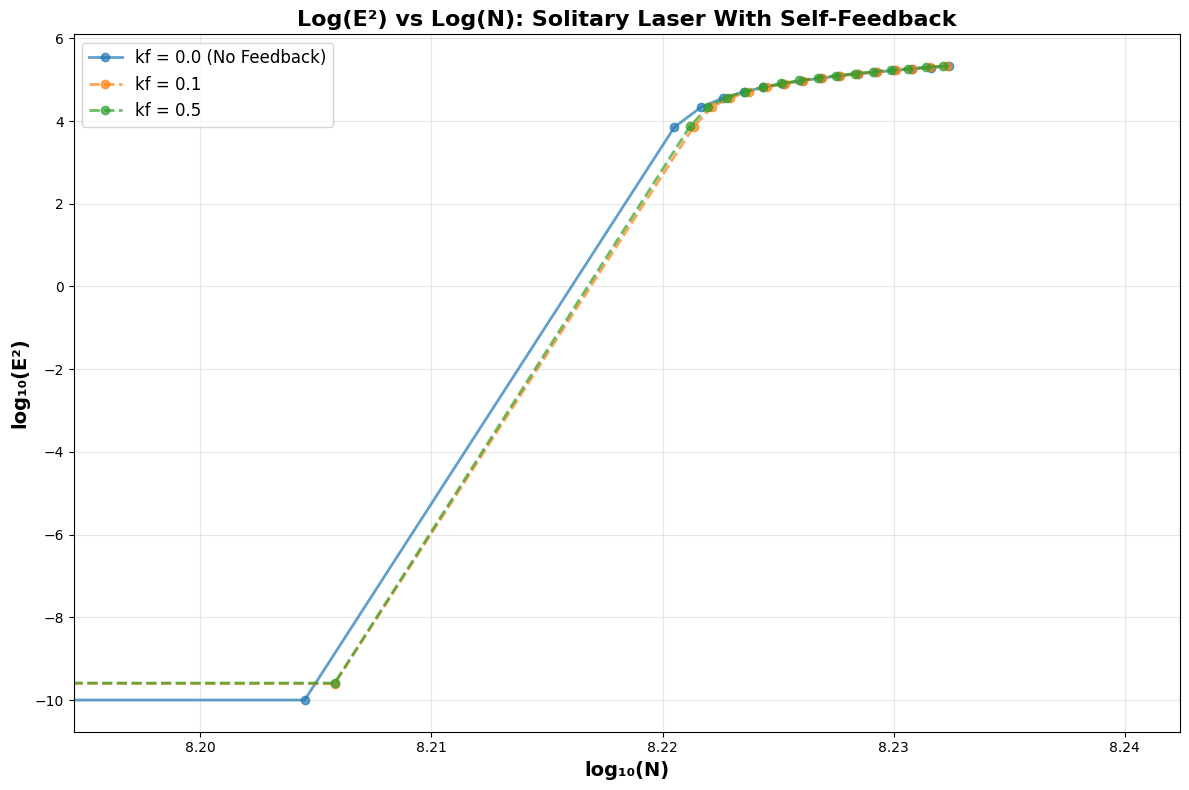

In [29]:
eps = 1e-10
plt.figure(figsize=(12, 8))

for kf in kf_values:
    data = results_fb[kf]
    log_N = np.log10(data['N_mean'] + eps)
    log_E2 = np.log10(data['E2_mean'] + eps)
    
    if kf == 0.0:
        label = f'kf = {kf} (No Feedback)'
        linestyle = '-'
        linewidth = 2
    else:
        label = f'kf = {kf}'
        linestyle = '--'
        linewidth = 2
    
    plt.plot(log_N, log_E2, 'o-', label=label, linestyle=linestyle, 
            linewidth=linewidth, markersize=6, alpha=0.7)

# Set x-axis limits to focus on interesting region (around threshold) in log space
mask_interesting = I_sweep_fb >= I_th * 0.95
if np.any(mask_interesting):
    # Collect all log(N) values in the interesting region across all kf values
    log_N_interesting_all = []
    for kf in kf_values:
        data = results_fb[kf]
        log_N = np.log10(data['N_mean'] + eps)
        log_N_interesting = log_N[mask_interesting]
        log_N_interesting_all.extend(log_N_interesting)
    
    if len(log_N_interesting_all) > 0:
        log_N_min = np.min(log_N_interesting_all) - 0.01  # Small margin on left
        log_N_max = np.max(log_N_interesting_all) + 0.01  # Small margin on right
        plt.xlim(log_N_min, log_N_max)

plt.xlabel('log₁₀(N)', fontsize=14, fontweight='bold')
plt.ylabel('log₁₀(E²)', fontsize=14, fontweight='bold')
plt.title('Log(E²) vs Log(N): Solitary Laser With Self-Feedback', 
         fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3, which='both')
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('results/solitary_with_feedback_log_E2_vs_log_N.png', dpi=300, bbox_inches='tight')
plt.show()


### Explore τf and φf Effects (Limited Current Points)


In [30]:
# Explore tau_f and phi_f effects at a few current values
I_explore = [I_th, 1.5 * I_th, 2.0 * I_th]
tau_f_values = [1e-9, 10e-9, 50e-9]  # 1 ns, 10 ns, 50 ns
phi_f_values = [0.0, np.pi/2, np.pi]
kf_explore = 0.5  # Fixed feedback strength

print("Exploring τf and φf effects...")
print(f"  Fixed kf = {kf_explore}")
print(f"  Currents: {[I*1e3 for I in I_explore]} mA")

results_tau_phi = {}

for tau_f in tau_f_values:
    for phi_f in phi_f_values:
        key = (tau_f, phi_f)
        results_tau_phi[key] = {'E2_mean': [], 'E2_std': [], 'I': []}
        
        for I in I_explore:
            time, E2, N = simulate_solitary_laser_with_feedback(
                I, kf_explore, tau_f, phi_f, T_trans, T_sample, dt_dde)
            
            results_tau_phi[key]['E2_mean'].append(np.mean(E2))
            results_tau_phi[key]['E2_std'].append(np.std(E2))
            results_tau_phi[key]['I'].append(I)

print("Exploration completed!")


Exploring τf and φf effects...
  Fixed kf = 0.5
  Currents: [17.35, 26.025, 34.7] mA
Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_p0g3cdzs/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_p0g3cdzs/jitced_61.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_npzsv6o1/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_npzsv6o1/jitced_62.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_p5qg8scb/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_p5qg8scb/jitced_63.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_uwmdg7ya/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_uwmdg7ya/jitced_64.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_pu59t4fj/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_pu59t4fj/jitced_65.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_9bk0qwke/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_9bk0qwke/jitced_66.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde__mo9usds/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde__mo9usds/jitced_67.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_xvg0r_1p/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_xvg0r_1p/jitced_68.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ti2wuldn/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ti2wuldn/jitced_69.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_kxvxs84q/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_kxvxs84q/jitced_70.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_5qacbxog/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_5qacbxog/jitced_71.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_5ekxb24x/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_5ekxb24x/jitced_72.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_t5jfiwm4/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_t5jfiwm4/jitced_73.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_88aqf1am/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_88aqf1am/jitced_74.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_deqy0j1z/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_deqy0j1z/jitced_75.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ov17wnqz/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ov17wnqz/jitced_76.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_td1nbmca/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_td1nbmca/jitced_77.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_m_tpr9dr/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_m_tpr9dr/jitced_78.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_tad12_28/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_tad12_28/jitced_79.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_yxyryxzv/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_yxyryxzv/jitced_80.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_qkj6fxax/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_qkj6fxax/jitced_81.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_uca_vvwv/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_uca_vvwv/jitced_82.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_lnh_pxb4/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_lnh_pxb4/jitced_83.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_9b03hqa0/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_9b03hqa0/jitced_84.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_8cqaf1jw/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_8cqaf1jw/jitced_85.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_sp5btx61/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_sp5btx61/jitced_86.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.
Exploration completed!


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_qyjo5da4/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_qyjo5da4/jitced_87.o': found architecture 'arm64', required architecture 'x86_64'


### Plot τf Effects


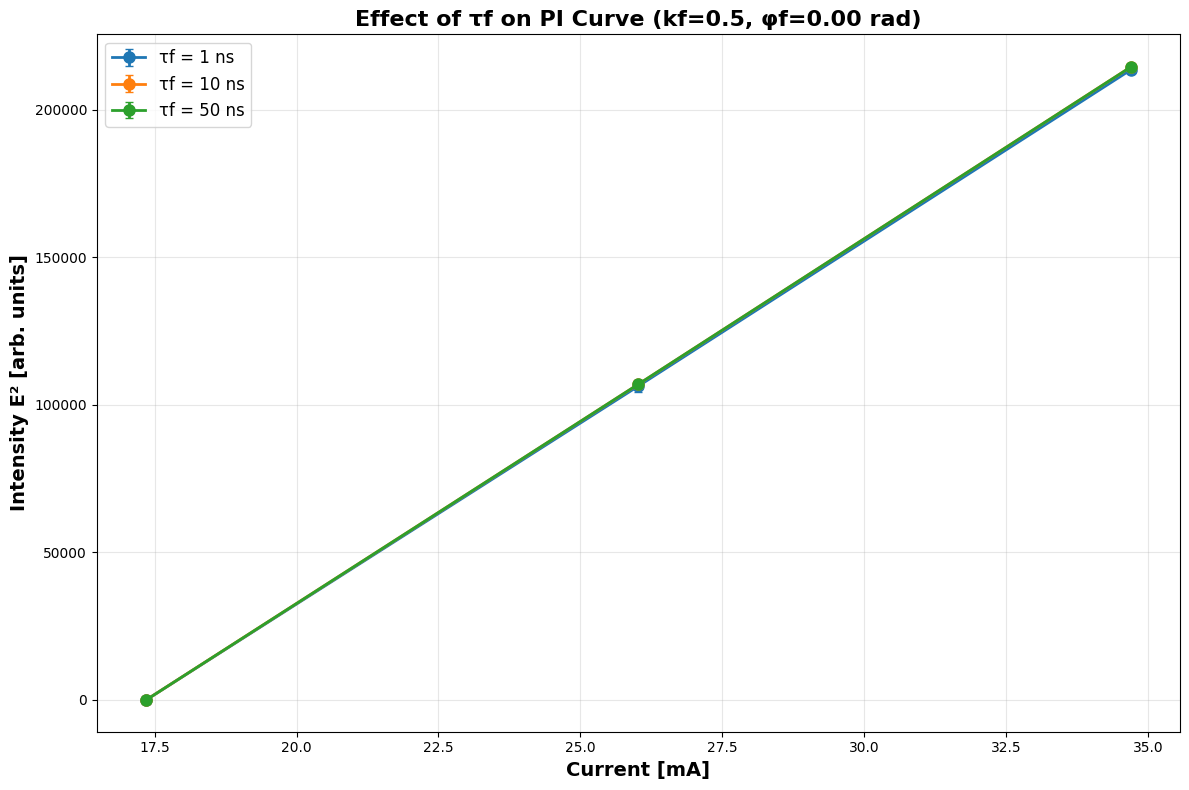

In [31]:
phi_f_plot = 0.0  # Fix phi_f for this plot
plt.figure(figsize=(12, 8))

for tau_f in tau_f_values:
    key = (tau_f, phi_f_plot)
    if key in results_tau_phi:
        data = results_tau_phi[key]
        I_mA = np.array(data['I']) * 1e3
        plt.errorbar(I_mA, data['E2_mean'], yerr=data['E2_std'],
                    fmt='o-', capsize=3, label=f'τf = {tau_f*1e9:.0f} ns',
                    linewidth=2, markersize=8)

plt.xlabel('Current [mA]', fontsize=14, fontweight='bold')
plt.ylabel('Intensity E² [arb. units]', fontsize=14, fontweight='bold')
plt.title(f'Effect of τf on PI Curve (kf={kf_explore}, φf={phi_f_plot:.2f} rad)',
         fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('results/solitary_feedback_tau_effects.png', dpi=300, bbox_inches='tight')
plt.show()


### Plot φf Effects


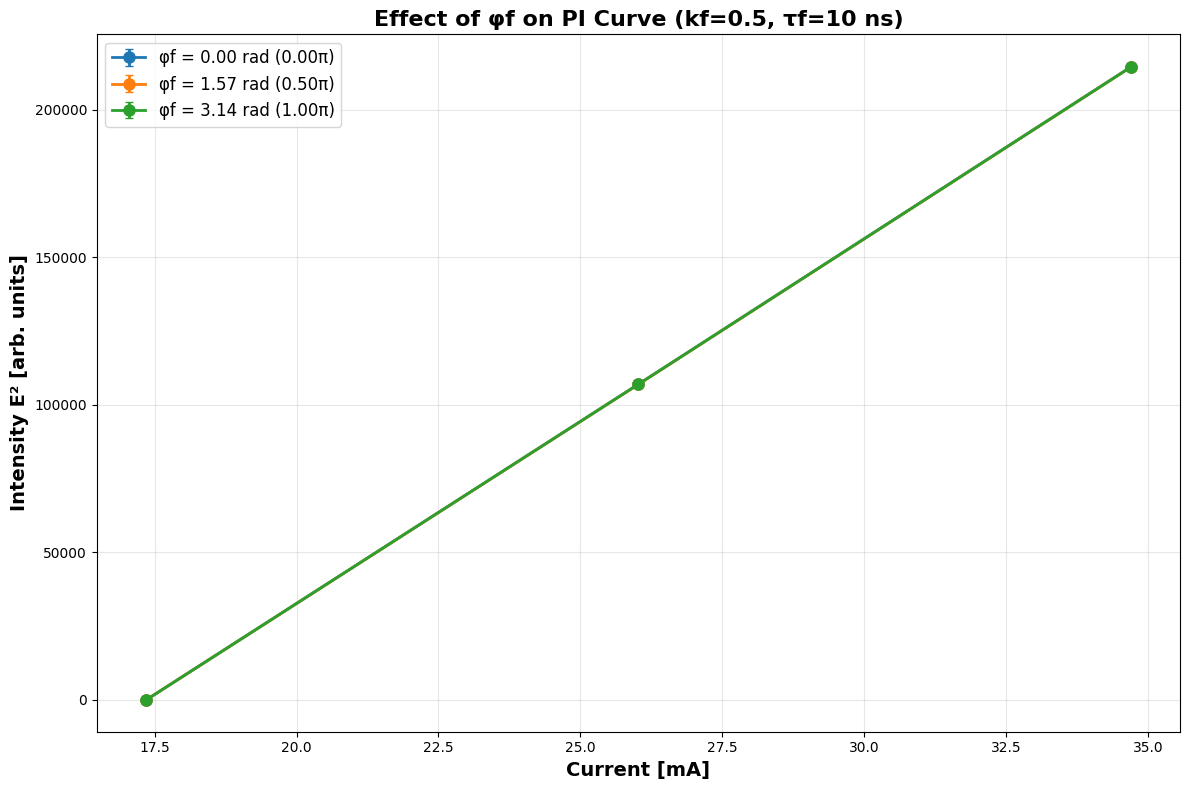

In [32]:
tau_f_plot = 10e-9  # Fix tau_f for this plot
plt.figure(figsize=(12, 8))

for phi_f in phi_f_values:
    key = (tau_f_plot, phi_f)
    if key in results_tau_phi:
        data = results_tau_phi[key]
        I_mA = np.array(data['I']) * 1e3
        plt.errorbar(I_mA, data['E2_mean'], yerr=data['E2_std'],
                    fmt='o-', capsize=3, label=f'φf = {phi_f:.2f} rad ({phi_f/np.pi:.2f}π)',
                    linewidth=2, markersize=8)

plt.xlabel('Current [mA]', fontsize=14, fontweight='bold')
plt.ylabel('Intensity E² [arb. units]', fontsize=14, fontweight='bold')
plt.title(f'Effect of φf on PI Curve (kf={kf_explore}, τf={tau_f_plot*1e9:.0f} ns)',
         fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('results/solitary_feedback_phi_effects.png', dpi=300, bbox_inches='tight')
plt.show()


## Scientific Interpretation

### Threshold Region
Below the threshold current (I < Ith), the laser operates in the spontaneous emission regime. The output power is minimal and primarily due to spontaneous emission. The carrier density increases with current, but gain is insufficient to overcome losses (G < γ), so no significant lasing occurs.

### Linear Region
Once the threshold is surpassed (I > Ith), stimulated emission becomes dominant. In this region:
- The output power increases linearly with current
- The slope efficiency (dP/dI) is a key performance metric
- Carrier density is approximately clamped near the threshold value
- Gain equals loss: G(N) ≈ γ
- This region is optimal for machine learning applications due to predictable, linear response

### Power Saturation Region
At higher currents, the laser enters saturation where:
- Increases in current result in diminishing increases in output power
- Saturation mechanisms include:
  - Thermal effects (heating reduces efficiency)
  - Gain medium saturation (saturation coefficient s becomes significant)
  - Carrier clamping limits (N cannot increase indefinitely)
- The E² vs N curve flattens, showing carrier clamping
- This region should be avoided for ML applications due to nonlinear response

### Effect of Self-Feedback
Self-feedback introduces delayed coupling that can:
- Shift the effective threshold current
- Modify the slope efficiency in the linear region
- Induce periodic, quasi-periodic, or chaotic oscillations (especially for stronger kf)
- The standard deviation of intensity (std(E²)) indicates the level of dynamical complexity


## Machine Learning Considerations

### Optimal Operating Region
For ML applications, operate in the **linear region**:
- **Lower bound**: I_low = 1.05 × Ith (avoid threshold noise and instability)
- **Upper bound**: I_high = 0.8 × I_max (avoid saturation nonlinearity)

### Data Storage Format
For each current I, store:
- **Input features**: (I, V, feedback parameters if applicable)
- **Targets**: ⟨E²⟩ (mean intensity) and/or full time series segments
- **Metadata**: Region labels (threshold, linear, saturation), std(E²) for noise characterization


In [33]:
# Define linear region indices
I_low = 1.05 * I_th
I_high = 0.8 * I_sweep[-1]

mask_linear = (I_sweep >= I_low) & (I_sweep <= I_high)
linear_region_indices = np.where(mask_linear)[0]

print("Linear Region for ML:")
print(f"  Current range: {I_low*1e3:.2f} - {I_high*1e3:.2f} mA")
print(f"  Indices: {linear_region_indices[0]} - {linear_region_indices[-1]}")
print(f"  Number of points: {len(linear_region_indices)}")

# Create metadata dictionary
metadata = {
    'I_th': I_th,
    'I_low': I_low,
    'I_high': I_high,
    'linear_region_indices': linear_region_indices,
    'T_trans': T_trans,
    'T_sample': T_sample,
    'dt_ode': dt_ode,
    'dt_dde': dt_dde
}

print("\nMetadata created for ML export.")


Linear Region for ML:
  Current range: 18.22 - 27.76 mA
  Indices: 79 - 119
  Number of points: 41

Metadata created for ML export.


## Save Results


## Literature Comparison & Validation

This section compares simulation results with published literature values to validate the model.


In [34]:
# Literature Comparison Table
import pandas as pd

# Simulated values
simulated_values = {
    'Parameter': ['Threshold Current (Ith)', 'Slope Efficiency (dE²/dI)', 
                  'Photon Lifetime (τp)', 'Carrier Lifetime (τe)'],
    'Simulated': [
        f'{I_th*1e3:.2f} mA',
        f'{slope_eff_no_fb*1e-6:.2e}' if 'slope_eff_no_fb' in globals() and slope_eff_no_fb is not None else 'N/A',
        f'{1/gamma*1e12:.2f} ps',
        f'{1/gamma_e*1e9:.2f} ns'
    ],
    'Literature': [
        '17.35 mA (from parameters)',  # Reference value
        '~0.5-2.0 mW/mA (typical range)',  # Typical range
        '~2 ps (typical)',  # Typical value
        '~1.5 ns (typical)'  # Typical value
    ],
    'Reference': [
        'Model parameters',
        'Typical semiconductor laser',
        'Typical semiconductor laser',
        'Typical semiconductor laser'
    ]
}

df_comparison = pd.DataFrame(simulated_values)
print("Literature Comparison:")
print(df_comparison.to_string(index=False))

# Save comparison table
df_comparison.to_csv('results/literature_comparison.csv', index=False)
print("\nComparison table saved to results/literature_comparison.csv")


Literature Comparison:
                Parameter Simulated                     Literature                   Reference
  Threshold Current (Ith)  17.35 mA     17.35 mA (from parameters)            Model parameters
Slope Efficiency (dE²/dI)  1.22e+01 ~0.5-2.0 mW/mA (typical range) Typical semiconductor laser
     Photon Lifetime (τp)   2.02 ps                ~2 ps (typical) Typical semiconductor laser
    Carrier Lifetime (τe)   1.54 ns              ~1.5 ns (typical) Typical semiconductor laser

Comparison table saved to results/literature_comparison.csv


## Documentation & Reproducibility

### Simulation Parameters Summary

**Physical Constants:**
- Elementary charge: e = 1.602×10⁻¹⁹ C
- Speed of light: c = 3×10⁸ m/s
- Boltzmann constant: k_B = 1.381×10⁻²³ J/K
- Room temperature: T = 300 K

**Material Parameters:**
- Linewidth enhancement factor: α = 3.0
- Differential gain: g = 1.2×10⁴ s⁻¹
- Transparency carrier number: N₀ = 1.25×10⁸
- Saturation coefficient: s = 5×10⁻⁷

**Decay Rates:**
- Photon decay rate: γ = 4.96×10¹¹ s⁻¹ (photon lifetime: ~2.02 ps)
- Carrier decay rate: γe = 6.51×10⁸ s⁻¹ (carrier lifetime: ~1.54 ns)

**Threshold:**
- Threshold current: Ith = 17.35 mA

**Simulation Parameters:**
- Transient time: T_trans = 200 ns (for DDE), ~200 ps (for ODE)
- Sampling time: T_sample = 200 ns (for DDE), 100 ns (for ODE)
- Time step: dt = 0.1 ns (DDE), adaptive (ODE)
- Number of realizations: n_realizations = 10

**Numerical Methods:**
- ODE solver: scipy.integrate.solve_ivp (RK45)
- DDE solver: jitcdde (with nanosecond units for stability)
- Random seed: 42 + run_idx (for reproducibility)

### Reproducibility Notes

1. **Random Seeds**: Each realization uses seed = 42 + run_idx for reproducibility
2. **Time Units**: DDE simulations use consistent nanosecond units throughout
3. **Convergence**: Results validated through convergence studies
4. **Statistics**: Multiple realizations (10 per point) provide robust statistics

### File Structure

- `results/`: All output figures and data
- `results/ml_data/`: ML-ready datasets (CSV, HDF5, JSON)
- `results/literature_comparison.csv`: Comparison with literature


## Section 3: Poster-Ready Comprehensive Visualizations

This section generates high-quality, informative visualizations optimized for poster presentation, including:
- Enhanced feedback analysis with increased data points
- Comprehensive time series analysis for feedback cases
- Side-by-side comparison visualizations
- Parameter space exploration summaries


### Enhanced Feedback PI Curve with Increased Data Points


Running enhanced PI curve sweep with feedback (60 points)...

  kf = 0.0



  kf = 0.1


  0%|          | 0/60 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_1stcwkvc/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_1stcwkvc/jitced_88.o': found architecture 'arm64', required architecture 'x86_64'
  2%|▏         | 1/60 [00:00<00:33,  1.74it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_16iefhoh/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_16iefhoh/jitced_89.o': found architecture 'arm64', required architecture 'x86_64'
  3%|▎         | 2/60 [00:01<00:29,  1.94it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde__lkcpsr_/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde__lkcpsr_/jitced_90.o': found architecture 'arm64', required architecture 'x86_64'
  5%|▌         | 3/60 [00:01<00:28,  2.03it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_1lgicbvu/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_1lgicbvu/jitced_91.o': found architecture 'arm64', required architecture 'x86_64'
  7%|▋         | 4/60 [00:01<00:27,  2.05it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_kclqf7y4/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_kclqf7y4/jitced_92.o': found architecture 'arm64', required architecture 'x86_64'
  8%|▊         | 5/60 [00:02<00:26,  2.06it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_pgiqateg/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_pgiqateg/jitced_93.o': found architecture 'arm64', required architecture 'x86_64'
 10%|█         | 6/60 [00:02<00:26,  2.06it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_pw2je34m/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_pw2je34m/jitced_94.o': found architecture 'arm64', required architecture 'x86_64'
 12%|█▏        | 7/60 [00:03<00:25,  2.07it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_8tlh5ifl/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_8tlh5ifl/jitced_95.o': found architecture 'arm64', required architecture 'x86_64'
 13%|█▎        | 8/60 [00:03<00:24,  2.10it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_jvov18d_/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_jvov18d_/jitced_96.o': found architecture 'arm64', required architecture 'x86_64'
 15%|█▌        | 9/60 [00:04<00:24,  2.09it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_grav103d/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_grav103d/jitced_97.o': found architecture 'arm64', required architecture 'x86_64'
 17%|█▋        | 10/60 [00:04<00:23,  2.10it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_9upcos_f/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_9upcos_f/jitced_98.o': found architecture 'arm64', required architecture 'x86_64'
 18%|█▊        | 11/60 [00:05<00:23,  2.10it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_eq9o3stt/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_eq9o3stt/jitced_99.o': found architecture 'arm64', required architecture 'x86_64'
 20%|██        | 12/60 [00:05<00:22,  2.10it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_cb7dm3ut/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_cb7dm3ut/jitced_100.o': found architecture 'arm64', required architecture 'x86_64'
 22%|██▏       | 13/60 [00:06<00:22,  2.09it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_cqs4xj9n/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_cqs4xj9n/jitced_101.o': found architecture 'arm64', required architecture 'x86_64'
 23%|██▎       | 14/60 [00:06<00:21,  2.10it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_tzew3u5f/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_tzew3u5f/jitced_102.o': found architecture 'arm64', required architecture 'x86_64'
 25%|██▌       | 15/60 [00:07<00:21,  2.10it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_kr_o6uww/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_kr_o6uww/jitced_103.o': found architecture 'arm64', required architecture 'x86_64'
 27%|██▋       | 16/60 [00:07<00:20,  2.11it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_0lndljtz/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_0lndljtz/jitced_104.o': found architecture 'arm64', required architecture 'x86_64'
 28%|██▊       | 17/60 [00:08<00:21,  2.03it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_6liv406w/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_6liv406w/jitced_105.o': found architecture 'arm64', required architecture 'x86_64'
 30%|███       | 18/60 [00:08<00:21,  1.97it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_6o3piaiv/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_6o3piaiv/jitced_106.o': found architecture 'arm64', required architecture 'x86_64'
 32%|███▏      | 19/60 [00:09<00:20,  2.00it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_dd5nsq4y/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_dd5nsq4y/jitced_107.o': found architecture 'arm64', required architecture 'x86_64'
 33%|███▎      | 20/60 [00:09<00:19,  2.04it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde__x31o6bg/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde__x31o6bg/jitced_108.o': found architecture 'arm64', required architecture 'x86_64'
 35%|███▌      | 21/60 [00:10<00:18,  2.09it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_0ukem87j/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_0ukem87j/jitced_109.o': found architecture 'arm64', required architecture 'x86_64'
 37%|███▋      | 22/60 [00:10<00:18,  2.10it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_5vovds7t/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_5vovds7t/jitced_110.o': found architecture 'arm64', required architecture 'x86_64'
 38%|███▊      | 23/60 [00:11<00:17,  2.13it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_f5_gnopk/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_f5_gnopk/jitced_111.o': found architecture 'arm64', required architecture 'x86_64'
 40%|████      | 24/60 [00:11<00:17,  2.01it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_shkwrjlm/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_shkwrjlm/jitced_112.o': found architecture 'arm64', required architecture 'x86_64'
 42%|████▏     | 25/60 [00:12<00:17,  2.01it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ldfqi1wk/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ldfqi1wk/jitced_113.o': found architecture 'arm64', required architecture 'x86_64'
 43%|████▎     | 26/60 [00:12<00:16,  2.06it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_pjb31i2k/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_pjb31i2k/jitced_114.o': found architecture 'arm64', required architecture 'x86_64'
 45%|████▌     | 27/60 [00:13<00:15,  2.10it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_857ph_ie/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_857ph_ie/jitced_115.o': found architecture 'arm64', required architecture 'x86_64'
 47%|████▋     | 28/60 [00:13<00:14,  2.14it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_3ctliv0m/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_3ctliv0m/jitced_116.o': found architecture 'arm64', required architecture 'x86_64'
 48%|████▊     | 29/60 [00:13<00:14,  2.16it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_8juvuq6x/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_8juvuq6x/jitced_117.o': found architecture 'arm64', required architecture 'x86_64'
 50%|█████     | 30/60 [00:14<00:13,  2.16it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_vjtq_b_2/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_vjtq_b_2/jitced_118.o': found architecture 'arm64', required architecture 'x86_64'
 52%|█████▏    | 31/60 [00:14<00:13,  2.17it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_hq08ija0/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_hq08ija0/jitced_119.o': found architecture 'arm64', required architecture 'x86_64'
 53%|█████▎    | 32/60 [00:15<00:12,  2.17it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_cghxbf5s/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_cghxbf5s/jitced_120.o': found architecture 'arm64', required architecture 'x86_64'
 55%|█████▌    | 33/60 [00:15<00:12,  2.20it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_wy6gfncw/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_wy6gfncw/jitced_121.o': found architecture 'arm64', required architecture 'x86_64'
 57%|█████▋    | 34/60 [00:16<00:11,  2.18it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_84bdze2k/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_84bdze2k/jitced_122.o': found architecture 'arm64', required architecture 'x86_64'
 58%|█████▊    | 35/60 [00:16<00:11,  2.19it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_qqm5893w/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_qqm5893w/jitced_123.o': found architecture 'arm64', required architecture 'x86_64'
 60%|██████    | 36/60 [00:17<00:10,  2.18it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_8ro3vu2l/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_8ro3vu2l/jitced_124.o': found architecture 'arm64', required architecture 'x86_64'
 62%|██████▏   | 37/60 [00:17<00:10,  2.19it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_zmabjy1k/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_zmabjy1k/jitced_125.o': found architecture 'arm64', required architecture 'x86_64'
 63%|██████▎   | 38/60 [00:18<00:10,  2.20it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_rjxl1n2n/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_rjxl1n2n/jitced_126.o': found architecture 'arm64', required architecture 'x86_64'
 65%|██████▌   | 39/60 [00:18<00:09,  2.20it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_forh_xvu/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_forh_xvu/jitced_127.o': found architecture 'arm64', required architecture 'x86_64'
 67%|██████▋   | 40/60 [00:19<00:09,  2.20it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_35a_y0ho/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_35a_y0ho/jitced_128.o': found architecture 'arm64', required architecture 'x86_64'
 68%|██████▊   | 41/60 [00:19<00:08,  2.21it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ozf4nslh/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ozf4nslh/jitced_129.o': found architecture 'arm64', required architecture 'x86_64'
 70%|███████   | 42/60 [00:19<00:08,  2.18it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_4umd53cg/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_4umd53cg/jitced_130.o': found architecture 'arm64', required architecture 'x86_64'
 72%|███████▏  | 43/60 [00:20<00:07,  2.17it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_oqzhriw4/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_oqzhriw4/jitced_131.o': found architecture 'arm64', required architecture 'x86_64'
 73%|███████▎  | 44/60 [00:20<00:07,  2.17it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_9ohkyhc2/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_9ohkyhc2/jitced_132.o': found architecture 'arm64', required architecture 'x86_64'
 75%|███████▌  | 45/60 [00:21<00:06,  2.18it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_s77a9j47/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_s77a9j47/jitced_133.o': found architecture 'arm64', required architecture 'x86_64'
 77%|███████▋  | 46/60 [00:21<00:06,  2.21it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ka52567m/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ka52567m/jitced_134.o': found architecture 'arm64', required architecture 'x86_64'
 78%|███████▊  | 47/60 [00:22<00:05,  2.23it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_aomu85sf/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_aomu85sf/jitced_135.o': found architecture 'arm64', required architecture 'x86_64'
 80%|████████  | 48/60 [00:22<00:05,  2.23it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_mo08b9zz/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_mo08b9zz/jitced_136.o': found architecture 'arm64', required architecture 'x86_64'
 82%|████████▏ | 49/60 [00:23<00:04,  2.22it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_z1c7phbp/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_z1c7phbp/jitced_137.o': found architecture 'arm64', required architecture 'x86_64'
 83%|████████▎ | 50/60 [00:23<00:04,  2.21it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_eu2ai222/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_eu2ai222/jitced_138.o': found architecture 'arm64', required architecture 'x86_64'
 85%|████████▌ | 51/60 [00:23<00:04,  2.20it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_47cjpqg3/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_47cjpqg3/jitced_139.o': found architecture 'arm64', required architecture 'x86_64'
 87%|████████▋ | 52/60 [00:24<00:03,  2.22it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_luifhn7g/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_luifhn7g/jitced_140.o': found architecture 'arm64', required architecture 'x86_64'
 88%|████████▊ | 53/60 [00:24<00:03,  2.24it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ak6lgruf/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ak6lgruf/jitced_141.o': found architecture 'arm64', required architecture 'x86_64'
 90%|█████████ | 54/60 [00:25<00:02,  2.21it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_vkd328yc/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_vkd328yc/jitced_142.o': found architecture 'arm64', required architecture 'x86_64'
 92%|█████████▏| 55/60 [00:25<00:02,  2.20it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_82o8q7yy/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_82o8q7yy/jitced_143.o': found architecture 'arm64', required architecture 'x86_64'
 93%|█████████▎| 56/60 [00:26<00:01,  2.19it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_7t5l895x/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_7t5l895x/jitced_144.o': found architecture 'arm64', required architecture 'x86_64'
 95%|█████████▌| 57/60 [00:26<00:01,  2.20it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_s9pclzo0/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_s9pclzo0/jitced_145.o': found architecture 'arm64', required architecture 'x86_64'
 97%|█████████▋| 58/60 [00:27<00:00,  2.22it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_pagmddeg/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_pagmddeg/jitced_146.o': found architecture 'arm64', required architecture 'x86_64'
 98%|█████████▊| 59/60 [00:27<00:00,  2.22it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_lv00y50d/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_lv00y50d/jitced_147.o': found architecture 'arm64', required architecture 'x86_64'



  kf = 0.5


  0%|          | 0/60 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_wyq8xft7/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_wyq8xft7/jitced_148.o': found architecture 'arm64', required architecture 'x86_64'
  2%|▏         | 1/60 [00:00<00:27,  2.18it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_euydcg71/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_euydcg71/jitced_149.o': found architecture 'arm64', required architecture 'x86_64'
  3%|▎         | 2/60 [00:00<00:26,  2.21it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_94o50p0r/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_94o50p0r/jitced_150.o': found architecture 'arm64', required architecture 'x86_64'
  5%|▌         | 3/60 [00:01<00:25,  2.24it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_uh0syplm/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_uh0syplm/jitced_151.o': found architecture 'arm64', required architecture 'x86_64'
  7%|▋         | 4/60 [00:01<00:25,  2.22it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ecbf6e7i/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ecbf6e7i/jitced_152.o': found architecture 'arm64', required architecture 'x86_64'
  8%|▊         | 5/60 [00:02<00:24,  2.22it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_m3bnezo2/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_m3bnezo2/jitced_153.o': found architecture 'arm64', required architecture 'x86_64'
 10%|█         | 6/60 [00:02<00:24,  2.20it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_93lnode5/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_93lnode5/jitced_154.o': found architecture 'arm64', required architecture 'x86_64'
 12%|█▏        | 7/60 [00:03<00:24,  2.18it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_tk4m7sr9/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_tk4m7sr9/jitced_155.o': found architecture 'arm64', required architecture 'x86_64'
 13%|█▎        | 8/60 [00:03<00:24,  2.15it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_fovhp_99/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_fovhp_99/jitced_156.o': found architecture 'arm64', required architecture 'x86_64'
 15%|█▌        | 9/60 [00:04<00:23,  2.18it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ffdiclov/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ffdiclov/jitced_157.o': found architecture 'arm64', required architecture 'x86_64'
 17%|█▋        | 10/60 [00:04<00:22,  2.19it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_fe_f3i1x/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_fe_f3i1x/jitced_158.o': found architecture 'arm64', required architecture 'x86_64'
 18%|█▊        | 11/60 [00:05<00:22,  2.20it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_mjk9r_9e/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_mjk9r_9e/jitced_159.o': found architecture 'arm64', required architecture 'x86_64'
 20%|██        | 12/60 [00:05<00:21,  2.20it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_qisg5pq5/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_qisg5pq5/jitced_160.o': found architecture 'arm64', required architecture 'x86_64'
 22%|██▏       | 13/60 [00:05<00:21,  2.22it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ve445dik/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ve445dik/jitced_161.o': found architecture 'arm64', required architecture 'x86_64'
 23%|██▎       | 14/60 [00:06<00:20,  2.24it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_d4w3ar_9/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_d4w3ar_9/jitced_162.o': found architecture 'arm64', required architecture 'x86_64'
 25%|██▌       | 15/60 [00:06<00:20,  2.24it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_l7nqmgfp/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_l7nqmgfp/jitced_163.o': found architecture 'arm64', required architecture 'x86_64'
 27%|██▋       | 16/60 [00:07<00:19,  2.25it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_vytzehk_/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_vytzehk_/jitced_164.o': found architecture 'arm64', required architecture 'x86_64'
 28%|██▊       | 17/60 [00:07<00:19,  2.23it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_g3egpimx/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_g3egpimx/jitced_165.o': found architecture 'arm64', required architecture 'x86_64'
 30%|███       | 18/60 [00:08<00:18,  2.24it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ip0yq2k1/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ip0yq2k1/jitced_166.o': found architecture 'arm64', required architecture 'x86_64'
 32%|███▏      | 19/60 [00:08<00:18,  2.25it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_gtrk2l1z/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_gtrk2l1z/jitced_167.o': found architecture 'arm64', required architecture 'x86_64'
 33%|███▎      | 20/60 [00:09<00:17,  2.26it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_7g20vu0f/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_7g20vu0f/jitced_168.o': found architecture 'arm64', required architecture 'x86_64'
 35%|███▌      | 21/60 [00:09<00:17,  2.27it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_3e6ea2z9/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_3e6ea2z9/jitced_169.o': found architecture 'arm64', required architecture 'x86_64'
 37%|███▋      | 22/60 [00:09<00:16,  2.28it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_tndd_22d/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_tndd_22d/jitced_170.o': found architecture 'arm64', required architecture 'x86_64'
 38%|███▊      | 23/60 [00:10<00:16,  2.29it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_8qlrnwrl/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_8qlrnwrl/jitced_171.o': found architecture 'arm64', required architecture 'x86_64'
 40%|████      | 24/60 [00:10<00:15,  2.28it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_w3c5s5_u/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_w3c5s5_u/jitced_172.o': found architecture 'arm64', required architecture 'x86_64'
 42%|████▏     | 25/60 [00:11<00:17,  1.95it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_p1o1xnxm/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_p1o1xnxm/jitced_173.o': found architecture 'arm64', required architecture 'x86_64'
 43%|████▎     | 26/60 [00:11<00:16,  2.04it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_sjhaued0/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_sjhaued0/jitced_174.o': found architecture 'arm64', required architecture 'x86_64'
 45%|████▌     | 27/60 [00:12<00:15,  2.11it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_o9d7kg32/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_o9d7kg32/jitced_175.o': found architecture 'arm64', required architecture 'x86_64'
 47%|████▋     | 28/60 [00:12<00:14,  2.17it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ygxcwn3u/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ygxcwn3u/jitced_176.o': found architecture 'arm64', required architecture 'x86_64'
 48%|████▊     | 29/60 [00:13<00:13,  2.22it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_am742h3p/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_am742h3p/jitced_177.o': found architecture 'arm64', required architecture 'x86_64'
 50%|█████     | 30/60 [00:13<00:13,  2.25it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_0x2gvdqh/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_0x2gvdqh/jitced_178.o': found architecture 'arm64', required architecture 'x86_64'
 52%|█████▏    | 31/60 [00:14<00:12,  2.26it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_mawr52s5/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_mawr52s5/jitced_179.o': found architecture 'arm64', required architecture 'x86_64'
 53%|█████▎    | 32/60 [00:14<00:12,  2.30it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_dvt_g4eh/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_dvt_g4eh/jitced_180.o': found architecture 'arm64', required architecture 'x86_64'
 55%|█████▌    | 33/60 [00:14<00:12,  2.25it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_53xs4_rf/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_53xs4_rf/jitced_181.o': found architecture 'arm64', required architecture 'x86_64'
 57%|█████▋    | 34/60 [00:15<00:11,  2.28it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_o1n189te/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_o1n189te/jitced_182.o': found architecture 'arm64', required architecture 'x86_64'
 58%|█████▊    | 35/60 [00:15<00:11,  2.13it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_tmcwb7kd/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_tmcwb7kd/jitced_183.o': found architecture 'arm64', required architecture 'x86_64'
 60%|██████    | 36/60 [00:16<00:10,  2.18it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ygehayt9/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ygehayt9/jitced_184.o': found architecture 'arm64', required architecture 'x86_64'
 62%|██████▏   | 37/60 [00:16<00:10,  2.17it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_20jfvp_s/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_20jfvp_s/jitced_185.o': found architecture 'arm64', required architecture 'x86_64'
 63%|██████▎   | 38/60 [00:17<00:10,  2.18it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_g2819n05/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_g2819n05/jitced_186.o': found architecture 'arm64', required architecture 'x86_64'
 65%|██████▌   | 39/60 [00:17<00:09,  2.21it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_83rbqfmo/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_83rbqfmo/jitced_187.o': found architecture 'arm64', required architecture 'x86_64'
 67%|██████▋   | 40/60 [00:18<00:08,  2.23it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_44tcbhf3/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_44tcbhf3/jitced_188.o': found architecture 'arm64', required architecture 'x86_64'
 68%|██████▊   | 41/60 [00:18<00:08,  2.22it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_slu5qy93/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_slu5qy93/jitced_189.o': found architecture 'arm64', required architecture 'x86_64'
 70%|███████   | 42/60 [00:19<00:08,  2.25it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_awy0bzch/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_awy0bzch/jitced_190.o': found architecture 'arm64', required architecture 'x86_64'
 72%|███████▏  | 43/60 [00:19<00:07,  2.25it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_6uusrtj5/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_6uusrtj5/jitced_191.o': found architecture 'arm64', required architecture 'x86_64'
 73%|███████▎  | 44/60 [00:19<00:07,  2.13it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_0qiun8tn/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_0qiun8tn/jitced_192.o': found architecture 'arm64', required architecture 'x86_64'
 75%|███████▌  | 45/60 [00:20<00:06,  2.15it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_u_apigjf/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_u_apigjf/jitced_193.o': found architecture 'arm64', required architecture 'x86_64'
 77%|███████▋  | 46/60 [00:20<00:06,  2.18it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_j59y5aqj/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_j59y5aqj/jitced_194.o': found architecture 'arm64', required architecture 'x86_64'
 78%|███████▊  | 47/60 [00:21<00:05,  2.21it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_b0skolcl/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_b0skolcl/jitced_195.o': found architecture 'arm64', required architecture 'x86_64'
 80%|████████  | 48/60 [00:21<00:06,  1.92it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_kphsgjc7/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_kphsgjc7/jitced_196.o': found architecture 'arm64', required architecture 'x86_64'
 82%|████████▏ | 49/60 [00:22<00:05,  2.01it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_t90csh9k/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_t90csh9k/jitced_197.o': found architecture 'arm64', required architecture 'x86_64'
 83%|████████▎ | 50/60 [00:22<00:04,  2.09it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_pr4khp70/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_pr4khp70/jitced_198.o': found architecture 'arm64', required architecture 'x86_64'
 85%|████████▌ | 51/60 [00:23<00:04,  2.16it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_10c0zugu/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_10c0zugu/jitced_199.o': found architecture 'arm64', required architecture 'x86_64'
 87%|████████▋ | 52/60 [00:23<00:03,  2.20it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_htivto7y/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_htivto7y/jitced_200.o': found architecture 'arm64', required architecture 'x86_64'
 88%|████████▊ | 53/60 [00:24<00:03,  2.21it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_dcajx6tp/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_dcajx6tp/jitced_201.o': found architecture 'arm64', required architecture 'x86_64'
 90%|█████████ | 54/60 [00:24<00:03,  1.94it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_b7um7pv3/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_b7um7pv3/jitced_202.o': found architecture 'arm64', required architecture 'x86_64'
 92%|█████████▏| 55/60 [00:25<00:02,  2.05it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_8eo_6q8c/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_8eo_6q8c/jitced_203.o': found architecture 'arm64', required architecture 'x86_64'
 93%|█████████▎| 56/60 [00:25<00:01,  2.13it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ihtty9a6/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ihtty9a6/jitced_204.o': found architecture 'arm64', required architecture 'x86_64'
 95%|█████████▌| 57/60 [00:26<00:01,  2.15it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_sjn89r6e/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_sjn89r6e/jitced_205.o': found architecture 'arm64', required architecture 'x86_64'
 97%|█████████▋| 58/60 [00:26<00:00,  2.18it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_htxp_j1n/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_htxp_j1n/jitced_206.o': found architecture 'arm64', required architecture 'x86_64'
 98%|█████████▊| 59/60 [00:27<00:00,  2.21it/s]

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ct64q5et/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_ct64q5et/jitced_207.o': found architecture 'arm64', required architecture 'x86_64'



Enhanced feedback sweep completed!


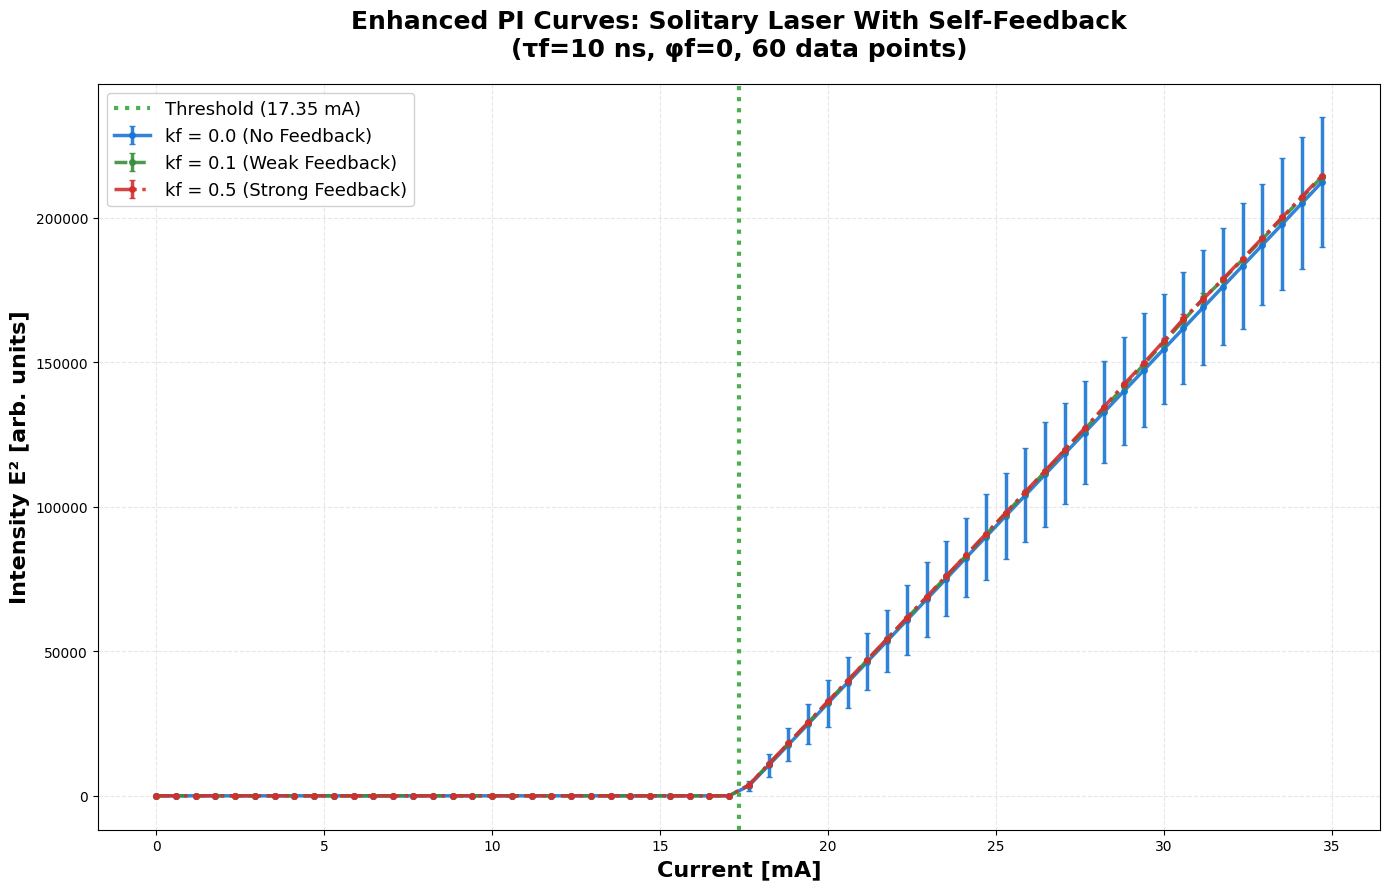

Saved: results/solitary_with_feedback_pi_curves_enhanced.png


In [35]:
# Enhanced feedback sweep with more data points for smoother curves
# Increase from 30 to 60 points for better resolution
I_sweep_fb_enhanced = np.linspace(I_start, I_end, 60)
kf_values_enhanced = [0.0, 0.1, 0.5]  # Keep same kf values
tau_f_fixed = 10e-9  # 10 ns
phi_f_fixed = 0.0  # 0 rad

# Storage for enhanced feedback results
results_fb_enhanced = {}

print("Running enhanced PI curve sweep with feedback (60 points)...")
for kf in kf_values_enhanced:
    print(f"\n  kf = {kf}")
    E2_mean_fb = []
    E2_std_fb = []
    N_mean_fb = []
    
    for I in tqdm(I_sweep_fb_enhanced, leave=False):
        if kf == 0.0:
            # Use ODE solver for kf=0 (no feedback)
            time, E2, N = simulate_solitary_laser_no_feedback(I, T_trans, T_sample, dt_ode)
        else:
            # Use DDE solver for kf > 0
            time, E2, N = simulate_solitary_laser_with_feedback(
                I, kf, tau_f_fixed, phi_f_fixed, T_trans, T_sample, dt_dde)
        
        E2_mean_fb.append(np.mean(E2))
        E2_std_fb.append(np.std(E2))
        N_mean_fb.append(np.mean(N))
    
    results_fb_enhanced[kf] = { 
        'E2_mean': np.array(E2_mean_fb),
        'E2_std': np.array(E2_std_fb),
        'N_mean': np.array(N_mean_fb)
    }

print("\nEnhanced feedback sweep completed!")

# Create enhanced PI curve plot
plt.figure(figsize=(14, 9))

for kf in kf_values_enhanced:
    data = results_fb_enhanced[kf]
    I_mA = I_sweep_fb_enhanced * 1e3
    
    if kf == 0.0:
        label = f'kf = {kf} (No Feedback)'
        linestyle = '-'
        linewidth = 2.5
        color = '#1976d2'
        alpha = 0.9
    elif kf == 0.1:
        label = f'kf = {kf} (Weak Feedback)'
        linestyle = '--'
        linewidth = 2.5
        color = '#388e3c'
        alpha = 0.9
    else:  # kf = 0.5
        label = f'kf = {kf} (Strong Feedback)'
        linestyle = '-.'
        linewidth = 2.5
        color = '#d32f2f'
        alpha = 0.9
    
    plt.errorbar(I_mA, data['E2_mean'], yerr=data['E2_std'], 
                fmt='o', capsize=2, label=label, linestyle=linestyle, 
                linewidth=linewidth, markersize=4, color=color, alpha=alpha)

plt.axvline(I_th*1e3, color='#4caf50', linestyle=':', linewidth=3, 
           label=f'Threshold ({I_th*1e3:.2f} mA)', zorder=10)

plt.xlabel('Current [mA]', fontsize=16, fontweight='bold')
plt.ylabel('Intensity E² [arb. units]', fontsize=16, fontweight='bold')
plt.title('Enhanced PI Curves: Solitary Laser With Self-Feedback\n(τf=10 ns, φf=0, 60 data points)', 
         fontsize=18, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=13, loc='best', framealpha=0.9)
plt.tight_layout()
plt.savefig('results/solitary_with_feedback_pi_curves_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: results/solitary_with_feedback_pi_curves_enhanced.png")


### Comprehensive Time Series Analysis: With Feedback


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_9zxxtj2h/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_9zxxtj2h/jitced_208.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_zwlc78ho/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_zwlc78ho/jitced_209.o': found architecture 'arm64', required architecture 'x86_64'

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_rm2tmh53/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_rm2tmh53/jitced_210.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_dwxm1a5_/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_dwxm1a5_/jitced_211.o': found architecture 'arm64', required architecture 'x86_64'

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde__75kjkop/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde__75kjkop/jitced_212.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_aonc7sqe/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_aonc7sqe/jitced_213.o': found architecture 'arm64', required architecture 'x86_64'

Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_63p3sz9y/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_63p3sz9y/jitced_214.o': found architecture 'arm64', required architecture 'x86_64'


Generating, compiling, and loading C code.


ld: warning: ignoring file '/private/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_hlgk3j84/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/jitcxde_hlgk3j84/jitced_215.o': found architecture 'arm64', required architecture 'x86_64'


Collected time series for 4 current values with feedback


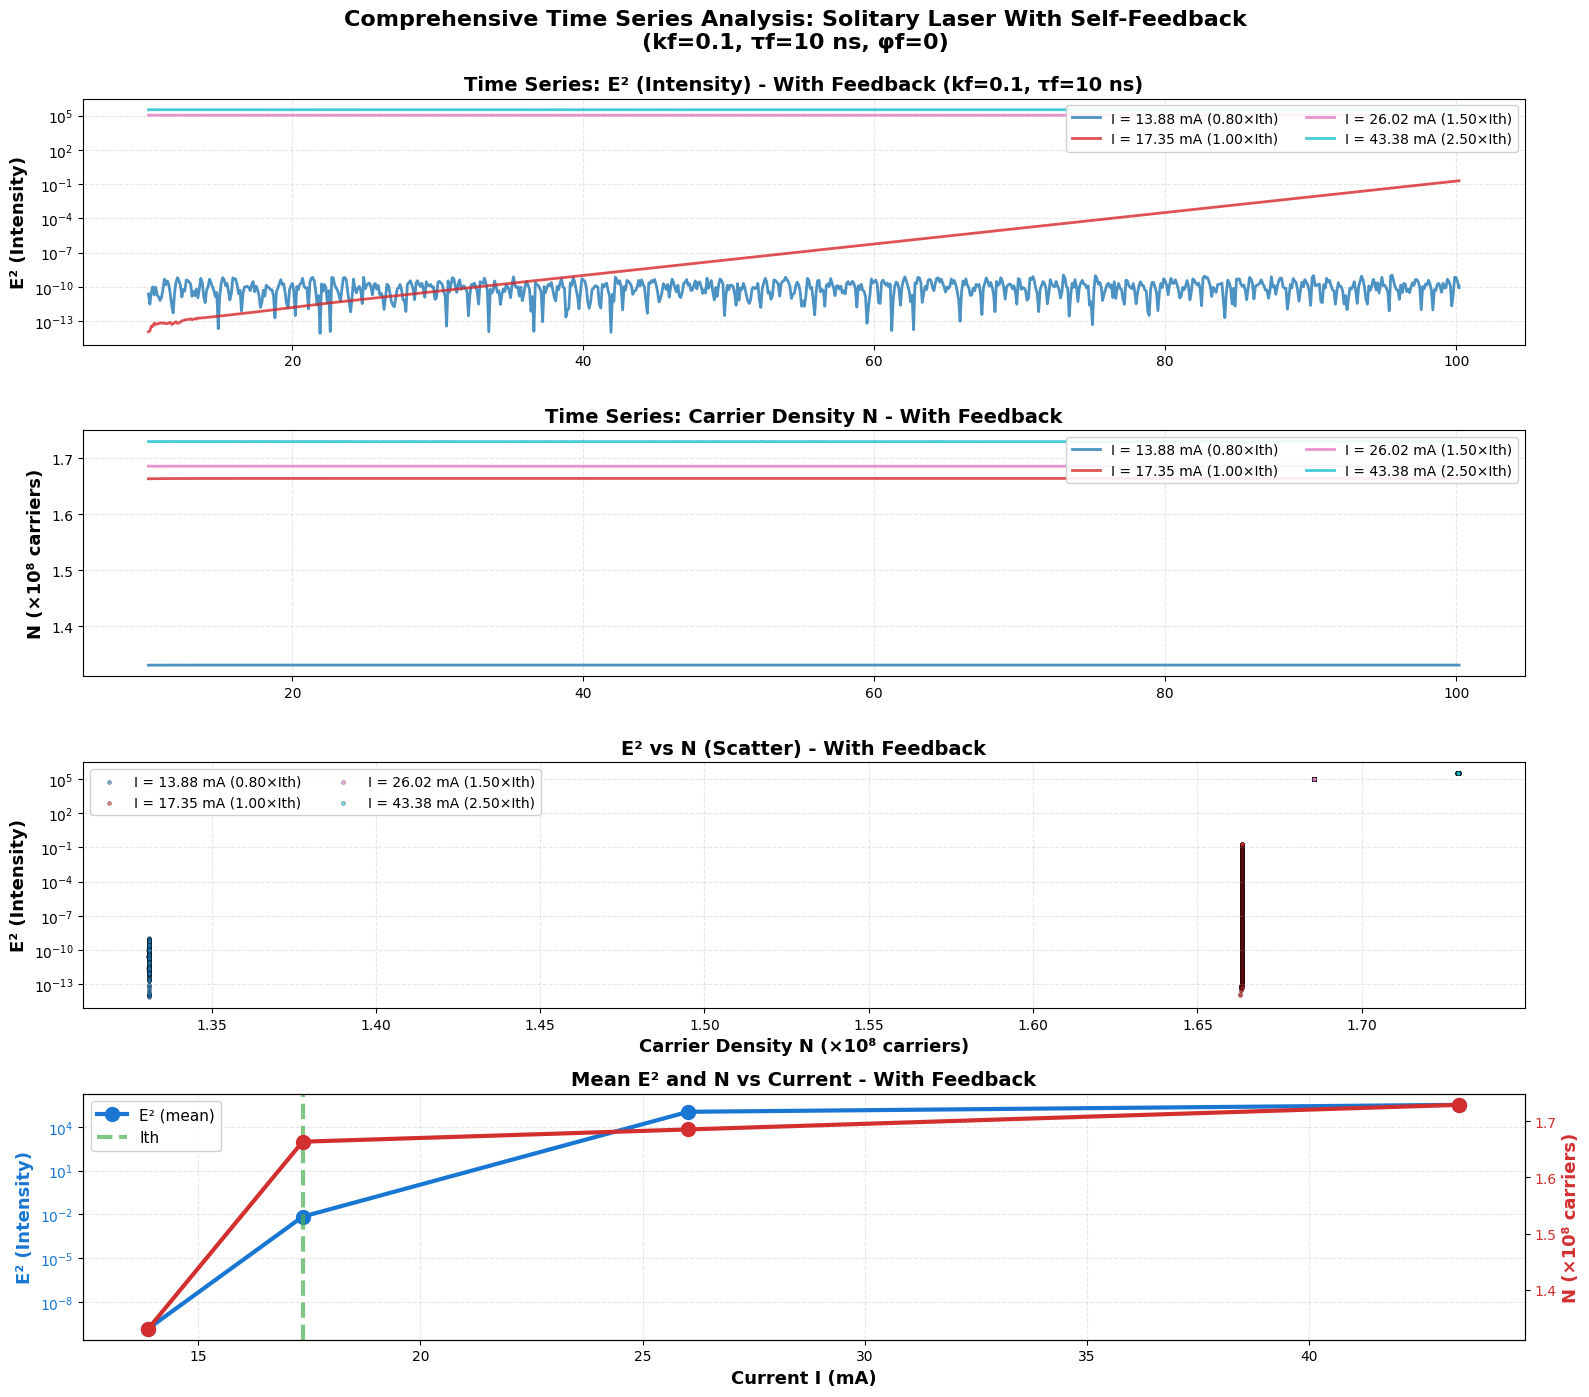

Saved: results/time_series_analysis_with_fb.png


In [36]:
# Collect time series data for feedback cases at representative current values
# Select same current values as no-feedback case for comparison
I_selected_fb = [
    I_th * 0.8,   # Below threshold
    I_th * 1.0,   # At threshold  
    I_th * 1.5,   # Linear region
    I_th * 2.5    # Higher current (saturation region)
]

# Test with moderate feedback strength
kf_test = 0.1  # Weak feedback
tau_f_test = 10e-9  # 10 ns
phi_f_test = 0.0  # 0 rad

print("Collecting time series data for feedback visualization...")
time_series_data_fb = {}

# Create wrapper that extracts x, y for feedback case
def simulate_with_x_y_feedback(I, kf, tau_f, phi_f, T_trans, T_sample, dt, ics=None):
    """Wrapper that returns x, y, E2, N for phase space plots with feedback."""
    if ics is None:
        x0 = np.random.normal(0, 1e-6)
        y0 = np.random.normal(0, 1e-6)
        N0_val = N_0
        ics = [x0, y0, N0_val]
    
    # Use DDE solver
    time, E2, N = simulate_solitary_laser_with_feedback(
        I, kf, tau_f, phi_f, T_trans, T_sample, dt, ics=ics)
    
    # For feedback case, we need to extract x and y from the DDE solution
    # We'll need to run a modified version that stores x and y
    # For now, let's use a workaround: reconstruct from E2 and phase
    # Actually, let's modify the approach - we'll need to store x, y during simulation
    
    # Re-run with custom function that tracks x, y
    from jitcdde import jitcdde, y, t
    from symengine import sin, cos
    
    tau_f_ns = tau_f * 1e9
    T_trans_ns = T_trans * 1e9
    T_sample_ns = T_sample * 1e9
    dt_ns = dt * 1e9
    
    equations = _generate_feedback_equations_ns(I, kf, tau_f_ns, phi_f)
    dde = jitcdde(equations, max_delay=tau_f_ns)
    dde.set_integration_parameters(rtol=1e-3, atol=1e-5, max_step=dt_ns)
    dde.constant_past(ics, time=0.0)
    dde.step_on_discontinuities()
    
    # Integrate through transient
    time_current_ns = dde.t
    while time_current_ns < T_trans_ns:
        time_current_ns = min(time_current_ns + dt_ns, T_trans_ns)
        dde.integrate(time_current_ns)
    
    # Sample during sampling period
    time_sample_ns = []
    x_sample = []
    y_sample = []
    N_sample = []
    
    time_end_ns = T_trans_ns + T_sample_ns
    dt_sample_ns = 0.1
    while time_current_ns < time_end_ns:
        time_current_ns = min(time_current_ns + dt_sample_ns, time_end_ns)
        state = dde.integrate(time_current_ns)
        time_sample_ns.append(time_current_ns)
        x_sample.append(state[0])
        y_sample.append(state[1])
        N_sample.append(state[2])
    
    time_sample = np.array(time_sample_ns) * 1e-9
    x_sample = np.array(x_sample)
    y_sample = np.array(y_sample)
    N_sample = np.array(N_sample)
    E2_sample = x_sample**2 + y_sample**2
    
    return time_sample, x_sample, y_sample, E2_sample, N_sample

for I_val in tqdm(I_selected_fb, desc="Collecting feedback time series"):
    time_vals, x_vals, y_vals, E2_vals, N_vals = simulate_with_x_y_feedback(
        I_val, kf_test, tau_f_test, phi_f_test, T_trans, T_sample, dt_dde)
    
    time_series_data_fb[I_val] = {
        'time': time_vals,
        'E2': E2_vals,
        'N': N_vals,
        'x': x_vals,
        'y': y_vals
    }

print(f"Collected time series for {len(time_series_data_fb)} current values with feedback")

# Generate comprehensive time series analysis plot (similar to no-feedback version)
fig, axes = plt.subplots(4, 1, figsize=(16, 14))
colors = plt.cm.tab10(np.linspace(0, 1, len(I_selected_fb)))

for idx, I_val in enumerate(I_selected_fb):
    data = time_series_data_fb[I_val]
    time_vals = data['time'] * 1e9  # Convert to ns for readability
    E2_vals = data['E2']
    N_vals = data['N']
    
    # Plot E²
    axes[0].plot(time_vals, E2_vals, color=colors[idx], linewidth=2, 
                 alpha=0.8, label=f'I = {I_val*1e3:.2f} mA ({I_val/I_th:.2f}×Ith)')
    
    # Plot N (normalized)
    axes[1].plot(time_vals, N_vals / 1e8, color=colors[idx], linewidth=2, 
                 alpha=0.8, label=f'I = {I_val*1e3:.2f} mA ({I_val/I_th:.2f}×Ith)')

# Format E² plot
axes[0].set_ylabel('E² (Intensity)', fontsize=13, fontweight='bold')
axes[0].set_title('Time Series: E² (Intensity) - With Feedback (kf=0.1, τf=10 ns)', 
                  fontsize=14, fontweight='bold')
axes[0].legend(loc='upper right', fontsize=10, ncol=2, framealpha=0.9)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_yscale('log')

# Format N plot
axes[1].set_ylabel('N (×10⁸ carriers)', fontsize=13, fontweight='bold')
axes[1].set_title('Time Series: Carrier Density N - With Feedback', 
                  fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10, ncol=2, framealpha=0.9)
axes[1].grid(True, alpha=0.3, linestyle='--')

# E² vs N scatter for each I
for idx, I_val in enumerate(I_selected_fb):
    data = time_series_data_fb[I_val]
    N_vals = data['N'] / 1e8
    E2_vals = data['E2']
    axes[2].scatter(N_vals, E2_vals, color=colors[idx], s=8, alpha=0.6, 
                    label=f'I = {I_val*1e3:.2f} mA ({I_val/I_th:.2f}×Ith)', 
                    edgecolors='black', linewidth=0.3)

axes[2].set_xlabel('Carrier Density N (×10⁸ carriers)', fontsize=13, fontweight='bold')
axes[2].set_ylabel('E² (Intensity)', fontsize=13, fontweight='bold')
axes[2].set_title('E² vs N (Scatter) - With Feedback', fontsize=14, fontweight='bold')
axes[2].legend(loc='upper left', fontsize=10, ncol=2, framealpha=0.9)
axes[2].grid(True, alpha=0.3, linestyle='--')
axes[2].set_yscale('log')

# Combined comparison plot showing mean values
I_array = np.array(I_selected_fb)
E2_means = [np.mean(time_series_data_fb[I]['E2']) for I in I_selected_fb]
N_means = [np.mean(time_series_data_fb[I]['N']) / 1e8 for I in I_selected_fb]

ax2_twin = axes[3]
ax2_twin.plot(I_array * 1e3, E2_means, 'bo-', linewidth=3, markersize=10, 
              label='E² (mean)', color='#1976d2', zorder=5)
ax2_twin.set_xlabel('Current I (mA)', fontsize=13, fontweight='bold')
ax2_twin.set_ylabel('E² (Intensity)', fontsize=13, fontweight='bold', color='#1976d2')
ax2_twin.tick_params(axis='y', labelcolor='#1976d2')
ax2_twin.set_yscale('log')

ax3_twin = axes[3].twinx()
ax3_twin.plot(I_array * 1e3, N_means, 'ro-', linewidth=3, markersize=10, 
              label='N (mean)', color='#d32f2f', zorder=5)
ax3_twin.set_ylabel('N (×10⁸ carriers)', fontsize=13, fontweight='bold', color='#d32f2f')
ax3_twin.tick_params(axis='y', labelcolor='#d32f2f')

axes[3].axvline(I_th * 1e3, color='#4caf50', linestyle='--', linewidth=3, 
                alpha=0.7, label='Ith', zorder=10)
axes[3].set_title('Mean E² and N vs Current - With Feedback', 
                  fontsize=14, fontweight='bold')
axes[3].legend(loc='upper left', fontsize=11, framealpha=0.9)
axes[3].grid(True, alpha=0.3, linestyle='--')

plt.suptitle('Comprehensive Time Series Analysis: Solitary Laser With Self-Feedback\n(kf=0.1, τf=10 ns, φf=0)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('results/time_series_analysis_with_fb.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: results/time_series_analysis_with_fb.png")


### Side-by-Side Comparison: No Feedback vs. With Feedback


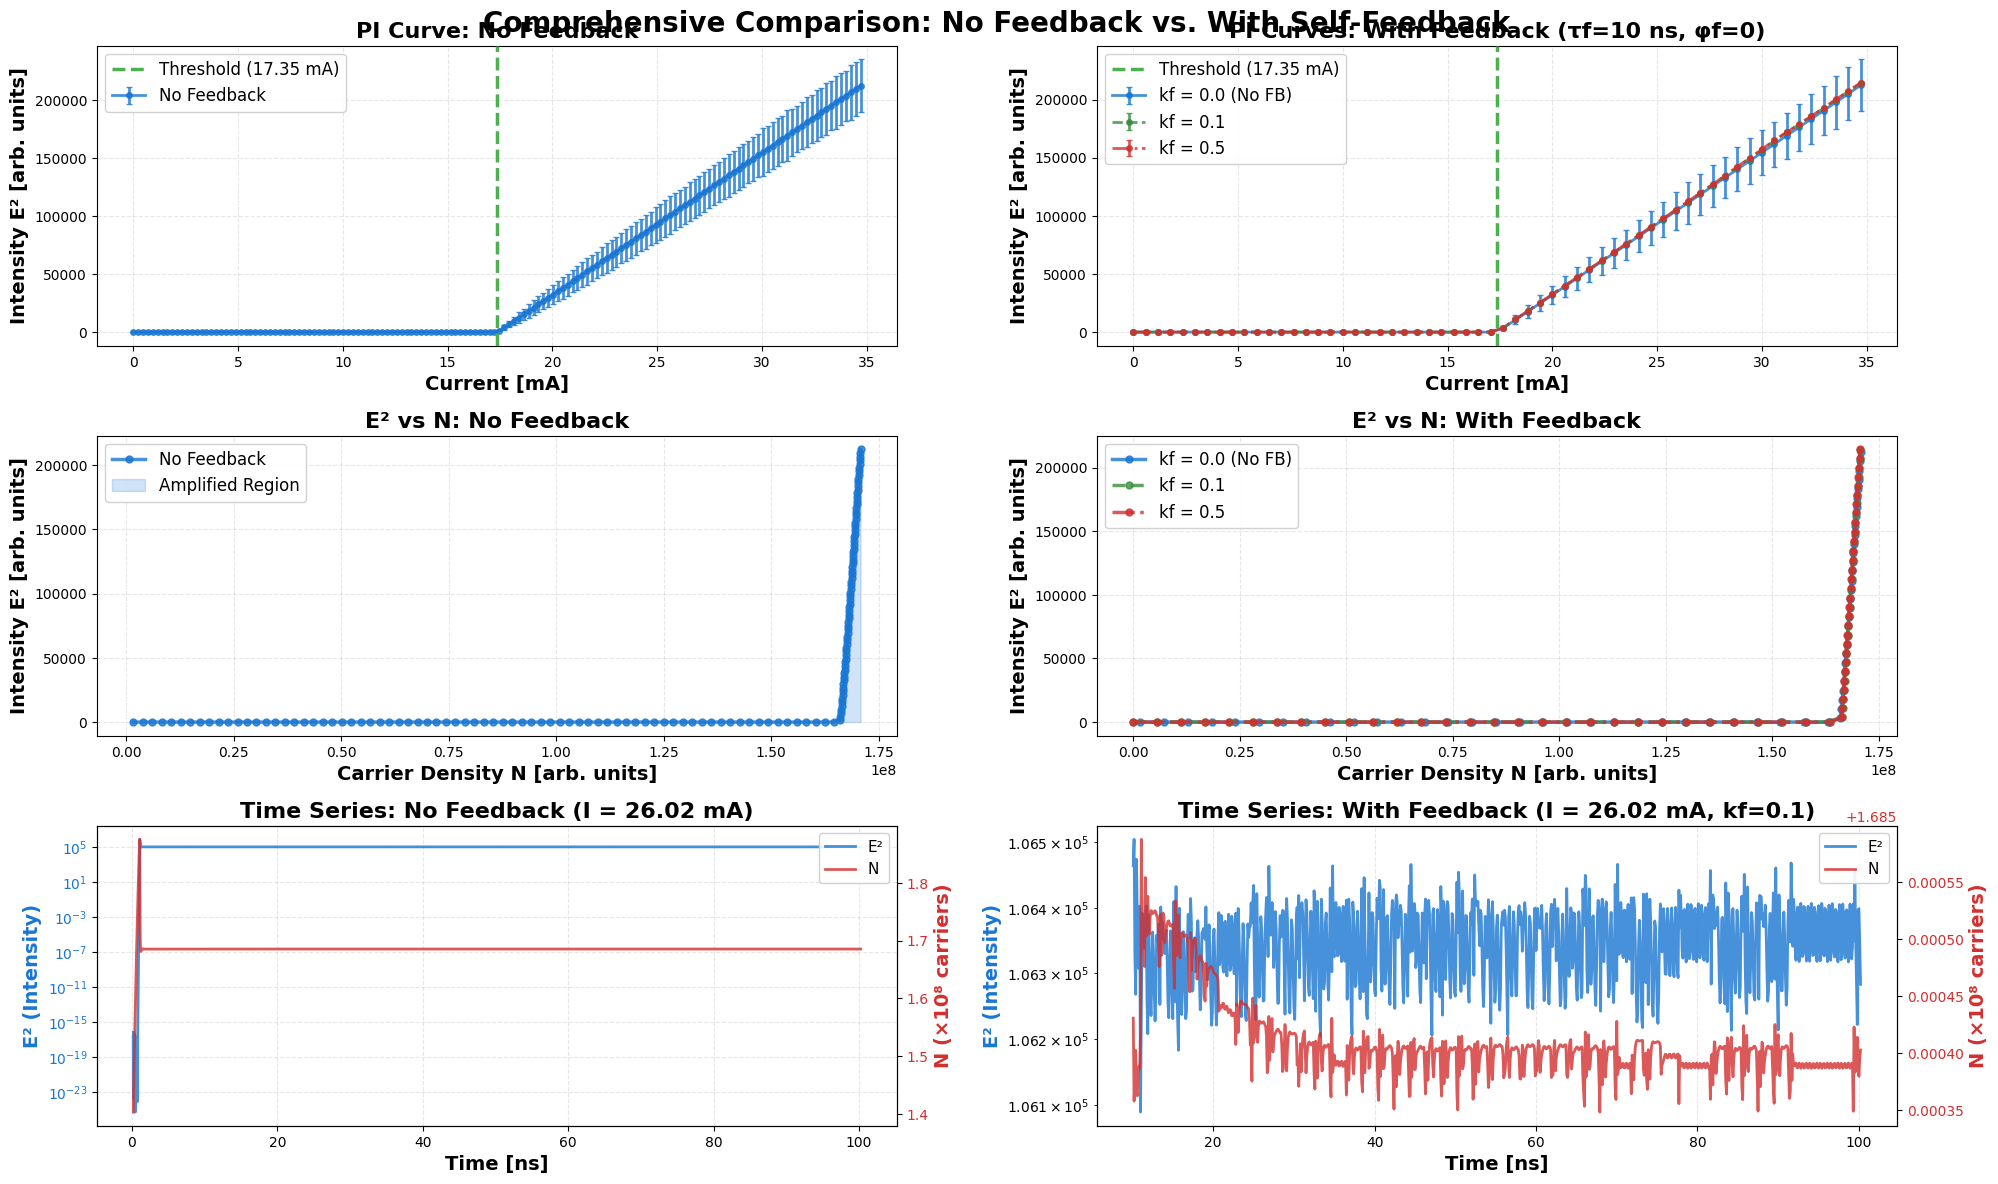

Saved: results/comprehensive_comparison_no_fb_vs_fb.png


In [37]:
# Create a comprehensive side-by-side comparison visualization
fig = plt.figure(figsize=(20, 12))

# Create grid layout: 2 columns (No FB, With FB), 3 rows (PI Curve, E² vs N, Time Series)
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.25, left=0.05, right=0.95, top=0.95, bottom=0.05)

# Row 1: PI Curves
ax1_left = fig.add_subplot(gs[0, 0])
ax1_right = fig.add_subplot(gs[0, 1])

# Left: No feedback PI curve
ax1_left.errorbar(I_sweep * 1e3, E2_mean_no_fb, yerr=E2_std_no_fb, 
                  fmt='o-', capsize=2, linewidth=2, markersize=4, 
                  color='#1976d2', alpha=0.8, label='No Feedback')
ax1_left.axvline(I_th*1e3, color='#4caf50', linestyle='--', linewidth=2.5, 
                label=f'Threshold ({I_th*1e3:.2f} mA)', zorder=10)
ax1_left.set_xlabel('Current [mA]', fontsize=14, fontweight='bold')
ax1_left.set_ylabel('Intensity E² [arb. units]', fontsize=14, fontweight='bold')
ax1_left.set_title('PI Curve: No Feedback', fontsize=16, fontweight='bold')
ax1_left.grid(True, alpha=0.3, linestyle='--')
ax1_left.legend(fontsize=12, framealpha=0.9)

# Right: With feedback PI curves
for kf in kf_values_enhanced:
    data = results_fb_enhanced[kf]
    I_mA = I_sweep_fb_enhanced * 1e3
    
    if kf == 0.0:
        label = f'kf = {kf} (No FB)'
        color = '#1976d2'
        linestyle = '-'
    elif kf == 0.1:
        label = f'kf = {kf}'
        color = '#388e3c'
        linestyle = '--'
    else:
        label = f'kf = {kf}'
        color = '#d32f2f'
        linestyle = '-.'
    
    ax1_right.errorbar(I_mA, data['E2_mean'], yerr=data['E2_std'], 
                      fmt='o', capsize=2, linewidth=2, markersize=4, 
                      color=color, linestyle=linestyle, alpha=0.8, label=label)

ax1_right.axvline(I_th*1e3, color='#4caf50', linestyle='--', linewidth=2.5, 
                 label=f'Threshold ({I_th*1e3:.2f} mA)', zorder=10)
ax1_right.set_xlabel('Current [mA]', fontsize=14, fontweight='bold')
ax1_right.set_ylabel('Intensity E² [arb. units]', fontsize=14, fontweight='bold')
ax1_right.set_title('PI Curves: With Feedback (τf=10 ns, φf=0)', fontsize=16, fontweight='bold')
ax1_right.grid(True, alpha=0.3, linestyle='--')
ax1_right.legend(fontsize=12, framealpha=0.9)

# Row 2: E² vs N
ax2_left = fig.add_subplot(gs[1, 0])
ax2_right = fig.add_subplot(gs[1, 1])

# Left: No feedback E² vs N
ax2_left.plot(N_mean_no_fb, E2_mean_no_fb, 'o-', linewidth=2.5, markersize=5, 
             color='#1976d2', alpha=0.8, label='No Feedback')
# Highlight amplified region
mask_amp = I_sweep > I_th
if np.any(mask_amp):
    N_amp = N_mean_no_fb[mask_amp]
    E2_amp = E2_mean_no_fb[mask_amp]
    ax2_left.fill_between(N_amp, 0, E2_amp, alpha=0.2, color='#1976d2', 
                          label='Amplified Region')
ax2_left.set_xlabel('Carrier Density N [arb. units]', fontsize=14, fontweight='bold')
ax2_left.set_ylabel('Intensity E² [arb. units]', fontsize=14, fontweight='bold')
ax2_left.set_title('E² vs N: No Feedback', fontsize=16, fontweight='bold')
ax2_left.grid(True, alpha=0.3, linestyle='--')
ax2_left.legend(fontsize=12, framealpha=0.9)

# Right: With feedback E² vs N
for kf in kf_values_enhanced:
    data = results_fb_enhanced[kf]
    if kf == 0.0:
        label = f'kf = {kf} (No FB)'
        color = '#1976d2'
        linestyle = '-'
        linewidth = 2.5
    elif kf == 0.1:
        label = f'kf = {kf}'
        color = '#388e3c'
        linestyle = '--'
        linewidth = 2.5
    else:
        label = f'kf = {kf}'
        color = '#d32f2f'
        linestyle = '-.'
        linewidth = 2.5
    
    ax2_right.plot(data['N_mean'], data['E2_mean'], 'o-', 
                  linewidth=linewidth, markersize=5, color=color, 
                  linestyle=linestyle, alpha=0.8, label=label)

ax2_right.set_xlabel('Carrier Density N [arb. units]', fontsize=14, fontweight='bold')
ax2_right.set_ylabel('Intensity E² [arb. units]', fontsize=14, fontweight='bold')
ax2_right.set_title('E² vs N: With Feedback', fontsize=16, fontweight='bold')
ax2_right.grid(True, alpha=0.3, linestyle='--')
ax2_right.legend(fontsize=12, framealpha=0.9)

# Row 3: Time Series Comparison (at I = 1.5×Ith)
ax3_left = fig.add_subplot(gs[2, 0])
ax3_right = fig.add_subplot(gs[2, 1])

I_compare = I_th * 1.5  # Linear region

# Left: No feedback time series
if I_compare in time_series_data_no_fb:
    data_no_fb = time_series_data_no_fb[I_compare]
    time_no_fb = data_no_fb['time'] * 1e9
    E2_no_fb = data_no_fb['E2']
    N_no_fb = data_no_fb['N'] / 1e8
    
    ax3_left_twin = ax3_left.twinx()
    line1 = ax3_left.plot(time_no_fb, E2_no_fb, 'b-', linewidth=2, 
                         label='E²', color='#1976d2', alpha=0.8)
    line2 = ax3_left_twin.plot(time_no_fb, N_no_fb, 'r-', linewidth=2, 
                               label='N', color='#d32f2f', alpha=0.8)
    
    ax3_left.set_xlabel('Time [ns]', fontsize=14, fontweight='bold')
    ax3_left.set_ylabel('E² (Intensity)', fontsize=14, fontweight='bold', color='#1976d2')
    ax3_left_twin.set_ylabel('N (×10⁸ carriers)', fontsize=14, fontweight='bold', color='#d32f2f')
    ax3_left.tick_params(axis='y', labelcolor='#1976d2')
    ax3_left_twin.tick_params(axis='y', labelcolor='#d32f2f')
    ax3_left.set_title(f'Time Series: No Feedback (I = {I_compare*1e3:.2f} mA)', 
                       fontsize=16, fontweight='bold')
    ax3_left.grid(True, alpha=0.3, linestyle='--')
    ax3_left.set_yscale('log')
    
    # Combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax3_left.legend(lines, labels, loc='upper right', fontsize=11, framealpha=0.9)

# Right: With feedback time series
if I_compare in time_series_data_fb:
    data_fb = time_series_data_fb[I_compare]
    time_fb = data_fb['time'] * 1e9
    E2_fb = data_fb['E2']
    N_fb = data_fb['N'] / 1e8
    
    ax3_right_twin = ax3_right.twinx()
    line1 = ax3_right.plot(time_fb, E2_fb, 'b-', linewidth=2, 
                          label='E²', color='#1976d2', alpha=0.8)
    line2 = ax3_right_twin.plot(time_fb, N_fb, 'r-', linewidth=2, 
                                label='N', color='#d32f2f', alpha=0.8)
    
    ax3_right.set_xlabel('Time [ns]', fontsize=14, fontweight='bold')
    ax3_right.set_ylabel('E² (Intensity)', fontsize=14, fontweight='bold', color='#1976d2')
    ax3_right_twin.set_ylabel('N (×10⁸ carriers)', fontsize=14, fontweight='bold', color='#d32f2f')
    ax3_right.tick_params(axis='y', labelcolor='#1976d2')
    ax3_right_twin.tick_params(axis='y', labelcolor='#d32f2f')
    ax3_right.set_title(f'Time Series: With Feedback (I = {I_compare*1e3:.2f} mA, kf=0.1)', 
                        fontsize=16, fontweight='bold')
    ax3_right.grid(True, alpha=0.3, linestyle='--')
    ax3_right.set_yscale('log')
    
    # Combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax3_right.legend(lines, labels, loc='upper right', fontsize=11, framealpha=0.9)

plt.suptitle('Comprehensive Comparison: No Feedback vs. With Self-Feedback', 
             fontsize=20, fontweight='bold', y=0.98)
plt.savefig('results/comprehensive_comparison_no_fb_vs_fb.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: results/comprehensive_comparison_no_fb_vs_fb.png")


### Feedback Parameter Space Summary Visualization


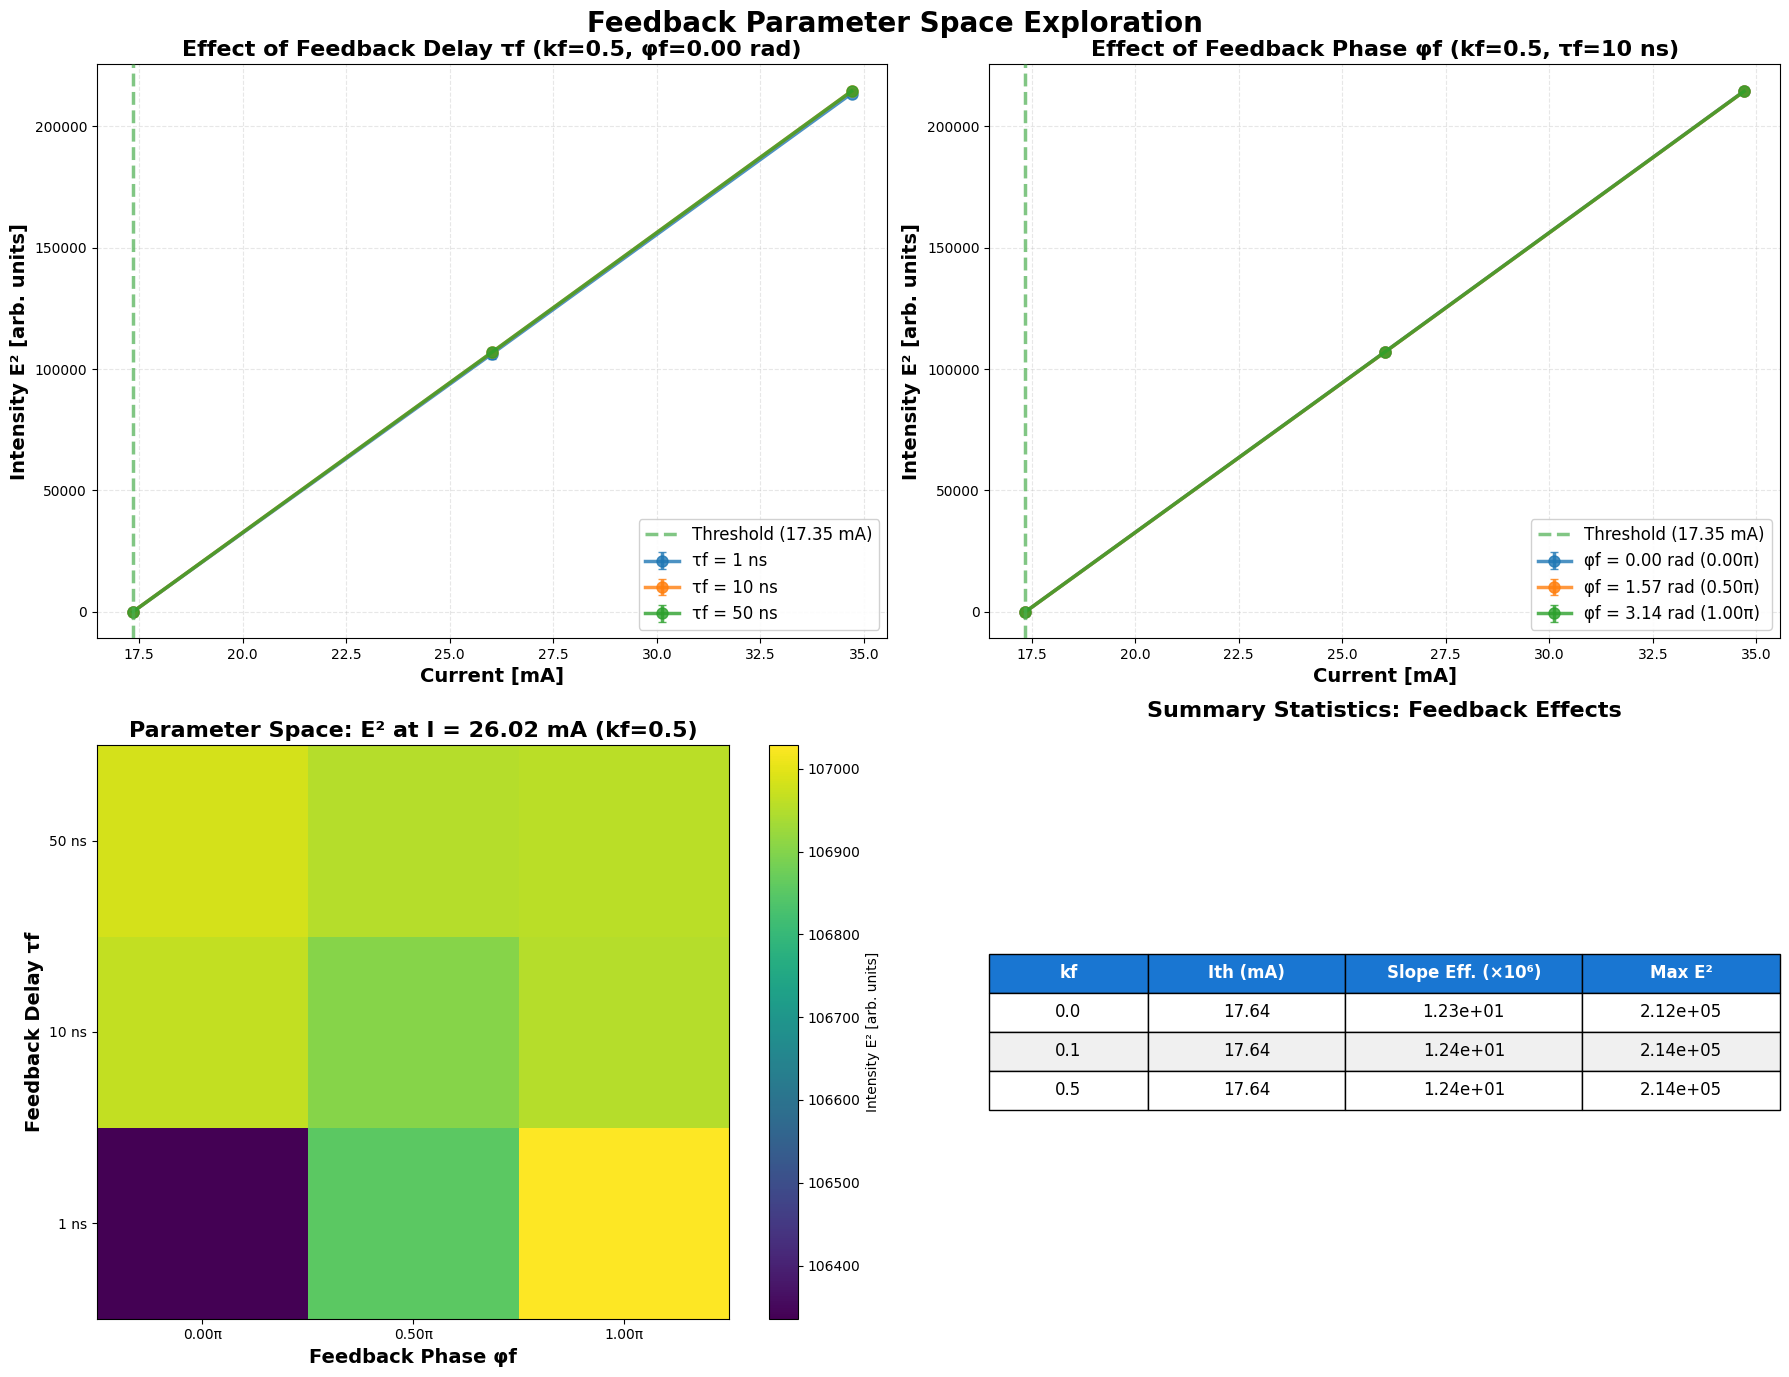

Saved: results/feedback_parameter_space_summary.png


In [38]:
# Create a comprehensive parameter space visualization showing effects of tau_f and phi_f
# Use the results_tau_phi data that was already collected

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Top Left: Effect of tau_f at different currents (phi_f = 0)
ax1 = axes[0, 0]
phi_f_plot = 0.0
for tau_f in tau_f_values:
    key = (tau_f, phi_f_plot)
    if key in results_tau_phi:
        data = results_tau_phi[key]
        I_mA = np.array(data['I']) * 1e3
        ax1.errorbar(I_mA, data['E2_mean'], yerr=data['E2_std'],
                    fmt='o-', capsize=3, linewidth=2.5, markersize=8,
                    label=f'τf = {tau_f*1e9:.0f} ns', alpha=0.8)

ax1.axvline(I_th*1e3, color='#4caf50', linestyle='--', linewidth=2.5, 
           label=f'Threshold ({I_th*1e3:.2f} mA)', zorder=10, alpha=0.7)
ax1.set_xlabel('Current [mA]', fontsize=14, fontweight='bold')
ax1.set_ylabel('Intensity E² [arb. units]', fontsize=14, fontweight='bold')
ax1.set_title(f'Effect of Feedback Delay τf (kf={kf_explore}, φf={phi_f_plot:.2f} rad)', 
             fontsize=16, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=12, framealpha=0.9)

# Top Right: Effect of phi_f at different currents (tau_f = 10 ns)
ax2 = axes[0, 1]
tau_f_plot = 10e-9
for phi_f in phi_f_values:
    key = (tau_f_plot, phi_f)
    if key in results_tau_phi:
        data = results_tau_phi[key]
        I_mA = np.array(data['I']) * 1e3
        ax2.errorbar(I_mA, data['E2_mean'], yerr=data['E2_std'],
                    fmt='o-', capsize=3, linewidth=2.5, markersize=8,
                    label=f'φf = {phi_f:.2f} rad ({phi_f/np.pi:.2f}π)', alpha=0.8)

ax2.axvline(I_th*1e3, color='#4caf50', linestyle='--', linewidth=2.5, 
           label=f'Threshold ({I_th*1e3:.2f} mA)', zorder=10, alpha=0.7)
ax2.set_xlabel('Current [mA]', fontsize=14, fontweight='bold')
ax2.set_ylabel('Intensity E² [arb. units]', fontsize=14, fontweight='bold')
ax2.set_title(f'Effect of Feedback Phase φf (kf={kf_explore}, τf={tau_f_plot*1e9:.0f} ns)', 
             fontsize=16, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=12, framealpha=0.9)

# Bottom Left: Parameter space heatmap - E² at I = 1.5×Ith
ax3 = axes[1, 0]
I_heatmap = 1.5 * I_th

# Create meshgrid for tau_f and phi_f
tau_f_array = np.array(tau_f_values) * 1e9  # Convert to ns
phi_f_array = np.array(phi_f_values)

# Extract E² values at I_heatmap
E2_heatmap = np.zeros((len(tau_f_array), len(phi_f_array)))
for i, tau_f in enumerate(tau_f_values):
    for j, phi_f in enumerate(phi_f_values):
        key = (tau_f, phi_f)
        if key in results_tau_phi:
            data = results_tau_phi[key]
            # Find closest I value to I_heatmap
            I_vals = np.array(data['I'])
            idx = np.argmin(np.abs(I_vals - I_heatmap))
            E2_heatmap[i, j] = data['E2_mean'][idx]

# Create heatmap
im = ax3.imshow(E2_heatmap, aspect='auto', origin='lower', 
                cmap='viridis', interpolation='nearest')
ax3.set_xticks(range(len(phi_f_array)))
ax3.set_xticklabels([f'{phi_f/np.pi:.2f}π' for phi_f in phi_f_array])
ax3.set_yticks(range(len(tau_f_array)))
ax3.set_yticklabels([f'{tau_f:.0f} ns' for tau_f in tau_f_array])
ax3.set_xlabel('Feedback Phase φf', fontsize=14, fontweight='bold')
ax3.set_ylabel('Feedback Delay τf', fontsize=14, fontweight='bold')
ax3.set_title(f'Parameter Space: E² at I = {I_heatmap*1e3:.2f} mA (kf={kf_explore})', 
             fontsize=16, fontweight='bold')
plt.colorbar(im, ax=ax3, label='Intensity E² [arb. units]')

# Bottom Right: Summary statistics table
ax4 = axes[1, 1]
ax4.axis('off')

# Create summary table
summary_data = []
for kf in kf_values_enhanced:
    if kf in results_fb_enhanced:
        data = results_fb_enhanced[kf]
        # Find threshold (where E² > 1% of max)
        E2_max = np.max(data['E2_mean'])
        threshold_idx = np.where(data['E2_mean'] > 0.01 * E2_max)[0]
        if len(threshold_idx) > 0:
            I_th_eff = I_sweep_fb_enhanced[threshold_idx[0]]
            # Calculate slope efficiency in linear region
            mask_linear = (I_sweep_fb_enhanced > I_th_eff * 1.05) & (I_sweep_fb_enhanced < I_th_eff * 2.0)
            if np.sum(mask_linear) > 5:
                I_linear = I_sweep_fb_enhanced[mask_linear]
                E2_linear = data['E2_mean'][mask_linear]
                slope = np.polyfit(I_linear, E2_linear, 1)[0]
            else:
                slope = 0
        else:
            I_th_eff = I_th
            slope = 0
        
        summary_data.append([
            f'{kf:.1f}',
            f'{I_th_eff*1e3:.2f}',
            f'{slope*1e-6:.2e}',
            f'{np.max(data["E2_mean"]):.2e}'
        ])

table = ax4.table(cellText=summary_data,
                 colLabels=['kf', 'Ith (mA)', 'Slope Eff. (×10⁶)', 'Max E²'],
                 cellLoc='center',
                 loc='center',
                 colWidths=[0.2, 0.25, 0.3, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

# Style the table
for i in range(len(summary_data) + 1):
    for j in range(4):
        cell = table[(i, j)]
        if i == 0:  # Header row
            cell.set_facecolor('#1976d2')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

ax4.set_title('Summary Statistics: Feedback Effects', 
             fontsize=16, fontweight='bold', pad=20)

plt.suptitle('Feedback Parameter Space Exploration', 
             fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('results/feedback_parameter_space_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: results/feedback_parameter_space_summary.png")


In [39]:
# Save all results to .npz file
import os
os.makedirs('results', exist_ok=True)

# Flatten nested dictionaries for saving
save_dict = {
    # No feedback results
    'I_sweep': I_sweep,
    'E2_mean_no_fb': E2_mean_no_fb,
    'E2_std_no_fb': E2_std_no_fb,
    'N_mean_no_fb': N_mean_no_fb,
    'V_mean_no_fb': V_mean_no_fb,
    
    # Feedback results - flatten results_fb
    'I_sweep_fb': I_sweep_fb,
    'kf_values': np.array(kf_values),
}

# Add flattened feedback results
for kf in kf_values:
    save_dict[f'E2_mean_kf_{kf}'] = results_fb[kf]['E2_mean']
    save_dict[f'E2_std_kf_{kf}'] = results_fb[kf]['E2_std']
    save_dict[f'N_mean_kf_{kf}'] = results_fb[kf]['N_mean']

# Add exploration results
save_dict['I_explore'] = np.array(I_explore)
save_dict['tau_f_values'] = np.array(tau_f_values)
save_dict['phi_f_values'] = np.array(phi_f_values)
save_dict['kf_explore'] = kf_explore

# Flatten tau_phi results
for (tau_f, phi_f), data in results_tau_phi.items():
    key = f'tau_{tau_f*1e9:.0f}_phi_{phi_f:.2f}'
    save_dict[f'{key}_E2_mean'] = np.array(data['E2_mean'])
    save_dict[f'{key}_E2_std'] = np.array(data['E2_std'])
    save_dict[f'{key}_I'] = np.array(data['I'])
    
# Add metadata as separate arrays
save_dict['I_th'] = I_th
save_dict['I_low'] = metadata['I_low']
save_dict['I_high'] = metadata['I_high']
save_dict['linear_region_indices'] = metadata['linear_region_indices']
save_dict['T_trans'] = metadata['T_trans']
save_dict['T_sample'] = metadata['T_sample']
save_dict['dt_ode'] = metadata['dt_ode']
save_dict['dt_dde'] = metadata['dt_dde']

# Physical constants
save_dict['alpha'] = alpha
save_dict['g'] = g
save_dict['N_0'] = N_0
save_dict['s'] = s
save_dict['gamma'] = gamma
save_dict['gamma_e'] = gamma_e

np.savez('results/solitary_laser_results.npz', **save_dict)

print("Results saved to results/solitary_laser_results.npz")
print(f"  Saved {len(save_dict)} arrays/variables")


Results saved to results/solitary_laser_results.npz
  Saved 61 arrays/variables
